# Home Credit Scorecard Model

### Overview
PT Home Credit Indonesia is a technology-based financing company that has been in operation since 2013, with an extensive network of partner stores in over 200 cities across Indonesia. Home Credit continues to evolve into a trusted financial partner for millions of customers. Currently, we are designing statistical methods and machine learning techniques to generate credit score predictions. By doing so, we ensure that customers capable of making payments are not rejected when applying for loans. Loans can be granted with a principal, maturity, and repayment calendar designed to motivate customers toward success.
1. <b>Problem:</b> 8% of the total 307,511 customers are experiencing loan defaults, posing a potential risk of financial loss.
2. <b>Goals:</b> Decrease the default rate among customers to minimize the potential risk of financial loss.
3. <b>Objective:</b> Develop a classification model to generate credit score predictions for binary values (0 indicating clients without payment difficulties and 1 indicating clients with payment difficulties), and selectively approve loans based on predictions of 0.
4. <b>Business Metrics:</b> Default rate.

### About The Dataset
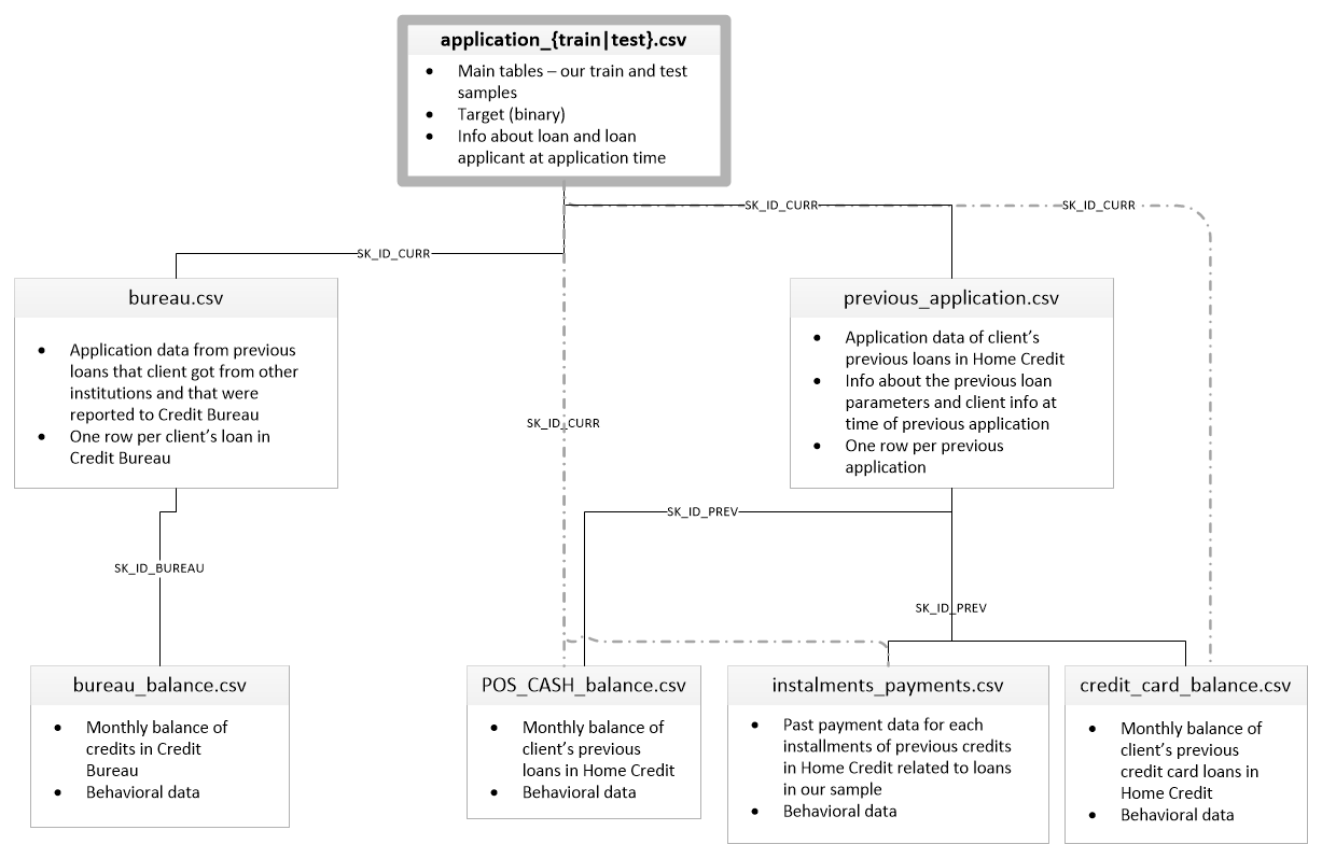

This data is provided by Home Credit Indonesia, includes 7 different sources:
1. **application_{train|test}.csv:**
   - Main table for loan applications, split into Train (with TARGET) and Test (without TARGET).
   - Static data for all applications, with each row representing one loan.  
2. **bureau.csv:**
   - Records client's previous credits from other financial institutions reported to the Credit Bureau.
   - Multiple rows per loan, corresponding to the number of credits the client had before the application date.
3. **bureau_balance.csv:**
   - Monthly balances of previous credits reported to the Credit Bureau.
   - One row for each month of history for every previous credit, resulting in (#loans * #credits * #months with observable history) rows.
4. **POS_CASH_balance.csv:**
   - Monthly balance snapshots of previous POS and cash loans with Home Credit.
   - One row for each month of history for every previous credit in Home Credit related to loans in our sample.
5. **credit_card_balance.csv:**
   - Monthly balance snapshots of previous credit cards with Home Credit.
   - One row for each month of history for every previous credit in Home Credit related to loans in our sample.
6. **previous_application.csv:**
   - Records all previous applications for Home Credit loans from clients with loans in our sample.
   - One row for each previous application related to loans in our data sample.
7. **installments_payments.csv:**
   - Repayment history for previously disbursed credits in Home Credit related to loans in our sample.
   - One row for every payment made and one for each missed payment, equivalent to one payment of one installment or one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.
   
```
Not all data will be utilized in this project, as specific columns from each table have been selected based on their perceived influence on the target. The joining process is executed using PostgreSQL and is applied to both the training and test data sets.
```

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, cross_val_score, cross_validate, RandomizedSearchCV, GridSearchCV, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.utils import shuffle
from sklearn.model_selection import KFold
kf = KFold(10, shuffle=True, random_state=0)

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from scipy.stats import uniform

import re
import shap

import warnings
warnings.filterwarnings("ignore")

pd.set_option('float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set(rc={'figure.figsize':(15, 8)})
sns.set_style("whitegrid")

In [2]:
# Load the training dataset
train_df = pd.read_csv('train_dataset.csv')

In [3]:
# Check the contents of the training dataset
train_df.sample(5)

sk_id_curr  target name_contract_type_curr code_gender flag_own_car  \
224040      359491       0         Revolving loans           F            N   
14249       116621       0         Revolving loans           M            N   
197281      328737       0              Cash loans           M            N   
938         101082       0              Cash loans           F            N   
105473      222389       0              Cash loans           M            N   

       flag_own_realty  cnt_children  amt_income_total  amt_credit_curr  \
224040               Y             0         180000.00        247500.00   
14249                Y             0         292500.00        427500.00   
197281               Y             0         180000.00        225000.00   
938                  Y             1         270000.00        545040.00   
105473               Y             0         112500.00        495000.00   

        amt_annuity_curr  amt_goods_price_curr      name_income_type  \
224040          12375.00             247500.00               Working   
14249           21375.00             427500.00  Commercial associate   
197281          10944.00             225000.00               Working   
938             26640.00             450000.00               Working   
105473          16096.50             495000.00               Working   

                  name_education_type    name_family_status  \
224040  Secondary / secondary special               Married   
14249   Secondary / secondary special               Married   
197281  Secondary / secondary special  Single / not married   
938     Secondary / secondary special               Married   
105473  Secondary / secondary special               Married   

        name_housing_type  days_birth  days_employed  days_registration  \
224040  House / apartment      -19410          -1777          -15609.00   
14249   House / apartment      -16966          -1397           -4005.00   
197281  House / apartment       -8639          -1316           -6139.00   
938     House / apartment      -14562          -2149           -2202.00   
105473  House / apartment      -10858            -87          -10820.00   

        days_id_publish        occupation_type  cnt_fam_members  \
224040            -2953            Sales staff             2.00   
14249              -514  High skill tech staff             2.00   
197281            -1315  High skill tech staff             1.00   
938               -4519             Core staff             3.00   
105473            -3387               Managers             2.00   

        region_rating_client       organization_type  ext_source_1  \
224040                     2           Trade: type 7          0.55   
14249                      1                   Other           NaN   
197281                     2  Business Entity Type 1          0.45   
938                        2           Self-employed           NaN   
105473                     2  Business Entity Type 3           NaN   

        ext_source_2  ext_source_3  days_last_phone_change  \
224040          0.62          0.27                -1097.00   
14249           0.75          0.57                 -711.00   
197281          0.53          0.55                -1014.00   
938             0.65           NaN                   -1.00   
105473          0.70           NaN                 -880.00   

       credit_bureau_active  avg_credit_day_overdue  days_credit_enddate  \
224040               Closed                    0.00             -1794.00   
14249                Active                    0.00              1426.00   
197281               Active                    0.00               289.00   
938                     NaN                     NaN                  NaN   
105473               Active                    0.00              9027.00   

        avg_amt_credit_max_overdue  avg_credit_prolong  avg_credit_sum  \
224040                        0.00                0.00       219189.52   
14249            

In [30]:
# Load the testing dataset 
df_test = pd.read_csv('test_dataset.csv')

In [31]:
# Check the contents of the testing dataset
df_test.sample(5)

sk_id_curr name_contract_type_curr code_gender flag_own_car  \
11103      180598              Cash loans           M            Y   
28228      305946              Cash loans           M            Y   
15269      210018              Cash loans           F            N   
33839      346890              Cash loans           F            N   
12979      194370              Cash loans           F            N   

      flag_own_realty  cnt_children  amt_income_total  amt_credit_curr  \
11103               Y             1         112500.00        140746.50   
28228               N             0         225000.00        886500.00   
15269               Y             0         162000.00        450000.00   
33839               Y             0          90000.00        117000.00   
12979               Y             0          76500.00        675000.00   

       amt_annuity_curr  amt_goods_price_curr      name_income_type  \
11103          16830.00             121500.00               Working   
28228          61830.00             886500.00               Working   
15269          21649.50             450000.00  Commercial associate   
33839          11988.00             117000.00               Working   
12979          29862.00             675000.00             Pensioner   

                 name_education_type    name_family_status  name_housing_type  \
11103  Secondary / secondary special               Married  House / apartment   
28228  Secondary / secondary special  Single / not married  House / apartment   
15269  Secondary / secondary special               Married  House / apartment   
33839               Higher education               Married  House / apartment   
12979  Secondary / secondary special                 Widow  House / apartment   

       days_birth  days_employed  days_registration  days_id_publish  \
11103       -8109           -139           -8074.00             -753   
28228      -20556          -1581           -9980.00            -3924   
15269      -14673           -377            -660.00            -1642   
33839      -22425          -5593           -9930.00            -4473   
12979      -22564         365243           -2758.00            -4592   

      occupation_type  cnt_fam_members  region_rating_client  \
11103         Drivers             3.00                     2   
28228         Drivers             1.00                     2   
15269        Managers             2.00                     1   
33839        Managers             2.00                     2   
12979             NaN             1.00                     2   

            organization_type  ext_source_1  ext_source_2  ext_source_3  \
11103        Industry: type 3          0.37          0.05          0.40   
28228  Business Entity Type 3          0.67          0.69          0.46   
15269  Business Entity Type 3          0.78          0.68          0.25   
33839                Medicine          0.94          0.71           NaN   
12979                     XNA           NaN          0.76          0.75   

       days_last_phone_change credit_bureau_active  avg_credit_day_overdue  \
11103                -1422.00               Active                    0.00   
28228                -2732.00               Closed                    0.00   
15269                -1880.00               Closed                    0.00   
33839                 -886.00               Active                    0.00   
12979                 -745.00               Closed                    0.00   

       days_credit_enddate  avg_amt_credit_max_overdue  avg_credit_prolong  \
11103               513.00                         NaN                0.00   
28228             -1276.00                        0.00                0.00   
15269             -1912.00                    30964.50                0.00   
33839              -105.00                        0.00                0.00   
12979             -1299.00                         NaN                0.00   

       avg_credit_su

#### Description of Each Column:
1. sk_id_curr: ID of loan in our sample	
2. target: Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)	
3. name_contract_type_curr: Identification if loan is cash or revolving	
4. code_gender: Gender of the client
5. flag_own_car: Flag if the client owns a car
6. flag_own_realty: Flag if client owns a house or flat
7. cnt_children: Number of children the client has
8. amt_income_total: Income of the client
9. amt_credit_curr: Current credit amount of the loan
10. amt_annuity_curr: Current loan annuity
11. amt_goods_price_curr: For consumer loans it is the price of the goods for which the loan is given
12. name_income_type: Clients income type (businessman, working, maternity leave,…)	
13. name_education_type: Level of highest education the client achieved
14. name_family_status: Family status of the client	
15. name_housing_type: What is the housing situation of the client (renting, living with parents, ...)	
16. days_birth: Client's age in days at the time of application	
17. days_employed: How many days before the application the person started current employment	
18. days_registration: How many days before the application did client change his registration	
19. days_id_publish: How many days before the application did client change the identity document with which he applied for the loan	
20. occupation_type: What kind of occupation does the client have	
21. cnt_fam_members: How many family members does client have	
22. region_rating_client: Our rating of the region where client lives (1,2,3)	
23. organization_type: Type of organization where client works
24. ext_source_1: Normalized score from external data source	
25. ext_source_2: Normalized score from external data source	
26. ext_source_3: Normalized score from external data source	
27. days_last_phone_change: How many days before application did client change phone	
28. credit_bureau_active: Status of the Credit Bureau (CB) reported credits	
29. avg_credit_day_overdue: Average of days past due on CB credit at the time of application for related loan in our sample	
30. days_credit_enddate: Remaining duration of CB credit (in days) at the time of application in Home Credit	
31. avg_amt_credit_max_overdue: Average of maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)	
32. avg_credit_prolong: How many average times was the Credit Bureau credit prolonged	
33. avg_credit_sum: Average of current credit amount for the Credit Bureau credit	
34. avg_amt_credit_sum_debt: Average of current debt on Credit Bureau credit	
35. avg_amt_credit_sum_limit: Average of current credit limit of credit card reported in Credit Bureau	
36. avg_amt_credit_sum_overdue: Average of current amount overdue on Credit Bureau credit	
37. credit_type: Type of Credit Bureau credit (Car, cash,...)	
38. days_credit_update: How many days before loan application did last information about the Credit Bureau credit come	
39. amt_annuity_cb: Annuity of the Credit Bureau credit	
40. months_balance_cb: Month of balance relative to application date (-1 means the freshest balance date)	
41. status_cb: Status of Credit Bureau loan during the month (active, closed, DPD0-30,… [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,… 5 means DPD 120+ or sold or written off ])	
42. name_contract_type_prev: Contract product type in previous (Cash loan, consumer loan [POS] ,...) of the previous application
43. avg_amt_annuity_prev: Average of annuity of previous application	
44. avg_down_payment_prev: Average of down payment on the previous application	
45. avg_amt_goods_price_prev: Average of goods price of good that client asked for (if applicable) on the previous application	
46. name_contract_status_prev: Contract status (approved, cancelled, ...) of previous application	
47. code_reject_reason_prev: Why was the previous application rejected	
48. name_portfolio_prev: Was the previous application for CASH, POS, CAR, …	
49. num_instalment_version: Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed	
50. num_instalment_number: On which installment we observe payment	
51. days_instalment: When the installment of previous credit was supposed to be paid (relative to application date of current loan)	
52. days_entry_payment: When was the installments of previous credit paid actually (relative to application date of current loan)	
53. avg_amt_instalment: What was the prescribed installment amount of previous credit on this installment	
54. avg_amt_payment: What the client actually paid on previous credit on this installment	
55. months_balance_pos: Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly)	
56. cnt_instalment_future: Installments left to pay on the previous credit	
57. name_contract_status_pos: Contract status during the month	
58. sk_dpd_pos: DPD (days past due) during the month of previous credit	
59. sk_dpd_def_pos: DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit	
60. months_balance_cc: Month of balance relative to application date (-1 means the freshest balance date)	
61. amt_balance_cc: Balance during the month of previous credit	
62. amt_credit_(limit)_actual_cc: Credit card limit during the month of the previous credit 	
63. avg_amt_drawings_current: Average of amount drawing during the month of the previous credit	
64. avg_amt_drawings_pos_current: Average of amount drawing or buying goods during the month of the previous credit	
65. amt_inst_min_regularity: Minimal installment for this month of the previous credit	
66. amt_payment_current: How much did the client pay during the month on the previous credit	
67. amt_receivable_principal: Amount receivable for principal on the previous credit	
68. amt_total_receivable: Total amount receivable on the previous credit	
69. cnt_instalment_mature_cum: Number of paid installments on the previous credit	
70. name_contract_status_cc: Contract status (active signed,...) on the previous credit	
71. sk_dpd_cc: DPD (Days past due) during the month on the previous credit	
72. sk_dpd_def_cc: DPD (Days past due) during the month with tolerance (debts with low loan amounts are ignored) of the previous credit

## Exploratory Data Analysis

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 72 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   sk_id_curr                    307511 non-null  int64  
 1   target                        307511 non-null  int64  
 2   name_contract_type_curr       307511 non-null  object 
 3   code_gender                   307511 non-null  object 
 4   flag_own_car                  307511 non-null  object 
 5   flag_own_realty               307511 non-null  object 
 6   cnt_children                  307511 non-null  int64  
 7   amt_income_total              307511 non-null  float64
 8   amt_credit_curr               307511 non-null  float64
 9   amt_annuity_curr              307499 non-null  float64
 10  amt_goods_price_curr          307233 non-null  float64
 11  name_income_type              307511 non-null  object 
 12  name_education_type           307511 non-nul

In [17]:
# Check the dataset with missing values >=50% from the total
train_df.isnull().sum()[train_df.isnull().sum() >= 153755]

ext_source_1                    173378
amt_annuity_cb                  227502
months_balance_cb               215280
status_cb                       215280
amt_balance_cc                  220606
amt_credit_actual_cc            220606
avg_amt_drawings_current        220606
avg_amt_drawings_pos_current    246371
amt_inst_min_regularity         220606
amt_payment_current             246451
amt_receivable_principal        220606
amt_total_receivable            220606
cnt_instalment_mature_cum       220606
name_contract_status_cc         220606
sk_dpd_cc                       220606
sk_dpd_def_cc                   220606
dtype: int64

**Summary:**
- The training dataset consists of 72 columns and 307511 rows
- Missing values are observed in several columns, dimana untuk kolom-kolom ext_source_1, amt_annuity_cb, months_balance_cb, status_cb, amt_balance_cc, amt_credit_actual_cc, avg_amt_drawings_current, avg_amt_drawings_pos_current, amt_inst_min_regularity, amt_payment_current, amt_receivable_principal, amt_total_receivable, cnt_instalment_mature_cum, name_contract_status_cc, sk_dpd_cc, sk_dpd_def_cc memiliki missing values >50% dari total baris, sehingga nantinya akan di drop saat preprocessing agar tidak menyebabkan bias.

### Statistical Analysis

In [4]:
# Separate categorical and numerical columns
num_cols = []
cat_cols = []

for a, i in train_df.items():
    if i.dtype == 'object':
        cat_cols.append(a)
    else:
        num_cols.append(a)

#### Categorical Summaries

In [11]:
train_df[cat_cols].describe().T

count unique                            top  \
name_contract_type_curr    307511      2                     Cash loans   
code_gender                307511      3                              F   
flag_own_car               307511      2                              N   
flag_own_realty            307511      2                              Y   
name_income_type           307511      8                        Working   
name_education_type        307511      5  Secondary / secondary special   
name_family_status         307511      6                        Married   
name_housing_type          307511      6              House / apartment   
occupation_type            211120     18                       Laborers   
organization_type          307511     58         Business Entity Type 3   
credit_bureau_active       263491      3                         Closed   
credit_type                263491     12                Consumer credit   
status_cb                   92231      6                              C   
name_contract_type_prev    291057      4                 Consumer loans   
name_contract_status_prev  291057      4                       Approved   
code_reject_reason_prev    291057      9                            XAP   
name_portfolio_prev        291057      5                            POS   
name_contract_status_pos   289444      7                         Active   
name_contract_status_cc     86905      4                         Active   

                             freq  
name_contract_type_curr    278232  
code_gender                202448  
flag_own_car               202924  
flag_own_realty            213312  
name_income_type           158774  
name_education_type        218391  
name_family_status         196432  
name_housing_type          272868  
occupation_type             55186  
organization_type           67992  
credit_bureau_active       168060  
credit_type                226210  
status_cb                   43527  
name_contract_type_prev    160734  
name_contract_status_prev  257579  
code_reject_reason_prev    269404  
name_portfolio_prev        166144  
name_contract_status_pos   288630  
name_contract_status_cc     85903

**Summary:**
- Contract type cash loans lebih banyak diminati dibanding revolving loans. Berbeda dengan contract type saat ini, consumer loans lebih diminati pada contract type sebelumnya
- Clients didominasi oleh perempuan
- Lebih banyak client yang tidak memiliki mobil namun memiliki realty 
- Setengah dari total client memperoleh pendapatan dengan bekerja
- Education level of clients didominasi oleh secondary/secondary special
- Clients yang ada sebagian besar berstatus menikah
- Lebih dari 80% clients sudah memiliki rumah/apartment
- Occupation type didominasi oleh laborers, menunjukkan bahwa sebagian besar clients memilih pekerjaan dengan skill yang tidak terlalu spesifik
- Organization type didominasi oleh business entity
- Status of the Credit Bureau (CB) didominasi oleh closed, menunjukkan bahwa kreditnya sudah ditutup/ selesai
- Consumer credit merupakan credit type yang lebih diminati oleh cliens dibandingkan dengan credit type lainnya.
- Rata-rata clients memiliki most frequent approved sebagai contract statusnya, dimana menandakan sebagian besar clients memiliki record yang cukup baik.
- code_reject_reason terbanyak adalah XAP, dimana diduga XAP merupakan kode untuk menunjukkan clients yang tidak direject karena sebagian besar contract status dari clients memang approved.
- portfolio sebelumnya didominasi oleh POS
- contract status pos cash dan credit card sama-sama didominasi oleh Active

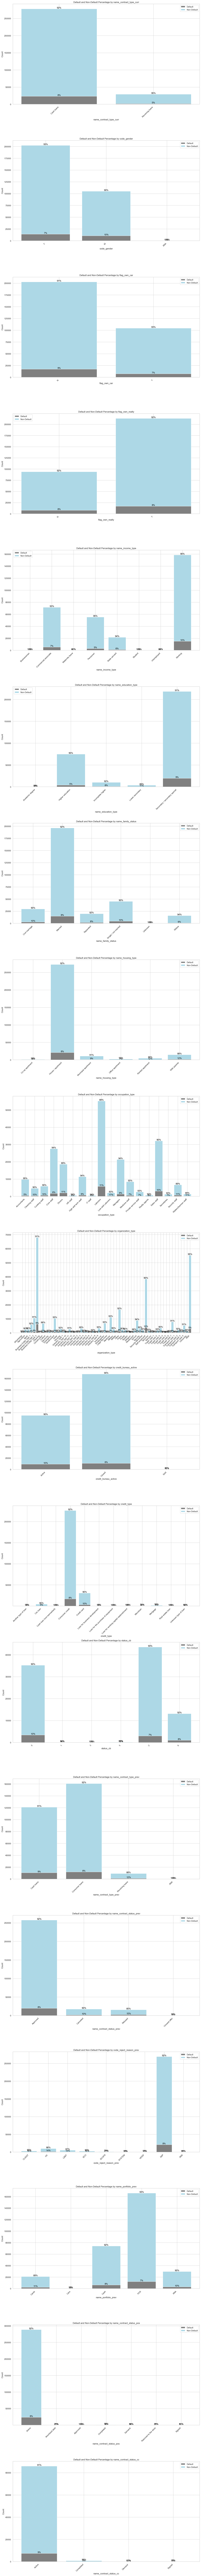

In [5]:
"""
Analysis of categorical columns involves examining the relationship between individual categorical 
features and the target variable. (Bivariate Analysis)
"""

plt.figure(figsize=(15, 190))
for i in range(0, len(cat_cols)):
    plt.subplot(19, 1, i + 1)
    
    count_by_cat = train_df[cat_cols[i]].value_counts()
    
    customer_status = train_df.groupby([cat_cols[i], 'target']).size().unstack().fillna(0)
    
    customer_status['default_percentage'] = (customer_status[1] / (customer_status[0] + customer_status[1])) * 100
    customer_status['non_default_percentage'] = (customer_status[0] / (customer_status[0] + customer_status[1])) * 100
    
    plt.bar(customer_status.index, customer_status[1], color='grey', label='Default')
    plt.bar(customer_status.index, customer_status[0], bottom=customer_status[1], color='lightblue', label='Non-Default')
    
    for j, (default_percentage, non_default_percentage) in enumerate(zip(customer_status['default_percentage'], customer_status['non_default_percentage'])):
        plt.text(j, customer_status[1][j], f'{default_percentage:.0f}%', ha='center', va='bottom', color='black')
        plt.text(j, customer_status[0][j] + customer_status[1][j], f'{non_default_percentage:.0f}%', ha='center', va='bottom', color='black')

    plt.xticks(range(len(customer_status.index)), customer_status.index, rotation=45, ha="right")
    plt.xlabel(cat_cols[i])
    plt.ylabel('Count')
    plt.title(f'Default and Non-Default Percentage by {cat_cols[i]}')
    plt.legend()

plt.tight_layout()
plt.show()

**Summary:**
- Meskipun cash loans memiliki jumlah clients yang lebih banyak dibandingkan revolving loans, namun default rate dari cash loans juga lebih tinggi.Berbeda dengan default rate name contract saat ini yang tertingginya adalah cash loans, name contract sebelumnya memiliki default rate tertinggi pada revolving loans.
- Clients dengan jenis kelamin perempuan memiliki jumlah yang lebih banyak dibandingkan laki-laki, namun clients laki-laki memiliki default rate yang lebih tinggi dibandingkan perempuan.
- Meskipun clients yang tidak memiliki mobil jumlah clientsnya lebih banyak dibandingkan yang memiliki mobil, namun default rate dari clients yang tidak memiliki mobil juga lebih tinggi.
- Student dan businessman tidak terdapat client yang mengalami kesulitan bayar, sedangkan pada maternity leave dan unemployed memiliki default rate yang cukup tinggi, yaitu mencapai 40% dari total clients di kategori tersebut.
- Clients dengan education level lower secondary memiliki default rate yang lebih tinggi dibandingkan clients dengan education level yang lain.
- Clients dengan status civil marriage dan single/not married memiliki default rate yang lebih tinggi dibandingkan status yang lainnya.
- Clients dengan housing type rented apartment dan with parents memiliki default rate yang lebih tinggi dibandingkan clients dengan housing type yang lain.
- Clients dengan occupation type low-skill laborers memiliki default rate yang lebih tinggi dibandingkan clients dengan occupation type yang lain.
- clients dengan status credit bureau yang masih aktif memiliki default rate yang lebih tinggi jika dibandingkan clients dengan credit bureau closed
- Clients dengan credit type Cash loan (non-earmarked), Loan for the purchase of equipment, Loan for working capital replenishment dan Real estate loan tidak ada yang mengalami kesulitan bayar. Clients dengan default rate tertinggi adalah pada credit type Microloan
- Clients dengan status cb = 3 (DPD 61-90,) tidak ada yang mengalami kesulitan bayar. Clients dengan default rate tertinggi adalah pada status cb = 1 (maximal did during month between 1-30)
- Name contract status dengan default rate tertinggi pada loan sebelumnya adalah refused
- pada loan sebelumnya yang paling banyak menyebabkan reject adalah dikarenakan SCOFR
- Clients dengan default rate tertinggi pada loan sebelumnya adalah yang application for cards
- Clients dengan ontract status during the month Approved tidak ada yang mengalami kesulitan bayar. Clients dengan default rate tertinggi adalah dengan contract status during the month Amortized debt
- Clients dengan contract status Demand on the previous credit memiliki default rate yang paling tinggi.

#### Numerical Summaries

In [12]:
train_df[num_cols].describe().T

count      mean       std         min  \
sk_id_curr                   307511.00 278180.52 102790.18   100002.00   
target                       307511.00      0.08      0.27        0.00   
cnt_children                 307511.00      0.42      0.72        0.00   
amt_income_total             307511.00 168797.92 237123.15    25650.00   
amt_credit_curr              307511.00 599026.00 402490.78    45000.00   
amt_annuity_curr             307499.00  27108.57  14493.74     1615.50   
amt_goods_price_curr         307233.00 538396.21 369446.46    40500.00   
days_birth                   307511.00 -16037.00   4363.99   -25229.00   
days_employed                307511.00  63815.05 141275.77   -17912.00   
days_registration            307511.00  -4986.12   3522.89   -24672.00   
days_id_publish              307511.00  -2994.20   1509.45    -7197.00   
cnt_fam_members              307509.00      2.15      0.91        1.00   
region_rating_client         307511.00      2.05      0.51        1.00   
ext_source_1                 134133.00      0.50      0.21        0.01   
ext_source_2                 306851.00      0.51      0.19        0.00   
ext_source_3                 246546.00      0.51      0.19        0.00   
days_last_phone_change       307510.00   -962.86    826.81    -4292.00   
avg_credit_day_overdue       263491.00      1.10     27.63        0.00   
days_credit_enddate          261242.00  -1029.58   2640.34   -42060.00   
avg_amt_credit_max_overdue   183886.00   5528.73 354074.02        0.00   
avg_credit_prolong           263491.00      0.00      0.06        0.00   
avg_credit_sum               263490.00 369651.80 888674.39        0.00   
avg_amt_credit_sum_debt      256131.00 148794.13 520479.50 -1083614.67   
avg_amt_credit_sum_limit     242442.00   5785.26  30134.24   -97891.66   
avg_amt_credit_sum_overdue   263491.00     48.60   5290.90        0.00   
days_credit_update           263491.00  -1181.36   1118.15   -41947.00   
amt_annuity_cb                80009.00  13486.43 251543.90        0.00   
months_balance_cb             92231.00    -21.82     12.93      -92.50   
avg_amt_annuity_prev         290640.00  14532.05  10007.48        0.00   
avg_down_payment_prev        273605.00   7080.50  18421.80       -0.23   
avg_amt_goods_price_prev     290082.00 193895.91 192576.06        0.00   
num_instalment_version       291643.00      2.10      1.86        0.00   
num_instalment_number        291643.00      8.65     10.27        1.00   
days_instalment              291643.00   -881.16    662.85    -2922.00   
days_entry_payment           291635.00   -892.53    661.63    -3071.00   
avg_amt_instalment           291643.00  18392.61  23337.97        0.00   
avg_amt_payment              291635.00  18754.31  25105.36        0.19   
months_balance_pos           289444.00    -31.07     22.32      -96.00   
cnt_instalment_future        289420.00      0.56      2.77        0.00   
sk_dpd_pos                   289444.00     15.70    153.17        0.00   
sk_dpd_def_pos               289444.00      1.47     30.61        0.00   
months_balance_cc            289444.00    -31.07     22.32      -96.00   
amt_balance_cc                86905.00  71459.93 109056.52    -2930.23   
amt_credit_actual_cc          86905.00 208260.58 191529.93        0.00   
avg_amt_drawings_current      86905.00  13913.48  26610.58        0.00   
avg_amt_drawings_pos_current  61140.00   8304.02  22454.09        0.00   
amt_inst_min_regularity       86905.00   3606.65   5145.89        0.00   
amt_payment_current           61060.00 437291.06 506766.97        0.00   
amt_receivable_principal      86905.00  10364.93  43635.18  -423305.82   
amt_total_receivable          86905.00  10391.03  44442.62  -420250.18   
cnt_instalment_mature_cum     86905.00     16.29     21.65        0.00   
sk_dpd_cc                     86905.00     16.95    143.57        0.00   
sk_dpd_def_cc                 86905.00      0.78     23.81        0.00   

                                   2

**Summary:**
- Kolom days_birth bernilai negatif karena menunjukkan hari yang sudah berlalu
- Data yang bernilai negatif dari kolom days_employed menunjukkan lama bekerja clients yang sudah dilewati, sedangkan nilai positif diduga menunjukkan bahwa clients bekerja setelah mengajukan loan.
- Clients yang memiliki nilai negatif pada kolom days registration, days id publish, dan days last phone change menunjukkan bahwa pada beberapa hari sebelumnya, clients melakukan change terhadap his registration, the identity document, ataupun phone, sedangkan yang bernilai 0 menunjukkan tidak melakukan perubahan. 
- Sama seperti days_employed, days_credit enddate yang bernilai negatif juga menunjukkan bahwa duration of CB credit (in days) at the time of application in Home Credit sudah berakhir, sedangkan nilai positif menunjukkan belum berakhir.
- Average of maximal amount overdue on the Credit Bureau credit so far bervariasi mulai dari 0 sampai 115987185.00
- Average times was the Credit Bureau credit prolonged didominasi oleh 0, dimana menunjukkan bahwa sebagian besar client tidak melakukan perpanjangan terhadap credit bureau credit
- Terdapat clients dengan average of current credit amount for the Credit Bureau credit bernilai 0, hal ini diduga menunjukkan bahwa clients tersebut belum pernah menggunakan produk keuangan yang melibatkan kredit.
- Clients dengan average of current debt on Credit Bureau credit bernilai positif diduga menunjukkan clients tersebut masih memiliki utang yang harus dilunasi, sedangkan clients dengan nilai negatif menunjukkan bahwa utang yang tercatat sudah dilunasi.
- Clients dengan average of current credit limit of credit card reported in Credit Bureau yang bernilai positif diduga menunjukkan limit yang tersedia dan belum digunakan, sedangkan nilai negatif diduga menunjukkan limit yang tersedia dan sudah digunakan
- Average of current amount overdue on Credit Bureau credit didominasi oleh 0, menunjukkan bahwa sebagian besar clients tidak memiliki tunggakan kredit. Namun terdapat pula clients dengan nilai average of current amount overdue on Credit Bureau credit mencapai 1617403.50
- Days before loan application did last information about the Credit Bureau credit come


amt_annuity_cb: Annuity of the Credit Bureau credit
months_balance_cb: Month of balance relative to application date (-1 means the freshest balance date)
avg_amt_annuity_prev: Average of annuity of previous application
avg_down_payment_prev: Average of down payment on the previous application
avg_amt_goods_price_prev: Average of goods price of good that client asked for (if applicable) on the previous application
num_instalment_version: Version of installment calendar (0 is for credit card) of previous credit. Change of installment version from month to month signifies that some parameter of payment calendar has changed
num_instalment_number: On which installment we observe payment
days_instalment: When the installment of previous credit was supposed to be paid (relative to application date of current loan)
days_entry_payment: When was the installments of previous credit paid actually (relative to application date of current loan)
avg_amt_instalment: What was the prescribed installment amount of previous credit on this installment
avg_amt_payment: What the client actually paid on previous credit on this installment
months_balance_pos: Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly)
cnt_instalment_future: Installments left to pay on the previous credit
sk_dpd_pos: DPD (days past due) during the month of previous credit
sk_dpd_def_pos: DPD during the month with tolerance (debts with low loan amounts are ignored) of the previous credit
months_balance_cc: Month of balance relative to application date (-1 means the freshest balance date)
amt_balance_cc: Balance during the month of previous credit
amt_credit_(limit)_actual_cc: Credit card limit during the month of the previous credit
avg_amt_drawings_current: Average of amount drawing during the month of the previous credit
avg_amt_drawings_pos_current: Average of amount drawing or buying goods during the month of the previous credit
amt_inst_min_regularity: Minimal installment for this month of the previous credit
amt_payment_current: How much did the client pay during the month on the previous credit
amt_receivable_principal: Amount receivable for principal on the previous credit
amt_total_receivable: Total amount receivable on the previous credit
cnt_instalment_mature_cum: Number of paid installments on the previous credit
sk_dpd_cc: DPD (Days past due) during the month on the previous credit
sk_dpd_def_cc: DPD (Days past due) during the month with tolerance (debts with low loan amounts are ignored) of the previous credit

- target, cnt_children, cnt_fam_members, region_rating_client, num_instalment_version, cnt_instalment_future, sk_dpd_pos, sk_dpd_def_pos diubah jadi int
- days_birth, days_employed, days_registration, days_id_publish, days_last_phone_change diubah menjadi dalam tahun /365 (dengan konsep sudah berlalu) --> int
- days_credit_enddate -> positif: tersisa, negatif: habis (lampau)
- prolong 0.5 -> 1, 1.5 -> 2 --> int
- avg_amt_credit_sum_debt -> positif: utang, negatif: utang yang sudah dilunasi
- avg_amt_credit_sum_limit -> positif: limit yang tersedia dan belum digunakan, negatif: limit yang tersedia dan sudah digunakan
- days_credit_update, days_instalment, days_entry_payment -> negatif karena sudah lampau
- num_instalment_number -> round ke atas --> int
- avg_amt_instalment, avg_amt_payment -> error
- months_balance_pos, months_balance_cc -> negatif kenapa?

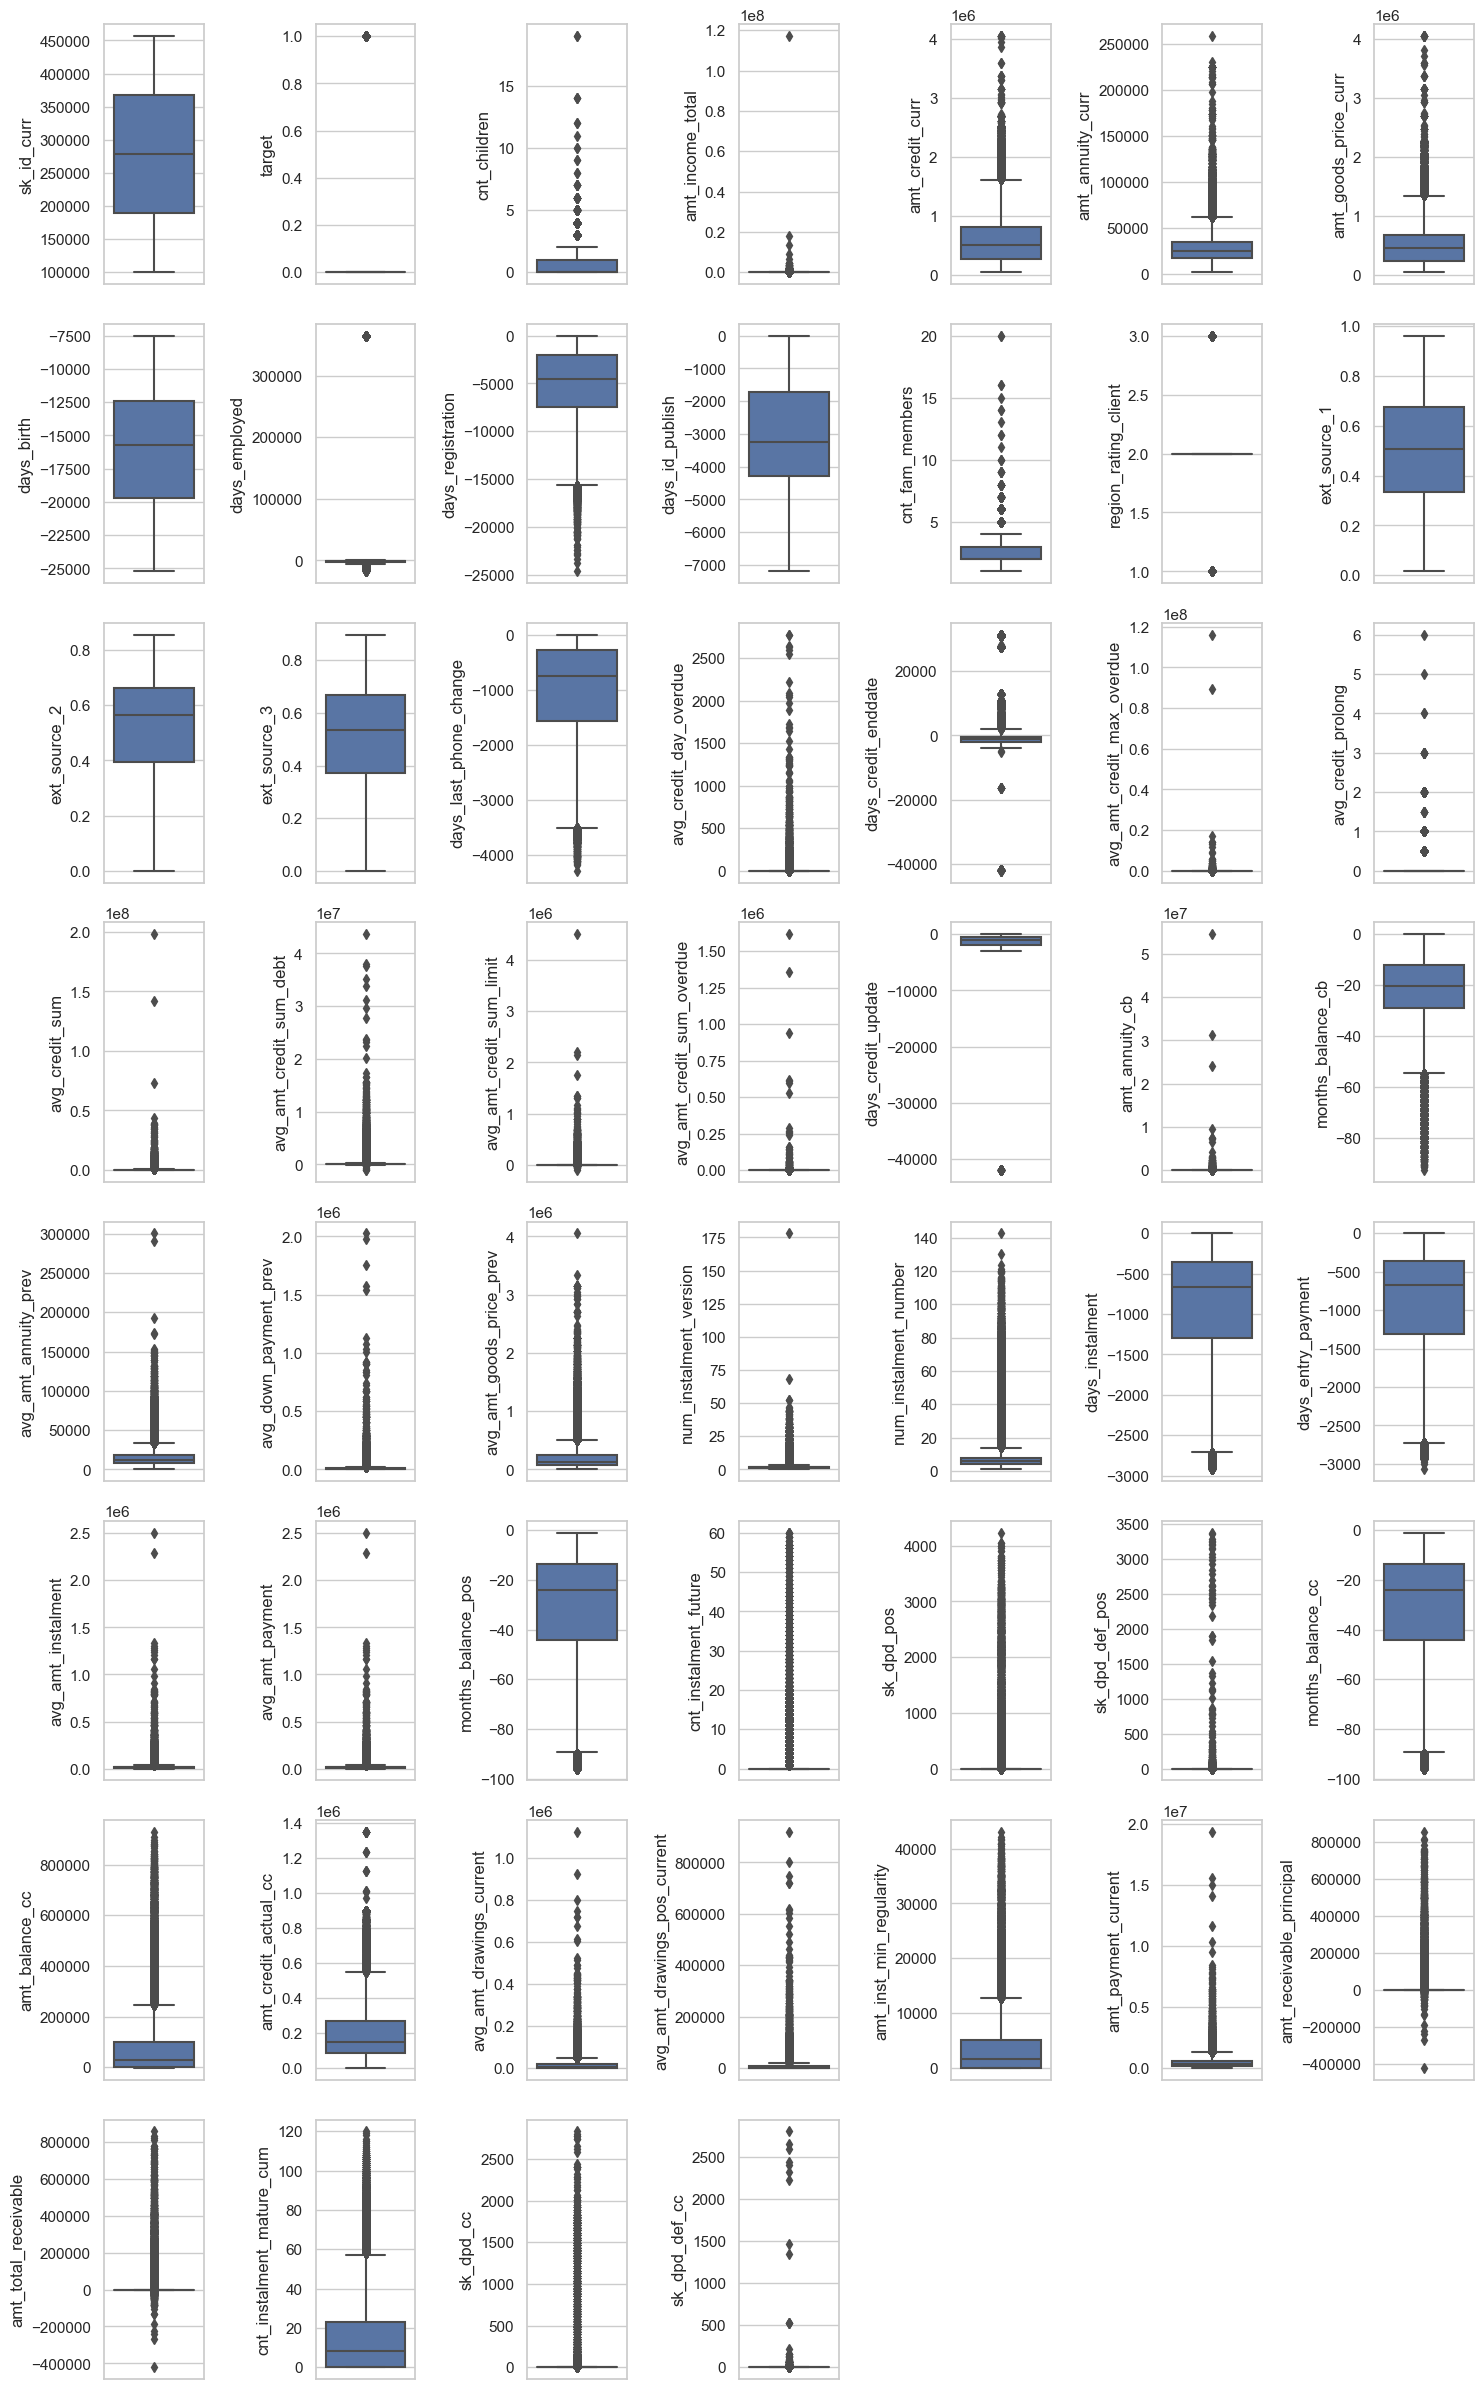

In [6]:
plt.figure(figsize=(15, 48))
for i in range(0, len(num_cols)):
    plt.subplot(16, 7, i+1)
    sns.boxplot(y=train_df[num_cols[i]], orient='v')
    plt.tight_layout()

**Summary:**
- Hampir semua kolom numerik pada dataset memiliki outliers, hanya kolom-kolom sk_id_curr, days_birth, days_id_publish, ext_source_1, ext_source_2, dan ext_source_3 saja yang tidak memiliki outliers.

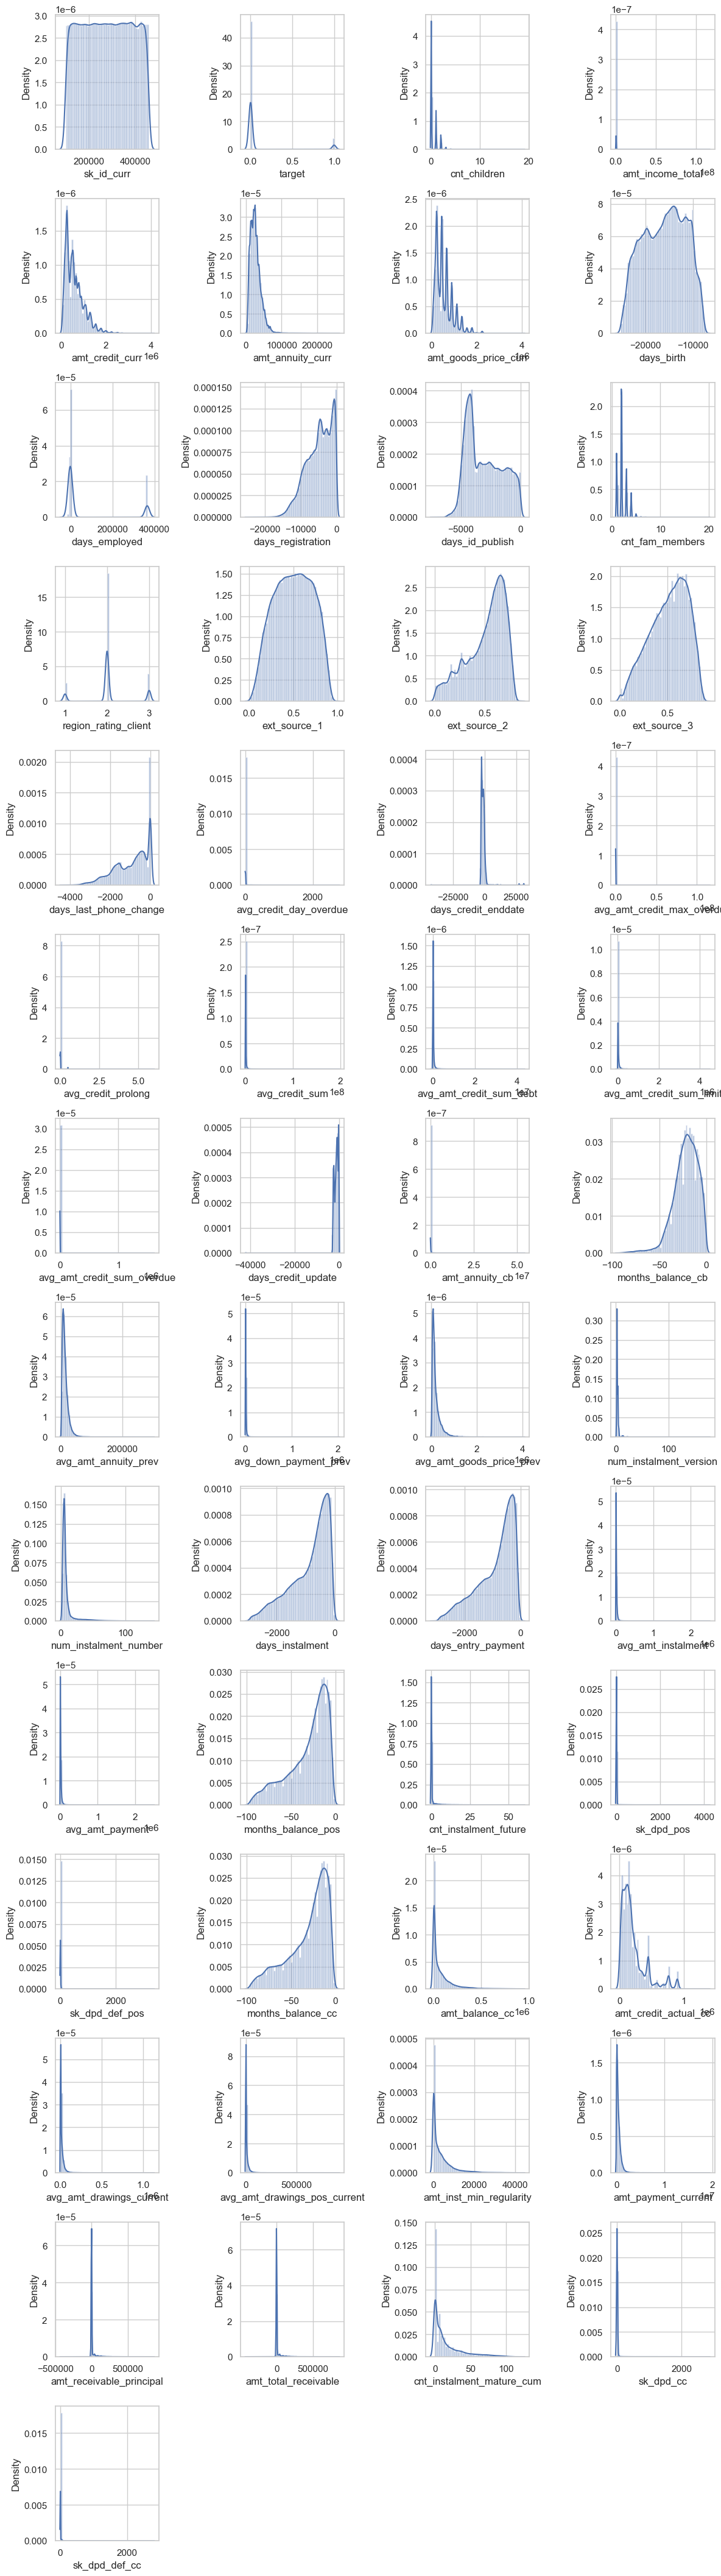

In [7]:
plt.figure(figsize=(12, 45))
for i in range(0, len(num_cols)):
    plt.subplot(15, 4, i+1)
    sns.distplot(train_df[num_cols[i]])
    plt.tight_layout()

**Summary:**
- Semua data numerik cenderung skewed, hanya sk_id_curr dan ext_source_1 saja yang terdistribusi normal.

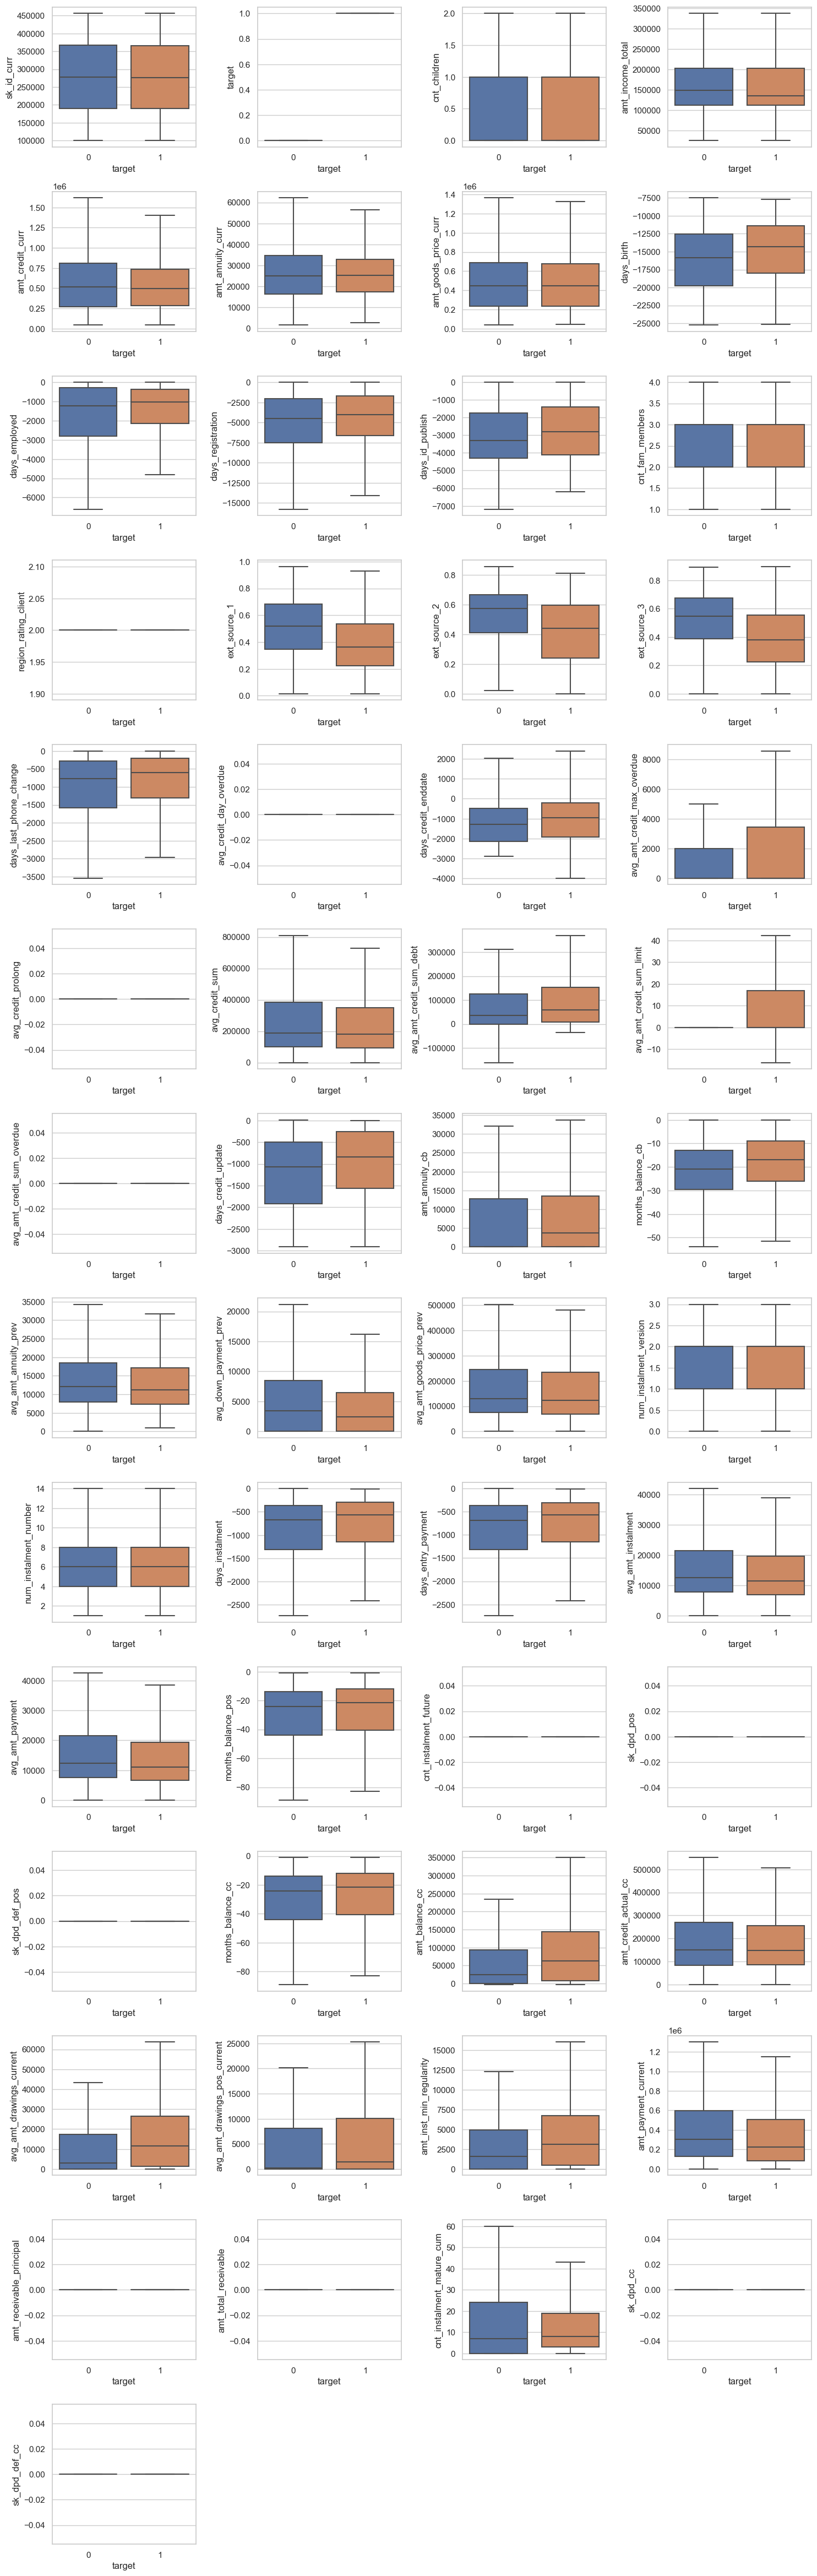

In [10]:
"""
Analysis of numerical columns involves examining the relationship between individual categorical 
features and the target variable. (Bivariate Analysis)
"""

plt.figure(figsize=(15, 90))
for i in range(0, len(num_cols)):
    plt.subplot(27, 4, i+1)
    sns.boxplot(y = train_df[num_cols[i]], x = train_df['target'], orient='v', showfliers = False)
    plt.tight_layout()

**Summary:**
- Clients dengan current credit amount dan annuity yang lebih kecil cenderung mengalami kesulitan bayar
- Clients dengan umur yang lebih muda cenderung memiliki kesulitan bayar dibandingkan clients yang lebih dewasa
- Clients yang memiliki lama waktu sebagai pegawai lebih singkat, change his registration, change the identity document, serta change phone akhir-akhir ini cenderung mengalami kesulitan bayar.
- Clients dengan score dari external score yang lebih rendah cenderung mengalami kesulitan bayar.
- 

### Business Insight

#### The Distribution of Customers Loan Status

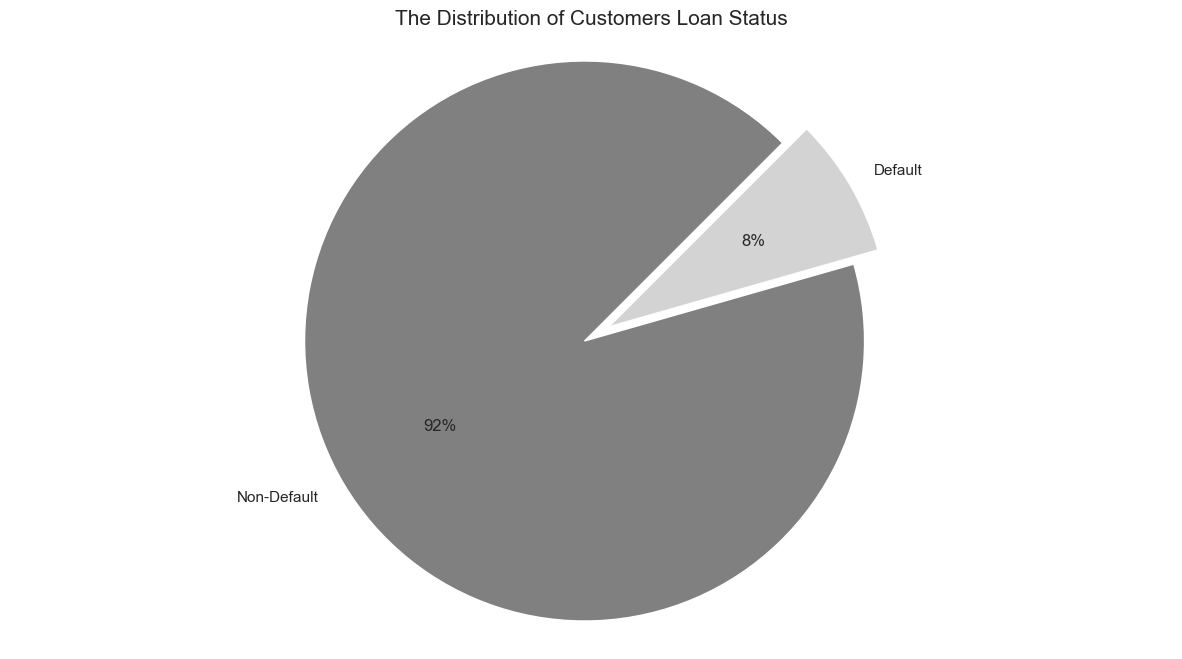

In [11]:
target_counts = train_df['target'].value_counts()
colors = ['grey', 'lightgrey']
explode = (0.1, 0)

plt.pie(target_counts, labels=['Non-Default', 'Default'], colors=colors, autopct='%1.0f%%', startangle=45, explode=explode)
plt.title('The Distribution of Customers Loan Status', fontsize=15)
plt.axis('equal')
plt.show()

**Insight:**
Loan defaults are being experienced by 8% of customers.

#### Default Rate by Gender and Income

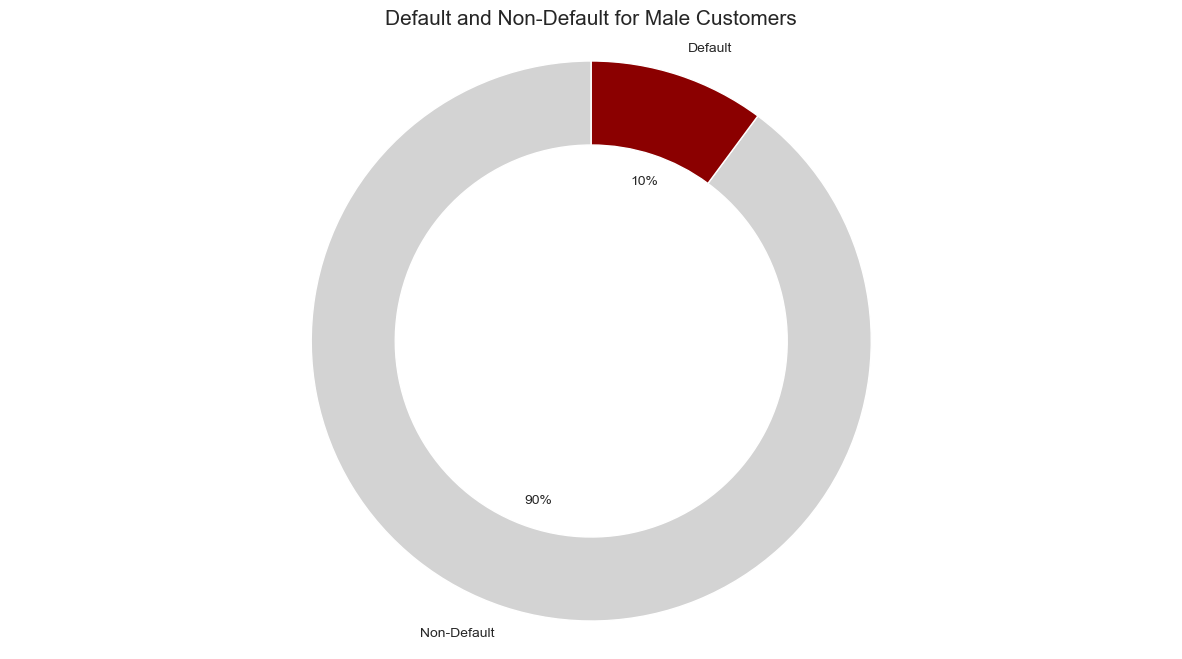

In [12]:
customer_male = train_df[train_df['code_gender'] == 'M']
target_counts = customer_male['target'].value_counts()

fig, ax = plt.subplots()
labels = ['Non-Default', 'Default']
ax.pie(target_counts, labels=labels, autopct='%1.0f%%', startangle=90,
       wedgeprops=dict(width=0.3), textprops={'fontsize': 10}, colors=['lightgrey', 'darkred'])
ax.axis('equal')  

centre_circle = plt.Circle((0, 0), 0.2, color='white', edgecolor='black', linewidth=1.25)
ax.add_artist(centre_circle)

plt.title('Default and Non-Default for Male Customers', fontsize=15)
plt.show()

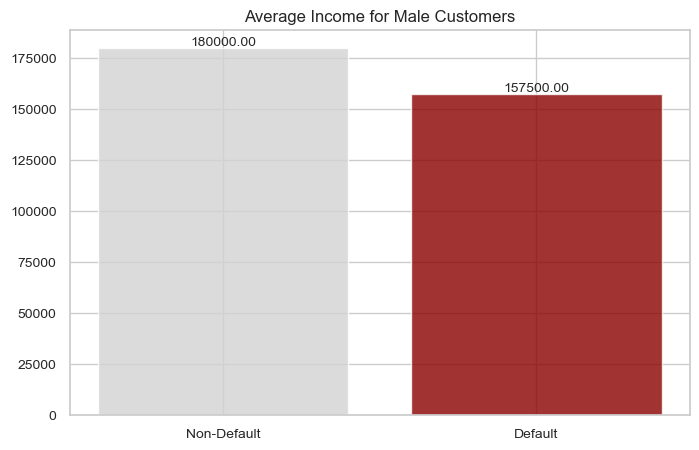

In [13]:
plt.figure(figsize=(8, 5))

customer_male = train_df[train_df['code_gender'] == 'M']

target_0 = customer_male[customer_male['target'] == 0]
target_1 = customer_male[customer_male['target'] == 1]

bar_width = 0.1
index = [0, 1]
plt.bar(index, [target_0['amt_income_total'].median(), target_1['amt_income_total'].median()],
        color=['lightgrey', 'darkred'], alpha=0.8, label='Median Amount Income')

for i, label in zip(index, [target_0['amt_income_total'].median(), target_1['amt_income_total'].median()]):
    plt.text(i, label, f'{label:.2f}', ha='center', va='bottom', fontsize=10)

#plt.ylabel('Amount Income', fontsize=12)
plt.title('Average Income for Male Customers')
plt.xticks(index, ['Non-Default', 'Default'], fontsize=10)
plt.yticks(fontsize=10)
plt.show()

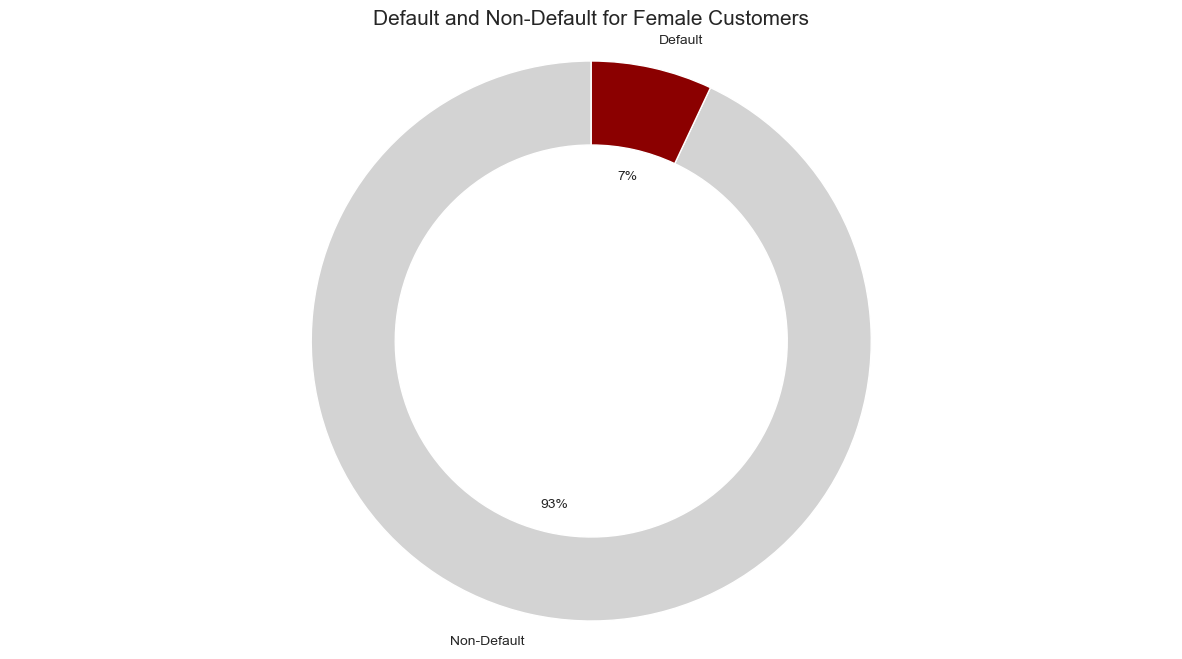

In [14]:
customer_female = train_df[train_df['code_gender'] == 'F']
target_counts = customer_female['target'].value_counts()

fig, ax = plt.subplots()
labels = ['Non-Default', 'Default']
ax.pie(target_counts, labels=labels, autopct='%1.0f%%', startangle=90,
       wedgeprops=dict(width=0.3), textprops={'fontsize': 10}, colors=['lightgrey', 'darkred'])
ax.axis('equal')  

centre_circle = plt.Circle((0, 0), 0.2, color='white', edgecolor='black', linewidth=1.25)
ax.add_artist(centre_circle)

plt.title('Default and Non-Default for Female Customers', fontsize=15)
plt.show()

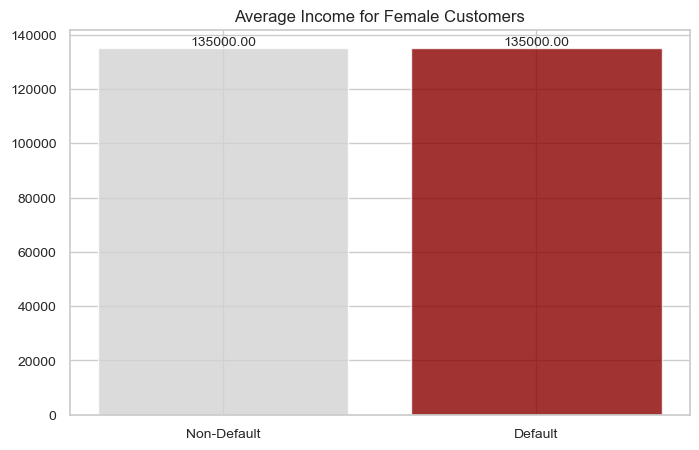

In [15]:
plt.figure(figsize=(8, 5))

customer_female = train_df[train_df['code_gender'] == 'F']

target_0 = customer_female[customer_female['target'] == 0]
target_1 = customer_female[customer_female['target'] == 1]

bar_width = 0.1
index = [0, 1]
plt.bar(index, [target_0['amt_income_total'].median(), target_1['amt_income_total'].median()],
        color=['lightgrey', 'darkred'], alpha=0.8, label='Median Amount Income')

for i, label in zip(index, [target_0['amt_income_total'].median(), target_1['amt_income_total'].median()]):
    plt.text(i, label, f'{label:.2f}', ha='center', va='bottom', fontsize=10)

#plt.ylabel('Amount Income', fontsize=12)
plt.title('Average Income for Female Customers')
plt.xticks(index, ['Non-Default', 'Default'], fontsize=10)
plt.yticks(fontsize=10)
plt.show()

**Insight:**  
Male customers have a higher default rate compared to females. Upon further analysis, it is observed that male customers facing payment difficulties tend to have a lower average income than those who do not default. In contrast, among female customers, both those experiencing payment challenges and those who do not seem to have relatively similar average incomes. This indicates that income plays a significant role in determining default tendencies for male customers, while other factors may have a more pronounced impact on female customers. 
```
As a recommendation, it may be considered that when assessing the eligibility of a loan, income becomes a crucial consideration, especially if the customer is male. If their income is high, loan approval may be considered, whereas if their income is low, the consideration to reject the loan could be made to reduce the risk of default and mitigate potential losses for the company.
```

#### Distribution of Average Score from External Data Sources

Yang akan digunakan dalam analisis hanya score dari external source 2 dan 3, karena data score dari external source 1 terlalu banyak missing valuesnya (>50%) sehingga dikhawatirkan akan menyebabkan bias jika digunakan.

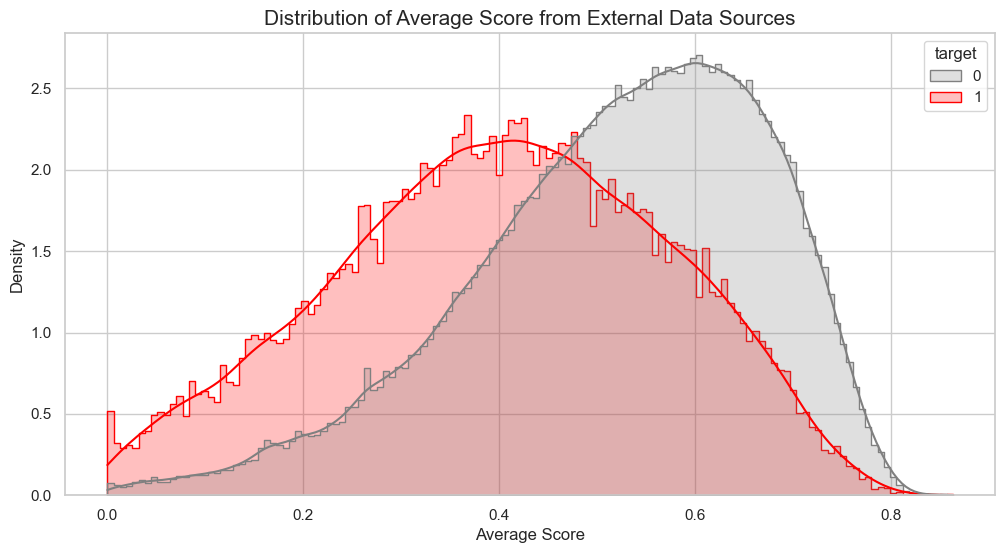

In [16]:
plt.figure(figsize=(12, 6))
train_df['avg_ext_source'] = train_df[['ext_source_2', 'ext_source_3']].mean(axis=1)
plot = sns.histplot(data=train_df, x='avg_ext_source', hue='target', element='step', common_norm=False, stat='density', kde=True,
                    palette={0: 'grey', 1: 'red'})
plt.xlabel('Average Score')
plt.ylabel('Density')
plt.title('Distribution of Average Score from External Data Sources', fontsize=15)
plt.show()

**Insight:**
Customers facing payment difficulties tend to have lower average scores from external data sources compared to those without payment difficulties.
```
As a recommendation, it is advisable to consider the external score as a crucial factor when assessing loan eligibility. If the external score is high, loan approval may be considered. Conversely, if the external score is low, rejecting the loan could be considered to minimize the risk of default and mitigate potential losses for the company.
```

**Summary:**
Rekomendasi yang didapatkan dari hasil exploratory data analysis hanya berfokus pada clients dengan jenis kelamin laki-laki juga clients dengan score dari external sources yang cenderung kecil. Sedangkan untuk clients dengan jenis kelamin perempuan dan score dari external source yang besar belum ada rekomendasinya, padahal untuk client-client tersebut juga memiliki kemungkinan gagal bayar karena adanya pengaruh dari faktor lainnya. Oleh karena itu diperlukan adanya pembuatan machine learning model untuk memprediksi lebih tepat dan akurat terkait client-client yang mungkin saja memiliki probabilitas kesulitan bayar dan dapat memberikan insight agar rekomendasi yang diberikan lebih sesuai. 

## Data Preprocessing

### Data Splitting

Data splitting is performed before other preprocessing to avoid leakage between the data used for building the model (training data) and the data used to validate the model (validating data). Data splitting is done with an 80:20 ratio between training data and validating data due to imbalnce class target, maximizing its use in constructing the model.

In [19]:
df_train, df_val = train_test_split(train_df, test_size=0.2, stratify=train_df[['target']], random_state=42)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

print(df_train.shape)
print(df_val.shape)

(246008, 73)
(61503, 73)


### Handling Missing Values

#### Drop Columns with Missing Values >50%
Kolom dengan missing values >50% didrop, karena jika dilakukan imputasi dikhawatirkan akan menyebabkan bias karena banyaknya nilai imputan.

In [24]:
# Drop column in dataset for modeling
df_train.drop(['ext_source_1', 'amt_annuity_cb', 'months_balance_cb', 'status_cb', 'amt_balance_cc', 'amt_credit_actual_cc', 'avg_amt_drawings_current', 'avg_amt_drawings_pos_current', 'amt_inst_min_regularity', 'amt_payment_current', 'amt_receivable_principal', 'amt_total_receivable', 'cnt_instalment_mature_cum', 'name_contract_status_cc', 'sk_dpd_cc', 'sk_dpd_def_cc'], axis=1, inplace=True)
df_val.drop(['ext_source_1', 'amt_annuity_cb', 'months_balance_cb', 'status_cb', 'amt_balance_cc', 'amt_credit_actual_cc', 'avg_amt_drawings_current', 'avg_amt_drawings_pos_current', 'amt_inst_min_regularity', 'amt_payment_current', 'amt_receivable_principal', 'amt_total_receivable', 'cnt_instalment_mature_cum', 'name_contract_status_cc', 'sk_dpd_cc', 'sk_dpd_def_cc'], axis=1, inplace=True)

In [32]:
# Drop column from testing dataset
df_test.drop(['ext_source_1', 'amt_annuity_cb', 'months_balance_cb', 'status_cb', 'amt_balance_cc', 'amt_credit_actual_cc', 'avg_amt_drawings_current', 'avg_amt_drawings_pos_current', 'amt_inst_min_regularity', 'amt_payment_current', 'amt_receivable_principal', 'amt_total_receivable', 'cnt_instalment_mature_cum', 'name_contract_status_cc', 'sk_dpd_cc', 'sk_dpd_def_cc'], axis=1, inplace=True)

#### Imputation using SimpleImputer for Columns with Missing Values <50%
Missing values pada kolom kategorik akan diimputasi menggunakan nilai mod, kenapa?
Missing values pada kolom numerik akan diimputasi menggunakan nilai median, karena kolom numerik pada dataset yang memiliki missing values distribusinya skewed, sehingga?

In [33]:
# Separate categorical and numerical columns in training dataset
train_cat = []
train_num = []

for a, i in df_train.items():
    if i.dtype == 'object':
        train_cat.append(a)
    else:
        train_num.append(a)

In [34]:
# Separate categorical and numerical columns in validating dataset
val_cat = []
val_num = []

for a, i in df_val.items():
    if i.dtype == 'object':
        val_cat.append(a)
    else:
        val_num.append(a)

In [35]:
# Separate categorical and numerical columns in testing dataset
test_cat = []
test_num = []

for a, i in df_test.items():
    if i.dtype == 'object':
        test_cat.append(a)
    else:
        test_num.append(a)

In [36]:
from sklearn.impute import SimpleImputer

# Impute categorical columns using mode
imput_cats = SimpleImputer(strategy='most_frequent')
df_train[train_cat] = imput_cats.fit_transform(df_train[train_cat])
df_val[val_cat] = imput_cats.fit_transform(df_val[val_cat])
df_test[test_cat] = imput_cats.fit_transform(df_test[test_cat])

# Impute numerical columns using mode
imput_nums = SimpleImputer(strategy='median')
df_train[train_num] = imput_nums.fit_transform(df_train[train_num])
df_val[val_num] = imput_nums.fit_transform(df_val[val_num])
df_test[test_num] = imput_nums.fit_transform(df_test[test_num])

In [38]:
# Check for null values in the training dataset
null_counts = df_train.isnull().sum()
if null_counts[null_counts > 0].empty:
    print("There are no null values in the training dataset.")
else:
    print("Columns with null values and their counts:")
    print(null_counts[null_counts > 0])

There are no null values in the training dataset.


In [39]:
# Check for null values in the validating dataset
null_counts = df_val.isnull().sum()
if null_counts[null_counts > 0].empty:
    print("There are no null values in the validating dataset.")
else:
    print("Columns with null values and their counts:")
    print(null_counts[null_counts > 0])

There are no null values in the validating dataset.


In [41]:
# Check for null values in the testing dataset
null_counts = df_test.isnull().sum()
if null_counts[null_counts > 0].empty:
    print("There are no null values in the testing dataset.")
else:
    print("Columns with null values and their counts:")
    print(null_counts[null_counts > 0])

There are no null values in the testing dataset.


### Handling Duplicated Values

In [42]:
# Handling duplicated values in the training dataset
print("Number of rows before removing duplicates:", len(df_train))
print("Number of rows after removing duplicates:", len(df_train.drop_duplicates()))

Number of rows before removing duplicates: 246008
Number of rows after removing duplicates: 246008


In [43]:
# Handling duplicated values in the validating dataset
print("Number of rows before removing duplicates:", len(df_val))
print("Number of rows after removing duplicates:", len(df_val.drop_duplicates()))

Number of rows before removing duplicates: 61503
Number of rows after removing duplicates: 61503


In [44]:
# Handling duplicated values in the testing dataset
print("Number of rows before removing duplicates:", len(df_test))
print("Number of rows after removing duplicates:", len(df_test.drop_duplicates()))

Number of rows before removing duplicates: 48744
Number of rows after removing duplicates: 48744


**Summary:**
The datasets contain no duplicates, so there is no need to handle duplicated values.

### Handling Invalid Values

In [46]:
# Check unique values

for x in df_train[train_cat].columns :
    uniq = list(df_train[x].unique())
    uniq.sort()

    print (f'Column {x}:')
    if len(uniq) > 0:
        unq = list(uniq[:])
        print (f'{uniq}')
    else:
        print (f'{uniq}')
    print("--" * 50, end='\n\n')

Column name_contract_type_curr:
['Cash loans', 'Revolving loans']
----------------------------------------------------------------------------------------------------

Column code_gender:
['F', 'M', 'XNA']
----------------------------------------------------------------------------------------------------

Column flag_own_car:
['N', 'Y']
----------------------------------------------------------------------------------------------------

Column flag_own_realty:
['N', 'Y']
----------------------------------------------------------------------------------------------------

Column name_income_type:
['Businessman', 'Commercial associate', 'Maternity leave', 'Pensioner', 'State servant', 'Student', 'Unemployed', 'Working']
----------------------------------------------------------------------------------------------------

Column name_education_type:
['Academic degree', 'Higher education', 'Incomplete higher', 'Lower secondary', 'Secondary / secondary special']
----------------------------

**Includes:**
- Mengganti data XNA pada kolom gender dengan F, karena XNA diduga merupakan denote for NA values sehingga diubah dengan mode.
- Menyederhanakan kategori pada kolom education type, dimana Incomplete higher, Higher education, dan Academic degree digabung menjadi Above secondary karena merupakan tingkat pendidikan setelah secondary. Untuk kategori Secondary / secondary special juga diubah menjadi Secondary agar lebih terstruktur dan sesuai dengan kategori yang lain.
- Kategori pada kolom name_family status disederhanakan untuk data Civil marriage, Separated, dan Unknown dimana digabungkan dengan Married, hal ini dikarenakan clients dengan status Civil marriage dan Separated memang dalam pernikahan, sedangkan untuk Unknown dianggap sebagai NA sehingga diganti dengan mode.
- Kategori pada kolom organization_type disederhanakan dengan menggabung beberapa data yang sama menjadi 1 kategori. Selain itu untuk data XNA diubah menjadi Other dengan asumsi bahwa clients dengan nilai XNA memiliki organization type di luar yang disediakan.
- Mengganti kategori Unknown type of loan menjadi Another type of loan pada kolom credit_type dengan asumsi bahwa clients tersebut memilih kredit selain credit type yang disediakan.
- Mengganti kategori XNA dalam kolom name_contract_type menjadi Consumer loans, karena XNA diduga merupakan denote for NA values sehingga diubah dengan mode.
- Mengganti kategori XNA pada kolom name_portfolio_prev diubah menjadi Other dengan asumsi bahwa clients dengan nilai XNA di the previous application menggunakan loans untuk tujuan selain yang disediakan.
- Membulatkan values pada kolom avg_credit_day_overdue, avg_credit_prolong, num_instalment_number, months_balance_pos, dan months_balance_cc karena datanya seharusnya dalam satuan, sehingga perlu dibulatkan.
- Mengganti tipe data pada kolom target menjadi integer, karena berisi binary values (0 dan 1).

#### Handling Invalid Values in The Training Dataset

In [47]:
import math

In [49]:
# Replacing values in the code_gender column
df_train['code_gender'] = df_train['code_gender'].replace({'XNA': 'F'})

# Replacing values in the name_education_type column
df_train['name_education_type'] = df_train['name_education_type'].replace({
    'Higher education': 'Above secondary',
    'Incomplete higher': 'Above secondary',
    'Academic degree': 'Above secondary',
    'Secondary / secondary special': 'Secondary'
})

# Replacing values in the name_family_status column
df_train['name_family_status'] = df_train['name_family_status'].replace({
    'Civil marriage': 'Married',
    'Separated': 'Married',
    'Unknown': 'Married'
})

# Replacing values in the organization_type column
df_train['organization_type'] = df_train['organization_type'].replace({
    'Business Entity Type 1': 'Business entity',
    'Business Entity Type 2': 'Business entity',
    'Business Entity Type 3': 'Business entity',
    'Trade: type 1': 'Trade',
    'Trade: type 2': 'Trade',
    'Trade: type 3': 'Trade',
    'Trade: type 4': 'Trade',
    'Trade: type 5': 'Trade',
    'Trade: type 6': 'Trade',
    'Trade: type 7': 'Trade',
    'Industry: type 1': 'Industry',
    'Industry: type 2': 'Industry',
    'Industry: type 3': 'Industry',
    'Industry: type 4': 'Industry',
    'Industry: type 5': 'Industry',
    'Industry: type 6': 'Industry',
    'Industry: type 7': 'Industry',
    'Industry: type 8': 'Industry',
    'Industry: type 9': 'Industry',
    'Industry: type 10': 'Industry',
    'Industry: type 11': 'Industry',
    'Industry: type 12': 'Industry',
    'Industry: type 13': 'Industry',
    'Transport: type 1': 'Transport',
    'Transport: type 2': 'Transport',
    'Transport: type 3': 'Transport', 
    'Transport: type 4': 'Transport',
    'XNA': 'Other'
})

# Replacing values in the credit_type column
df_train['credit_type'] = df_train['credit_type'].replace({'Unknown type of loan': 'Another type of loan'})

# Replacing values in the name_contract_type_prev column
df_train['name_contract_type_prev'] = df_train['name_contract_type_prev'].replace({'XNA': 'Consumer loans'})

# Replacing values in the name_portfolio_prev column
df_train['name_portfolio_prev'] = df_train['name_portfolio_prev'].replace({'XNA': 'Other'})

# Membulatkan values pada kolom avg_credit_day_overdue, avg_credit_prolong, num_instalment_number, months_balance_pos, dan months_balance_cc
df_train['avg_credit_day_overdue'] = df_train['avg_credit_day_overdue'].apply(lambda x: math.ceil(x) if x % 1 > 0 else x)
df_train['avg_credit_prolong'] = df_train['avg_credit_prolong'].apply(lambda x: math.ceil(x) if x % 1 > 0 else x)
df_train['num_instalment_number'] = df_train['num_instalment_number'].apply(lambda x: math.ceil(x) if x % 1 > 0 else x)
df_train['months_balance_pos'] = df_train['months_balance_pos'].apply(lambda x: math.ceil(x) if x % 1 > 0 else x)
df_train['months_balance_cc'] = df_train['months_balance_cc'].apply(lambda x: math.ceil(x) if x % 1 > 0 else x)

# Change data type target column to integer
df_train['target'] = df_train['target'].astype(int)

#### Handling Invalid Values in The Validating Dataset

In [51]:
# Replacing values in the code_gender column
df_val['code_gender'] = df_val['code_gender'].replace({'XNA': 'F'})

# Replacing values in the name_education_type column
df_val['name_education_type'] = df_val['name_education_type'].replace({
    'Higher education': 'Above secondary',
    'Incomplete higher': 'Above secondary',
    'Academic degree': 'Above secondary',
    'Secondary / secondary special': 'Secondary'
})

# Replacing values in the name_family_status column
df_val['name_family_status'] = df_val['name_family_status'].replace({
    'Civil marriage': 'Married',
    'Separated': 'Married',
    'Unknown': 'Married'
})

# Replacing values in the organization_type column
df_val['organization_type'] = df_val['organization_type'].replace({
    'Business Entity Type 1': 'Business entity',
    'Business Entity Type 2': 'Business entity',
    'Business Entity Type 3': 'Business entity',
    'Trade: type 1': 'Trade',
    'Trade: type 2': 'Trade',
    'Trade: type 3': 'Trade',
    'Trade: type 4': 'Trade',
    'Trade: type 5': 'Trade',
    'Trade: type 6': 'Trade',
    'Trade: type 7': 'Trade',
    'Industry: type 1': 'Industry',
    'Industry: type 2': 'Industry',
    'Industry: type 3': 'Industry',
    'Industry: type 4': 'Industry',
    'Industry: type 5': 'Industry',
    'Industry: type 6': 'Industry',
    'Industry: type 7': 'Industry',
    'Industry: type 8': 'Industry',
    'Industry: type 9': 'Industry',
    'Industry: type 10': 'Industry',
    'Industry: type 11': 'Industry',
    'Industry: type 12': 'Industry',
    'Industry: type 13': 'Industry',
    'Transport: type 1': 'Transport',
    'Transport: type 2': 'Transport',
    'Transport: type 3': 'Transport', 
    'Transport: type 4': 'Transport',
    'XNA': 'Other'
})

# Replacing values in the credit_type column
df_val['credit_type'] = df_val['credit_type'].replace({'Unknown type of loan': 'Another type of loan'})

# Replacing values in the name_contract_type_prev column
df_val['name_contract_type_prev'] = df_val['name_contract_type_prev'].replace({'XNA': 'Consumer loans'})

# Replacing values in the name_portfolio_prev column
df_val['name_portfolio_prev'] = df_val['name_portfolio_prev'].replace({'XNA': 'Other'})

# Membulatkan values pada kolom avg_credit_day_overdue, avg_credit_prolong, num_instalment_number, months_balance_pos, dan months_balance_cc
df_val['avg_credit_day_overdue'] = df_val['avg_credit_day_overdue'].apply(lambda x: math.ceil(x) if x % 1 > 0 else x)
df_val['avg_credit_prolong'] = df_val['avg_credit_prolong'].apply(lambda x: math.ceil(x) if x % 1 > 0 else x)
df_val['num_instalment_number'] = df_val['num_instalment_number'].apply(lambda x: math.ceil(x) if x % 1 > 0 else x)
df_val['months_balance_pos'] = df_val['months_balance_pos'].apply(lambda x: math.ceil(x) if x % 1 > 0 else x)
df_val['months_balance_cc'] = df_val['months_balance_cc'].apply(lambda x: math.ceil(x) if x % 1 > 0 else x)

# Change data type target column to integer
df_val['target'] = df_val['target'].astype(int)

#### Handling Invalid Values in The Testing Dataset

In [53]:
# Replacing values in the code_gender column
df_test['code_gender'] = df_test['code_gender'].replace({'XNA': 'F'})

# Replacing values in the name_education_type column
df_test['name_education_type'] = df_test['name_education_type'].replace({
    'Higher education': 'Above secondary',
    'Incomplete higher': 'Above secondary',
    'Academic degree': 'Above secondary',
    'Secondary / secondary special': 'Secondary'
})

# Replacing values in the name_family_status column
df_test['name_family_status'] = df_test['name_family_status'].replace({
    'Civil marriage': 'Married',
    'Separated': 'Married',
    'Unknown': 'Married'
})

# Replacing values in the organization_type column
df_test['organization_type'] = df_test['organization_type'].replace({
    'Business Entity Type 1': 'Business entity',
    'Business Entity Type 2': 'Business entity',
    'Business Entity Type 3': 'Business entity',
    'Trade: type 1': 'Trade',
    'Trade: type 2': 'Trade',
    'Trade: type 3': 'Trade',
    'Trade: type 4': 'Trade',
    'Trade: type 5': 'Trade',
    'Trade: type 6': 'Trade',
    'Trade: type 7': 'Trade',
    'Industry: type 1': 'Industry',
    'Industry: type 2': 'Industry',
    'Industry: type 3': 'Industry',
    'Industry: type 4': 'Industry',
    'Industry: type 5': 'Industry',
    'Industry: type 6': 'Industry',
    'Industry: type 7': 'Industry',
    'Industry: type 8': 'Industry',
    'Industry: type 9': 'Industry',
    'Industry: type 10': 'Industry',
    'Industry: type 11': 'Industry',
    'Industry: type 12': 'Industry',
    'Industry: type 13': 'Industry',
    'Transport: type 1': 'Transport',
    'Transport: type 2': 'Transport',
    'Transport: type 3': 'Transport', 
    'Transport: type 4': 'Transport',
    'XNA': 'Other'
})

# Replacing values in the credit_type column
df_test['credit_type'] = df_test['credit_type'].replace({'Unknown type of loan': 'Another type of loan'})

# Replacing values in the name_contract_type_prev column
df_test['name_contract_type_prev'] = df_test['name_contract_type_prev'].replace({'XNA': 'Consumer loans'})

# Replacing values in the name_portfolio_prev column
df_test['name_portfolio_prev'] = df_test['name_portfolio_prev'].replace({'XNA': 'Other'})

# Membulatkan values pada kolom avg_credit_day_overdue, avg_credit_prolong, num_instalment_number, months_balance_pos, dan months_balance_cc
df_test['avg_credit_day_overdue'] = df_test['avg_credit_day_overdue'].apply(lambda x: math.ceil(x) if x % 1 > 0 else x)
df_test['avg_credit_prolong'] = df_test['avg_credit_prolong'].apply(lambda x: math.ceil(x) if x % 1 > 0 else x)
df_test['num_instalment_number'] = df_test['num_instalment_number'].apply(lambda x: math.ceil(x) if x % 1 > 0 else x)
df_test['months_balance_pos'] = df_test['months_balance_pos'].apply(lambda x: math.ceil(x) if x % 1 > 0 else x)
df_test['months_balance_cc'] = df_test['months_balance_cc'].apply(lambda x: math.ceil(x) if x % 1 > 0 else x)

#### Drop Unnecessary Columns
Kolom code_reject_reason_prev dihapus karena tidak ada keterangan datanya sehingga cukup sulit untuk dipahami, jika tetap digunakan dikhawatirkan akan menyebabkan mispersepsi. Adapun kolom name_contract_status_prev sudah mewakili untuk menunjukkan terkait status clients pada loans sebelumnya.

In [57]:
df_train.drop(['code_reject_reason_prev'], axis=1, inplace=True)
df_val.drop(['code_reject_reason_prev'], axis=1, inplace=True)
df_test.drop(['code_reject_reason_prev'], axis=1, inplace=True)

### Feature Extraction

1. <b>age Column</b>, which represents the clients age at the time of application loans, is calculated by membagi days birth values dengan 365 (jumlah hari dalam setahun).

In [54]:
df_train['age'] = df_train['days_birth'] // 365
df_val['age'] = df_val['days_birth'] // 365
df_test['age'] = df_test['days_birth'] // 365

2. <b>avg_ext_source</b>, yang merepresentasikan rata-rata score dari external sources.

In [55]:
df_train['avg_ext_source'] = df_train[['ext_source_2', 'ext_source_3']].mean(axis=1)
df_val['avg_ext_source'] = df_val[['ext_source_2', 'ext_source_3']].mean(axis=1)
df_test['avg_ext_source'] = df_test[['ext_source_2', 'ext_source_3']].mean(axis=1)

#### Drop Unnecessary Columns
Kolom days_birth, ext_source_2, dan ext_source_3 didrop karena valuenya sudah diextract dalam kolom age dan avg_ext_source

In [58]:
df_train.drop(['days_birth', 'ext_source_2', 'ext_source_3'], axis=1, inplace=True)
df_val.drop(['days_birth', 'ext_source_2', 'ext_source_3'], axis=1, inplace=True)
df_test.drop(['days_birth', 'ext_source_2', 'ext_source_3'], axis=1, inplace=True)

### Handling Outliers

In [59]:
train_out = df_train.copy()
val_out = df_val.copy()
test_out = df_test.copy()

In [62]:
test_out.sample()

sk_id_curr name_contract_type_curr code_gender flag_own_car  \
35745   361603.00              Cash loans           F            N   

      flag_own_realty  cnt_children  amt_income_total  amt_credit_curr  \
35745               N          0.00         315000.00       1800000.00   

       amt_annuity_curr  amt_goods_price_curr name_income_type  \
35745          56002.50            1800000.00          Working   

      name_education_type name_family_status  name_housing_type  \
35745     Above secondary            Married  House / apartment   

       days_employed  days_registration  days_id_publish occupation_type  \
35745        -910.00           -3840.00         -3206.00        Managers   

       cnt_fam_members  region_rating_client organization_type  \
35745             2.00                  2.00             Other   

       days_last_phone_change credit_bureau_active  avg_credit_day_overdue  \
35745                 -608.00               Closed                    0.00   

       days_credit_enddate  avg_amt_credit_max_overdue  avg_credit_prolong  \
35745             -2603.00                        0.00                0.00   

       avg_credit_sum  avg_amt_credit_sum_debt  avg_amt_credit_sum_limit  \
35745       140927.48                 81569.87                      0.00   

       avg_amt_credit_sum_overdue      credit_type  days_credit_update  \
35745                        0.00  Consumer credit            -2032.00   

      name_contract_type_prev  avg_amt_annuity_prev  avg_down_payment_prev  \
35745          Consumer loans               1577.79                   0.00   

       avg_amt_goods_price_prev name_contract_status_prev name_portfolio_prev  \
35745                  22495.50                  Approved                 POS   

       num_instalment_version  num_instalment_number  days_instalment  \
35745                    2.00                   6.00          -425.00   

       days_entry_payment  avg_amt_instalment  avg_amt_payment  \
35745             -454.00             2813.47          2692.10   

       months_balance_pos  cnt_instalment_future name_contract_status_pos  \
35745              -13.00                   0.00                   Active   

       sk_dpd_pos  sk_dpd_def_pos  months_balance_cc    age  avg_ext_source  
35745        1.00            1.00             -13.00 -32.00            0.53

In [160]:
outliers = ['cnt_children', 'amt_income_total', 'amt_credit_curr', 'amt_annuity_curr', 'amt_goods_price_curr', 'cnt_fam_members', 'avg_amt_credit_max_overdue', 'avg_credit_prolong', 'avg_credit_sum', 'avg_amt_credit_sum_debt', 'avg_amt_credit_sum_limit', 'avg_amt_credit_sum_overdue', 'avg_amt_annuity_prev', 'avg_down_payment_prev', 'avg_amt_goods_price_prev', 'num_instalment_version', 'num_instalment_number', 'avg_amt_instalment', 'avg_amt_payment', 'months_balance_pos', 'months_balance_cc', 'duration_of_employment', 'years_credit_update', 'avg_ext_source', 'years_credit_enddate']

In [86]:
from scipy import stats

outlier_columns = ['cnt_children', 'amt_income_total', 'amt_credit_curr', 'amt_annuity_curr', 'amt_goods_price_curr', 'cnt_fam_members', 'avg_amt_credit_max_overdue', 'avg_credit_prolong', 'avg_credit_sum', 'avg_amt_credit_sum_debt', 'avg_amt_credit_sum_limit', 'avg_amt_credit_sum_overdue', 'avg_amt_annuity_prev', 'avg_down_payment_prev', 'avg_amt_goods_price_prev', 'num_instalment_version', 'num_instalment_number', 'avg_amt_instalment', 'avg_amt_payment', 'months_balance_pos', 'months_balance_cc', 'days_employed', 'days_credit_update', 'ext_source_2', 'ext_source_3', 'days_credit_enddate']

train_zscore = train_1.copy()
print(f'The number of rows before filtering out the outliers using Z-Score: {len(train_zscore)}')
zscore = np.abs(stats.zscore(train_zscore[outlier_columns]))
outliers = (zscore > 3).any(axis=1)
train_zscore = train_zscore[~outliers]
print(f'The number of rows after filtering out the outliers using Z-Score: {len(train_zscore)}')

The number of rows before filtering out the outliers using Z-Score: 215257
The number of rows after filtering out the outliers using Z-Score: 183202


In [87]:
test_zscore = test_1.copy()
print(f'The number of rows before filtering out the outliers using Z-Score: {len(test_zscore)}')
zscore = np.abs(stats.zscore(test_zscore[outlier_columns]))
outliers = (zscore > 3).any(axis=1)
test_zscore = test_zscore[~outliers]
print(f'The number of rows after filtering out the outliers using Z-Score: {len(test_zscore)}')

The number of rows before filtering out the outliers using Z-Score: 92254
The number of rows after filtering out the outliers using Z-Score: 78306


### Feature Scaling

In [66]:
scaling_columns = ['cnt_children', 'amt_income_total', 'amt_credit_curr', 'amt_annuity_curr', 
                   'amt_goods_price_curr', 'days_employed', 'days_registration', 'days_id_publish', 
                   'cnt_fam_members', 'days_last_phone_change', 'avg_credit_day_overdue', 
                   'days_credit_enddate', 'avg_amt_credit_max_overdue', 'avg_credit_prolong', 
                   'avg_credit_sum', 'avg_amt_credit_sum_debt', 'avg_amt_credit_sum_limit', 
                   'avg_amt_credit_sum_overdue', 'days_credit_update', 'avg_amt_annuity_prev', 
                   'avg_down_payment_prev', 'avg_amt_goods_price_prev', 'num_instalment_version', 
                   'num_instalment_number', 'days_instalment', 'days_entry_payment', 
                   'avg_amt_instalment', 'avg_amt_payment', 'months_balance_pos', 
                   'cnt_instalment_future', 'sk_dpd_pos', 'sk_dpd_def_pos', 'months_balance_cc', 
                   'age', 'avg_ext_source']

In [63]:
train_scal = df_train.copy()
val_scal = df_val.copy()
test_scal = df_test.copy()

In [78]:
df_train = train_scal.copy()
df_val = val_scal.copy()
df_test = test_scal.copy()

#### Yeo-Johnson Transformation

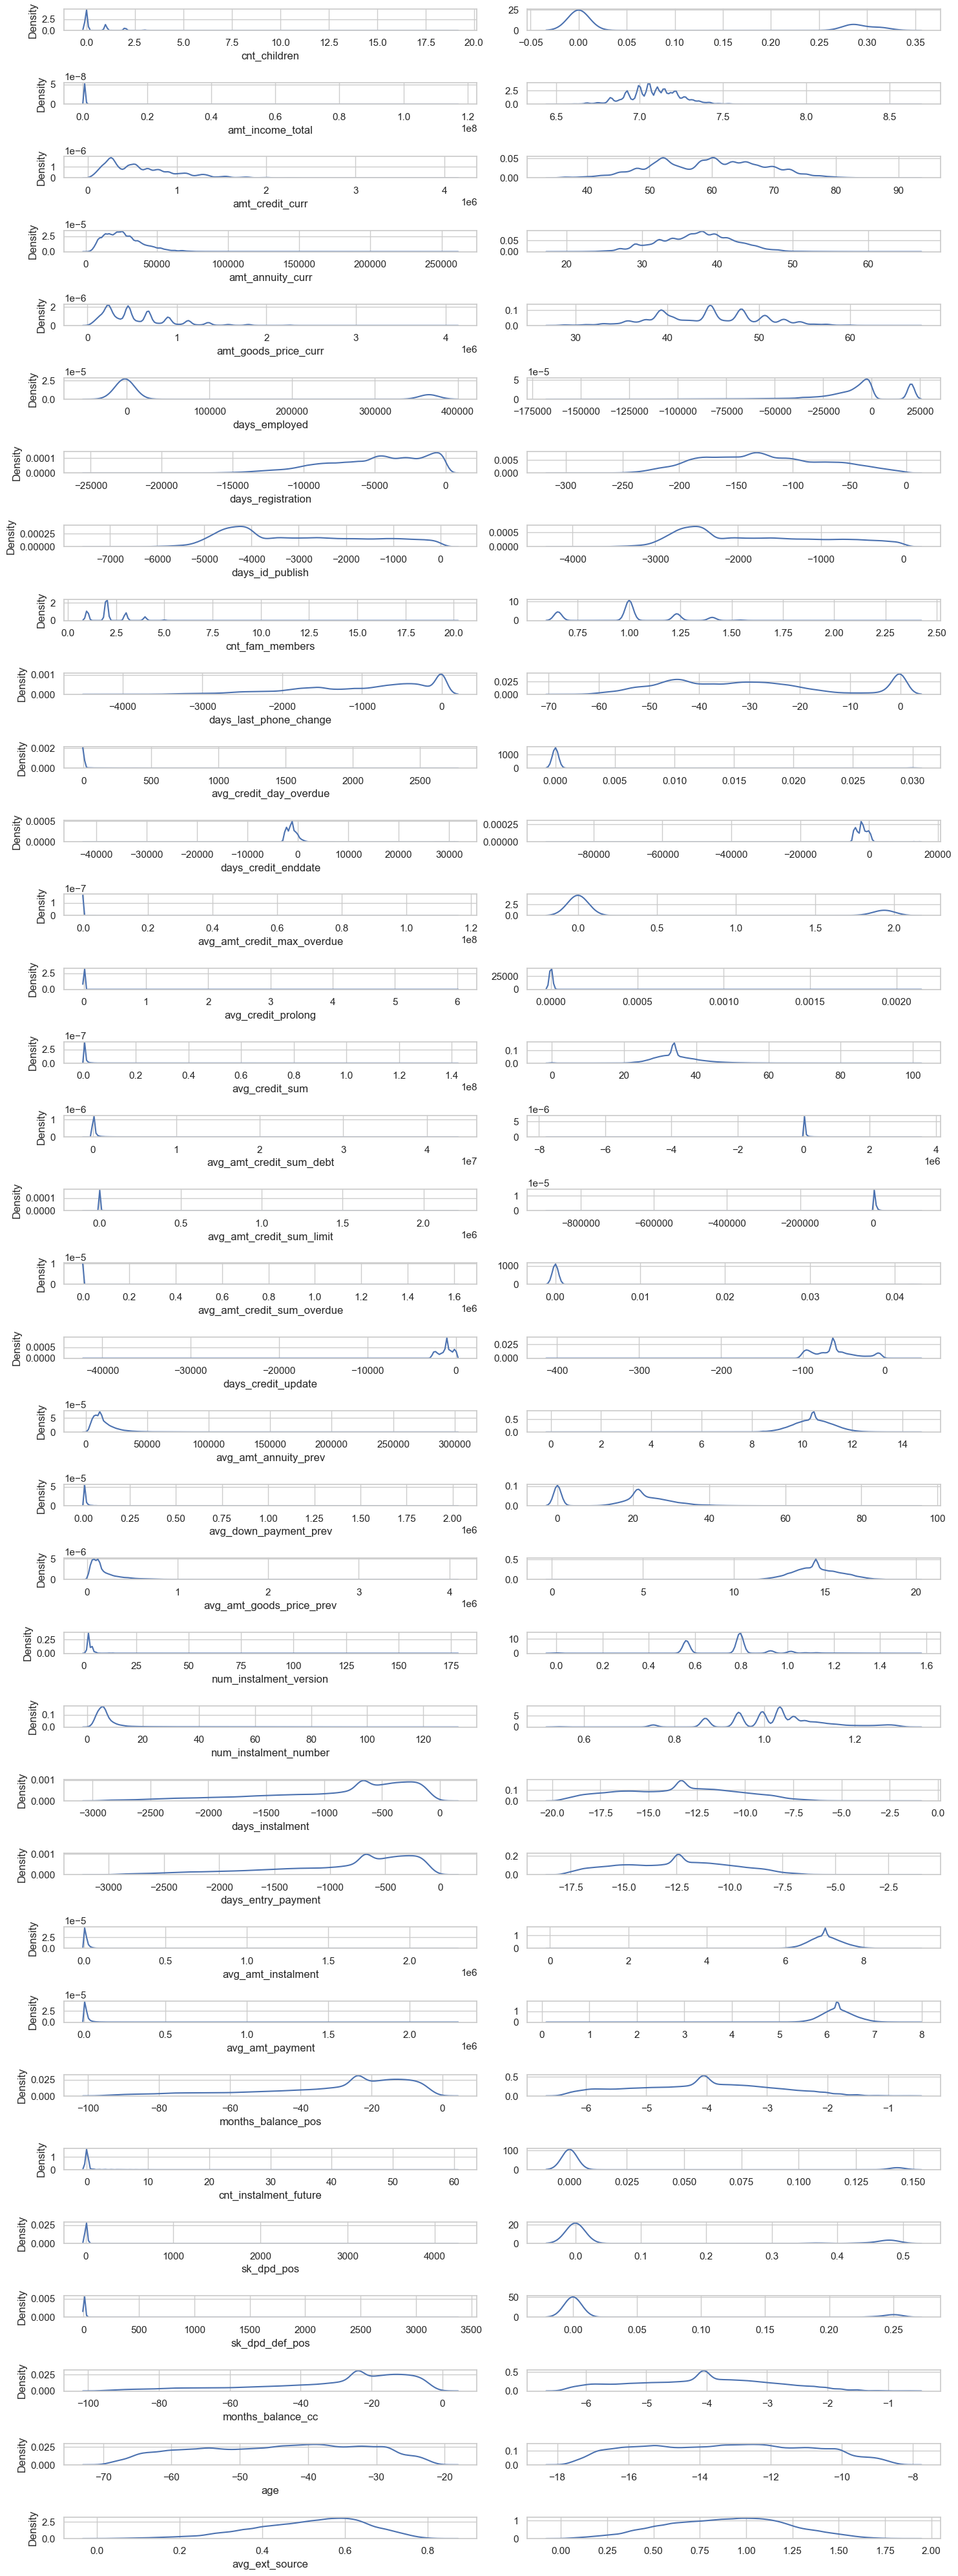

In [79]:
from scipy.stats import yeojohnson

fig, ax = plt.subplots(len(scaling_columns), 2, figsize=(15, 40))
for i in range(0, len(scaling_columns)):
    data, fitted_lambda = yeojohnson(df_train[scaling_columns[i]], lmbda=None)
    kde1 = sns.kdeplot(df_train[scaling_columns[i]], ax=ax[i][0])
    kde2 = sns.kdeplot(data, ax=ax[i][1])
    kde2.set_ylabel(None)

plt.tight_layout()

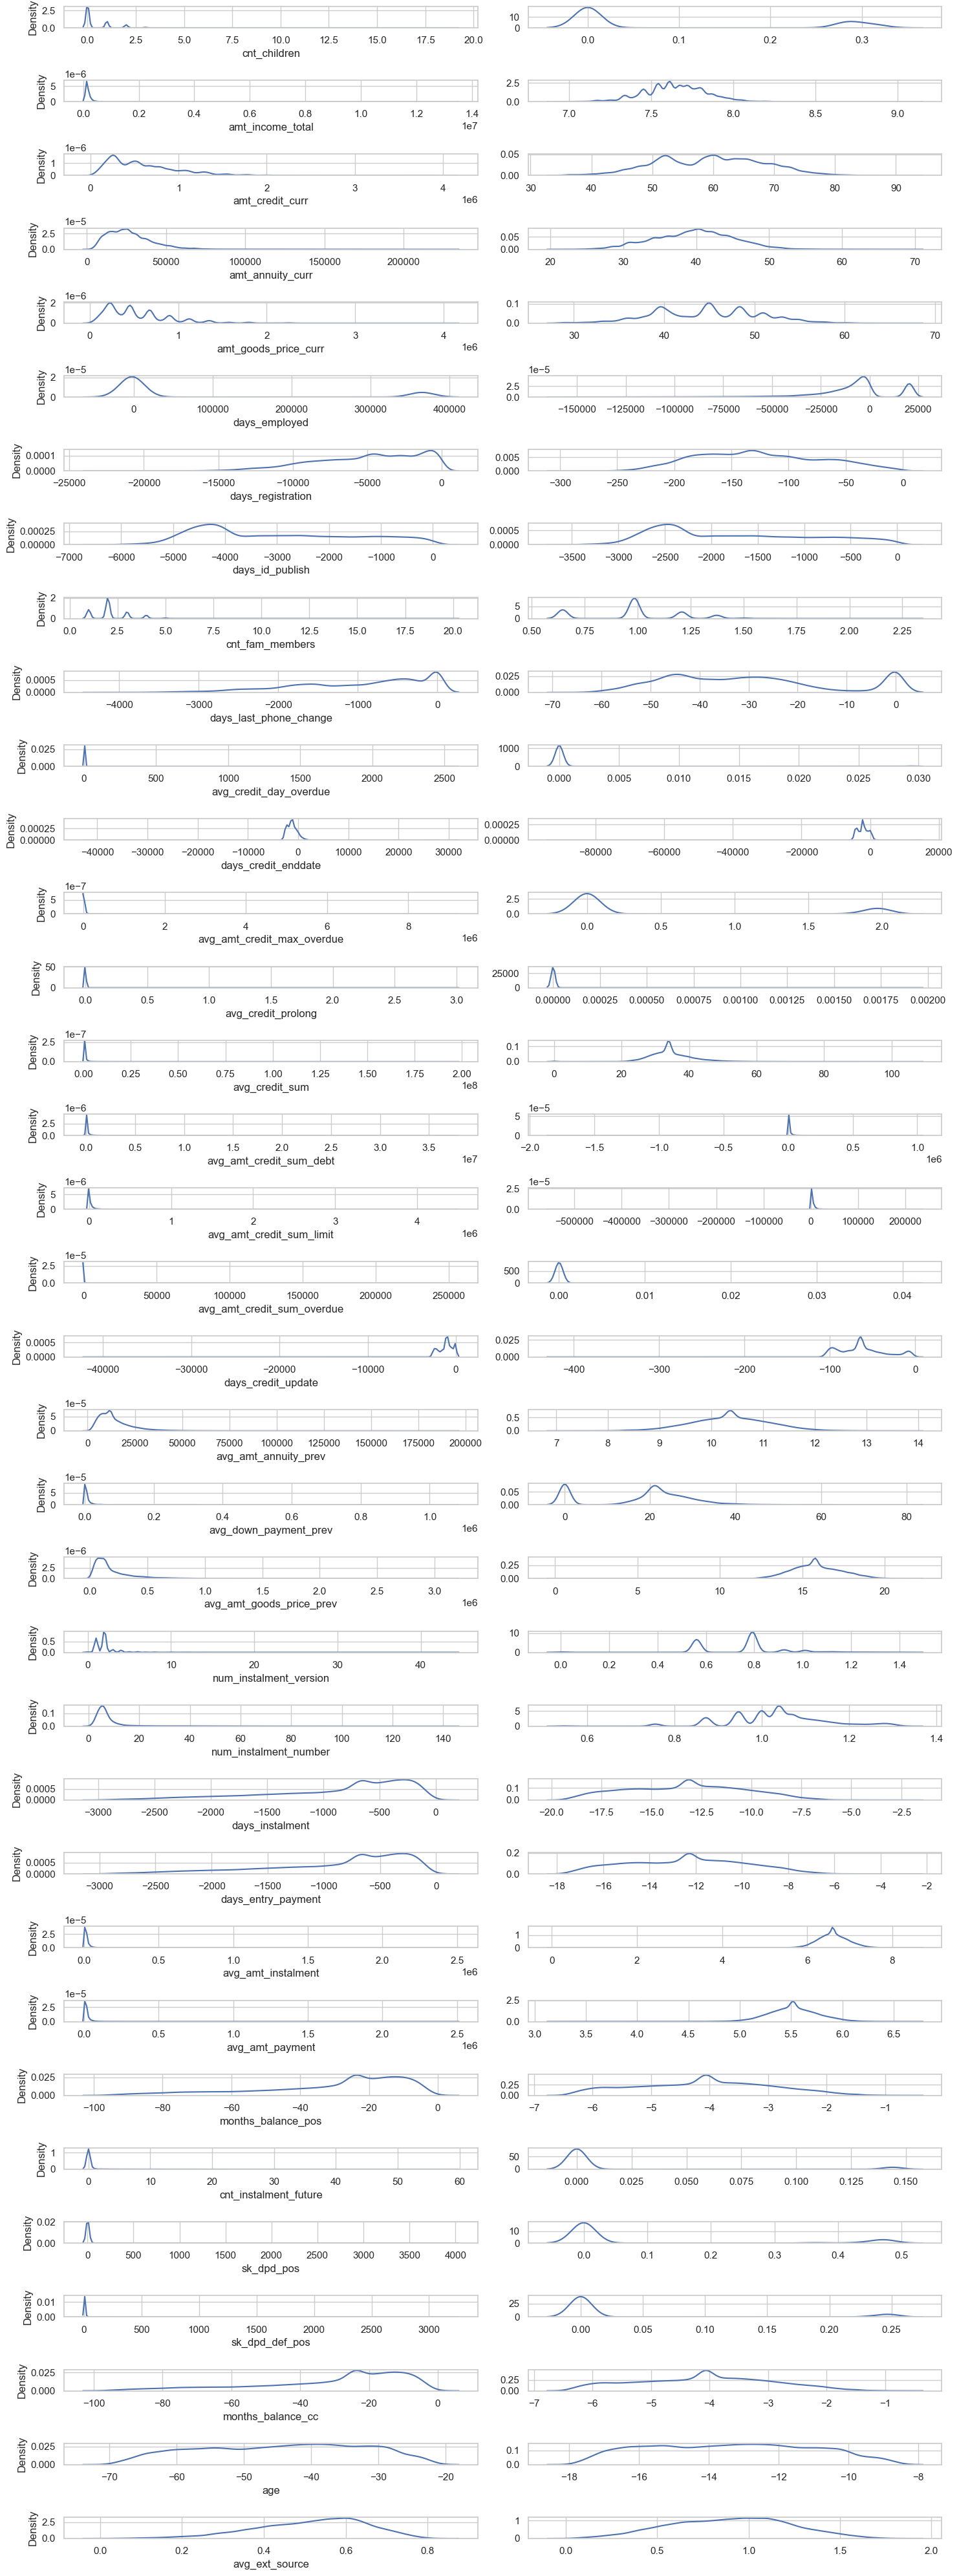

In [80]:
# Feature scaling for validating dataset
fig, ax = plt.subplots(len(scaling_columns), 2, figsize=(15, 40))
for i in range(0, len(scaling_columns)):
    data, fitted_lambda = yeojohnson(df_val[scaling_columns[i]], lmbda=None)
    kde1 = sns.kdeplot(df_val[scaling_columns[i]], ax=ax[i][0])
    kde2 = sns.kdeplot(data, ax=ax[i][1])
    kde2.set_ylabel(None)

plt.tight_layout()

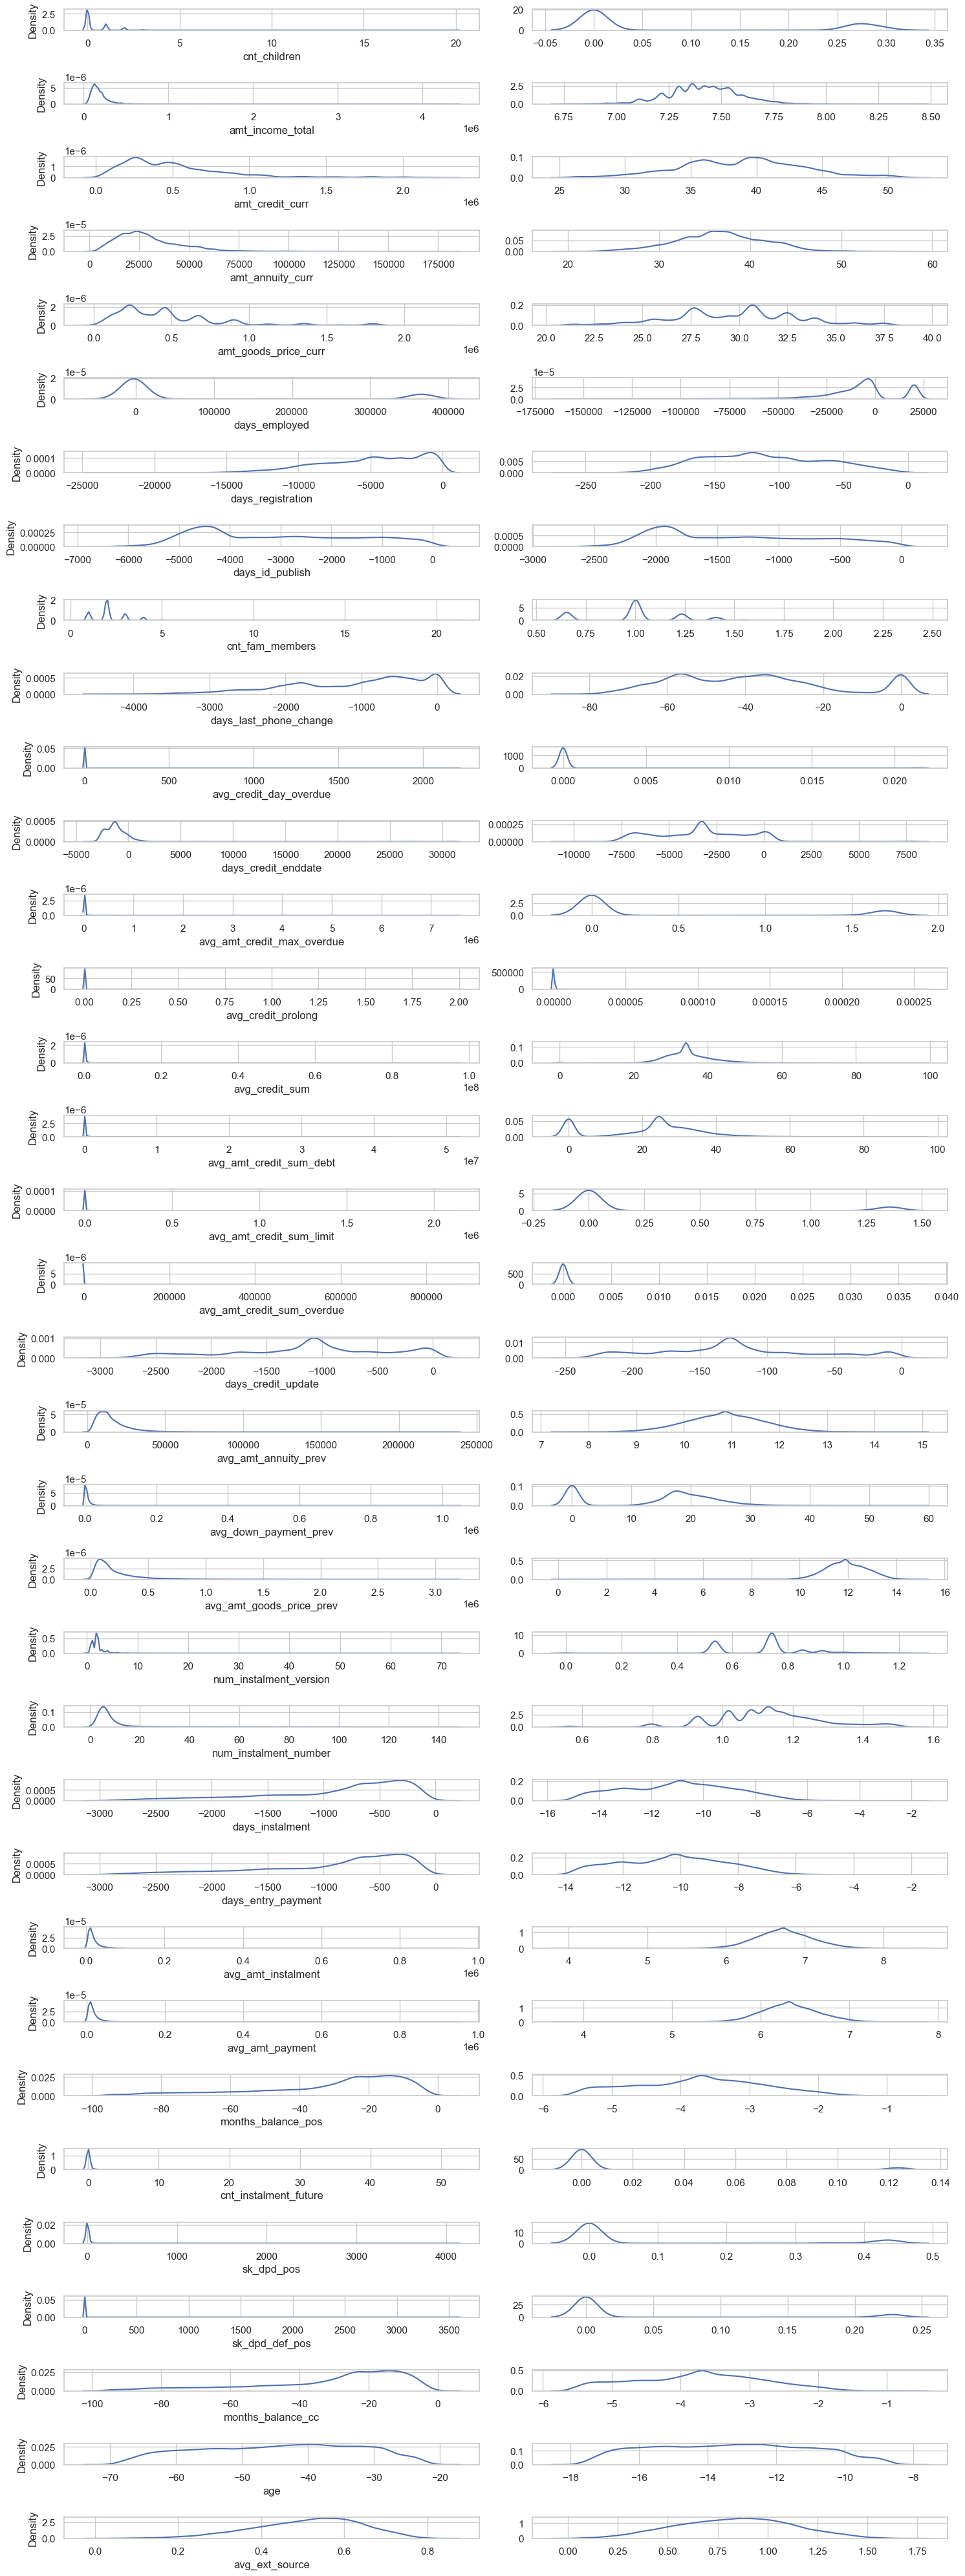

In [81]:
# Feature scaling for testing dataset
fig, ax = plt.subplots(len(scaling_columns), 2, figsize=(15, 40))
for i in range(0, len(scaling_columns)):
    data, fitted_lambda = yeojohnson(df_test[scaling_columns[i]], lmbda=None)
    kde1 = sns.kdeplot(df_test[scaling_columns[i]], ax=ax[i][0])
    kde2 = sns.kdeplot(data, ax=ax[i][1])
    kde2.set_ylabel(None)

plt.tight_layout()

### Feature Encoding

Feature encoding will be performed using label encoding and one-hot encoding with get_dummies. Label encoding will be applied to columns with binary values or categorical values that have ordinal levels, such as `flag_own_car`, `flag_own_realty`, and `name_education_type`. Meanwhile, one-hot encoding will be applied to other categorical columns that do not have ordinal levels.

#### Label Encoding

In [82]:
# Label encoding for flag_own_car column
map_car = {
    'N': 0, 
    'Y': 1
}
df_train['flag_own_car'] = df_train['flag_own_car'].map(map_car)
df_val['flag_own_car'] = df_val['flag_own_car'].map(map_car)
df_test['flag_own_car'] = df_test['flag_own_car'].map(map_car)

# Label encoding for flag_own_realty column
map_realty = {
    'N': 0, 
    'Y': 1
}
df_train['flag_own_realty'] = df_train['flag_own_realty'].map(map_realty)
df_val['flag_own_realty'] = df_val['flag_own_realty'].map(map_realty)
df_test['flag_own_realty'] = df_test['flag_own_realty'].map(map_realty)

# Label encoding for name_education_type column
map_education = {
    'Lower secondary': 0,
    'Secondary': 1,
    'Above secondary': 2
}
df_train['name_education_type'] = df_train['name_education_type'].map(map_education)
df_val['name_education_type'] = df_val['name_education_type'].map(map_education)
df_test['name_education_type'] = df_test['name_education_type'].map(map_education)

#### One Hot Encoding

In [83]:
df_train = pd.get_dummies(df_train, columns=['name_contract_type_curr', 'code_gender', 'name_income_type', 'name_family_status', 'name_housing_type', 'occupation_type', 'organization_type', 'credit_bureau_active', 'credit_type', 'name_contract_type_prev', 'name_contract_status_prev', 'name_portfolio_prev', 'name_contract_status_pos'])
df_val = pd.get_dummies(df_val, columns=['name_contract_type_curr', 'code_gender', 'name_income_type', 'name_family_status', 'name_housing_type', 'occupation_type', 'organization_type', 'credit_bureau_active', 'credit_type', 'name_contract_type_prev', 'name_contract_status_prev', 'name_portfolio_prev', 'name_contract_status_pos'])
df_test = pd.get_dummies(df_test, columns=['name_contract_type_curr', 'code_gender', 'name_income_type', 'name_family_status', 'name_housing_type', 'occupation_type', 'organization_type', 'credit_bureau_active', 'credit_type', 'name_contract_type_prev', 'name_contract_status_prev', 'name_portfolio_prev', 'name_contract_status_pos'])

In [84]:
'''
Check for missing columns in the training data compared to the testing data. 
If there are any missing columns, add them to the training data with a default value of 0.
'''

# Training dataset
missing_columns_train = set(df_val.columns) - set(df_train.columns)
for col in missing_columns_train:
    df_train[col] = 0
print(f'Shape of training data: {df_train.shape}')

# Testing dataset 
missing_columns_val = set(df_train.columns) - set(df_val.columns)
for col in missing_columns_val:
    df_val[col] = 0
print(f'Shape of validating data: {df_val.shape}')

Shape of training data: (246008, 147)
Shape of validating data: (61503, 147)


In [77]:
# Testing dataset
# missing_columns_test = set(df_train.columns) - set(df_test.columns)
# for col in missing_columns_test:
#     df_test[col] = 0
# print(f'Shape of testing data: {df_test.shape}')

Shape of testing data: (48744, 148)


In [85]:
# Drop unnecessary column
df_train.drop(['sk_id_curr'], axis=1, inplace=True)
df_val.drop(['sk_id_curr'], axis=1, inplace=True)
df_test.drop(['sk_id_curr'], axis=1, inplace=True)

### Handle Imbalance

#### Resampling

In [86]:
df_train['target'].value_counts()

0    226148
1     19860
Name: target, dtype: int64

In [89]:
from sklearn.utils import resample

# create two different dataframe of majority and minority class 
majority_class = df_train[(df_train['target'] == 0)] 
minority_class = df_train[(df_train['target'] == 1)] 

# upsample minority class
minority_class_upsampled = resample(minority_class, 
                                    replace=True,    # sample with replacement
                                    n_samples=226148, # to match majority class
                                    random_state=42)  # reproducible results

# combine majority class with upsampled minority class
df_upsampled = pd.concat([minority_class_upsampled, majority_class])

#### Oversampling using SMOTE

In [87]:
train_imb = df_train.copy()

In [155]:
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE

print(f'Target in Original Data:')
print(pd.Series(y_train).value_counts(), end='\n\n')
X_train, y_train = over_sampling.SMOTE(sampling_strategy=0.5).fit_resample(X_train, y_train)
print('Target After Oversampling Using SMOTE:')
print(pd.Series(y_train).value_counts())

Target in Original Data:
0    197880
1     17377
Name: target, dtype: int64

Target After Oversampling Using SMOTE:
0    197880
1     98940
Name: target, dtype: int64


### Feature Selection

In [90]:
# define X_train and y_train
X_train = df_upsampled.drop(['target'], axis=1) #features
y_train = df_upsampled['target'] #target

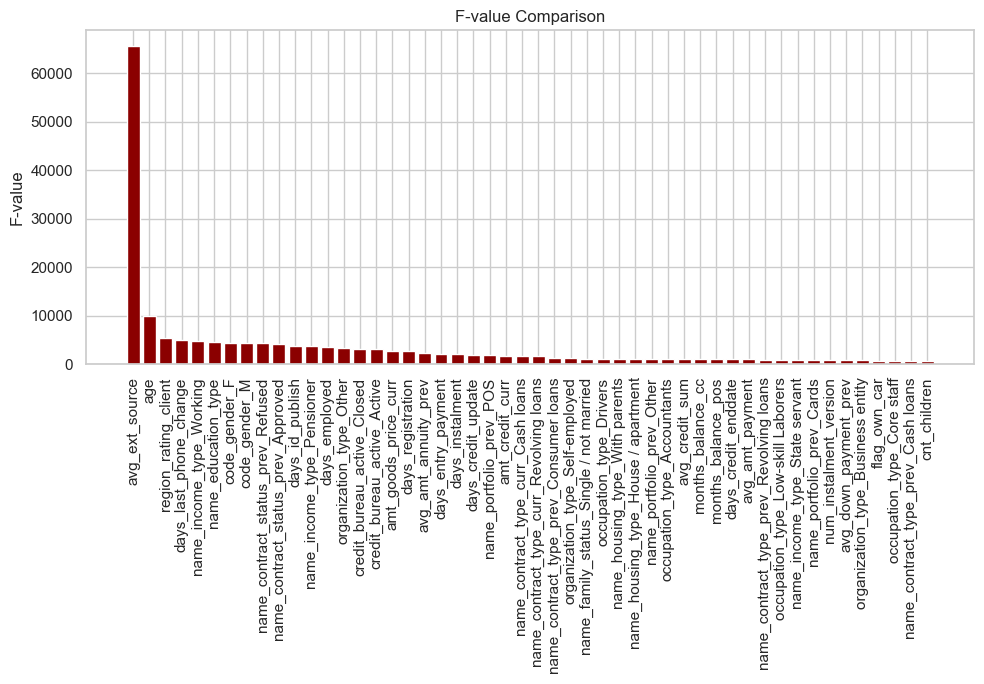

In [91]:
from sklearn.feature_selection import f_classif

f_value, _ = f_classif(X_train, y_train)

feature_scores = pd.DataFrame({
    "feature_names": X_train.columns,
    "feature_value": f_value
}).sort_values("feature_value", ascending=False)
top_50_features = feature_scores.head(50)

# Create a bar chart
plt.figure(figsize=(10, 7))
plt.bar(data=top_50_features, x="feature_names", height="feature_value", color="darkred")
plt.xticks(rotation="vertical")
plt.ylabel("F-value")
plt.title("F-value Comparison")
plt.tight_layout()
plt.show()

In [92]:
feature_importance = []
for i in feature_scores["feature_names"].values[:10]:
    if i not in feature_importance:
        feature_importance.append(i)
feature_importance

['avg_ext_source',
 'age',
 'region_rating_client',
 'days_last_phone_change',
 'name_income_type_Working',
 'name_education_type',
 'code_gender_F',
 'code_gender_M',
 'name_contract_status_prev_Refused',
 'name_contract_status_prev_Approved']

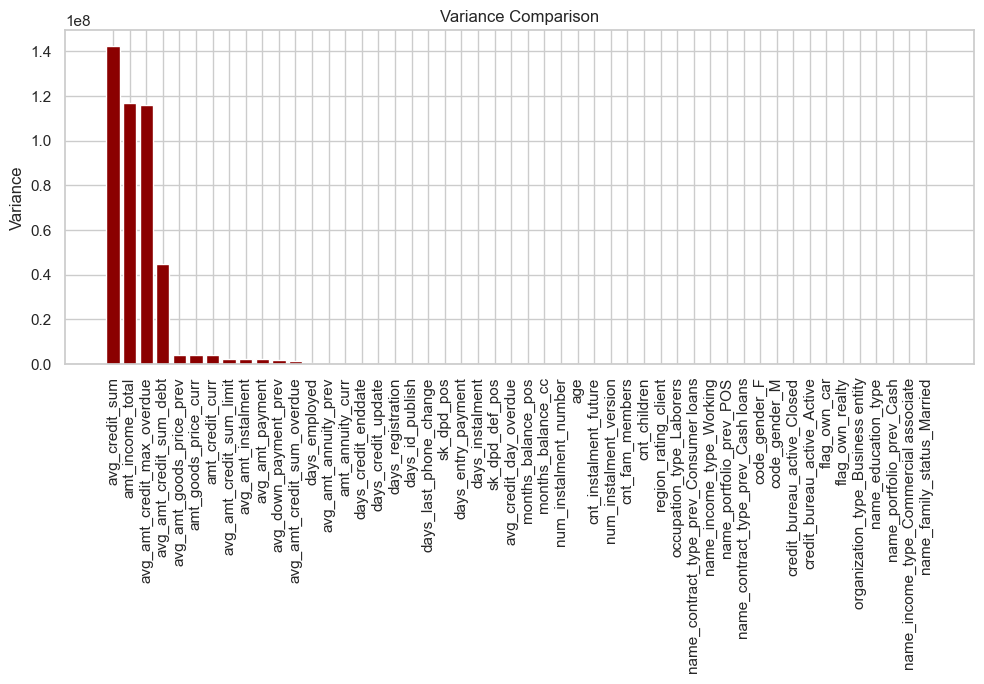

In [93]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.0)
X_train_transformed = selector.fit_transform(X_train)

feature_scores = pd.DataFrame({
    "feature_names": X_train.columns,
    "variances": selector.variances_
}).sort_values("variances", ascending=False)
top_50_features = feature_scores.head(50)

plt.figure(figsize=(10, 7))
plt.bar(data=top_50_features, x="feature_names", height="variances", color="darkred")
plt.xticks(rotation="vertical")
plt.ylabel("Variance")
plt.title("Variance Comparison")
plt.tight_layout()
plt.show()

In [94]:
for i in feature_scores["feature_names"].values[:10]:
    if i not in feature_importance:
        feature_importance.append(i)
feature_importance

['avg_ext_source',
 'age',
 'region_rating_client',
 'days_last_phone_change',
 'name_income_type_Working',
 'name_education_type',
 'code_gender_F',
 'code_gender_M',
 'name_contract_status_prev_Refused',
 'name_contract_status_prev_Approved',
 'avg_credit_sum',
 'amt_income_total',
 'avg_amt_credit_max_overdue',
 'avg_amt_credit_sum_debt',
 'avg_amt_goods_price_prev',
 'amt_goods_price_curr',
 'amt_credit_curr',
 'avg_amt_credit_sum_limit',
 'avg_amt_instalment',
 'avg_amt_payment']

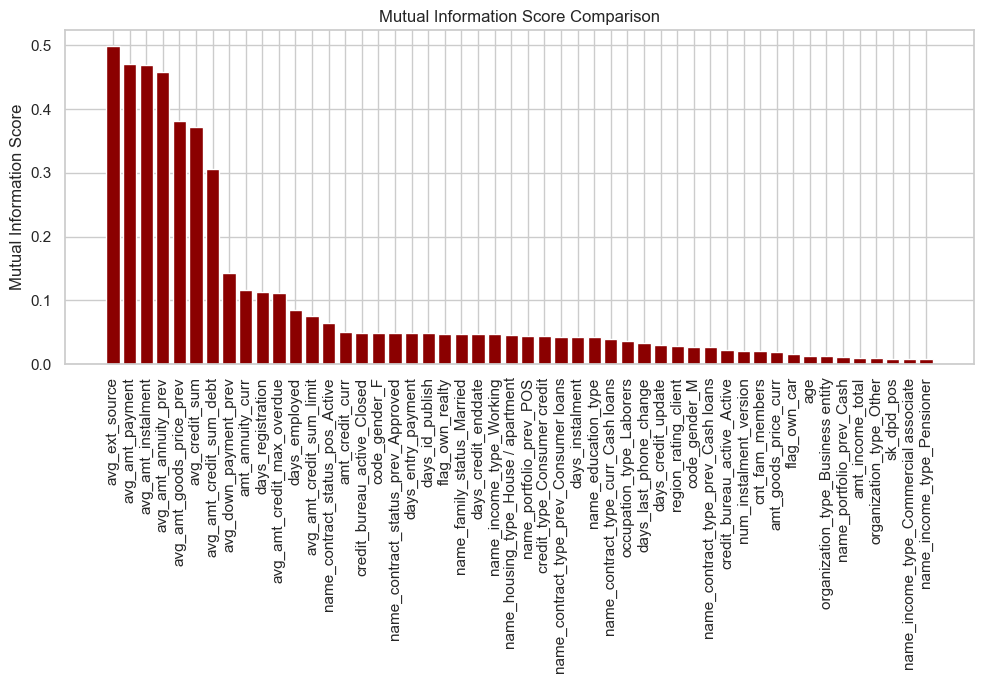

In [95]:
from sklearn.feature_selection import mutual_info_classif

MI_score = mutual_info_classif(X_train, y_train, random_state=0)

feature_scores = pd.DataFrame({
    "feature_names": X_train.columns,
    "MI_score": MI_score
}).sort_values("MI_score", ascending=False)
top_50_features = feature_scores.head(50)

plt.figure(figsize=(10, 7))
plt.bar(data=top_50_features, x="feature_names", height="MI_score", color="darkred")
plt.xticks(rotation="vertical")
plt.ylabel("Mutual Information Score")
plt.title("Mutual Information Score Comparison")
plt.tight_layout()
plt.show()

In [96]:
for i in feature_scores["feature_names"].values[:10]:
    if i not in feature_importance:
        feature_importance.append(i)
feature_importance

['avg_ext_source',
 'age',
 'region_rating_client',
 'days_last_phone_change',
 'name_income_type_Working',
 'name_education_type',
 'code_gender_F',
 'code_gender_M',
 'name_contract_status_prev_Refused',
 'name_contract_status_prev_Approved',
 'avg_credit_sum',
 'amt_income_total',
 'avg_amt_credit_max_overdue',
 'avg_amt_credit_sum_debt',
 'avg_amt_goods_price_prev',
 'amt_goods_price_curr',
 'amt_credit_curr',
 'avg_amt_credit_sum_limit',
 'avg_amt_instalment',
 'avg_amt_payment',
 'avg_amt_annuity_prev',
 'avg_down_payment_prev',
 'amt_annuity_curr',
 'days_registration']

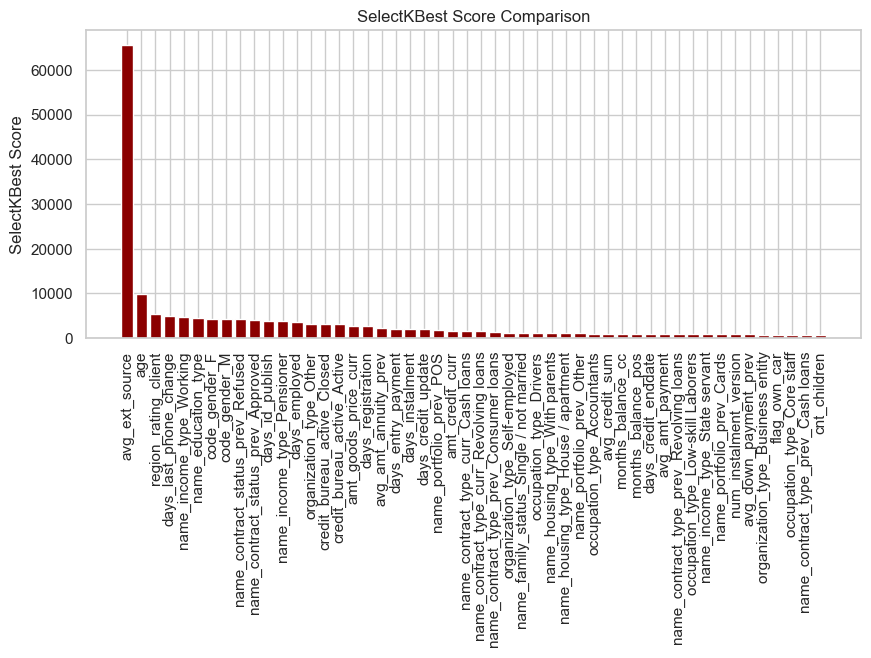

In [97]:
from sklearn.feature_selection import SelectKBest

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X_train, y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

feature_scores = pd.concat([dfcolumns, dfscores], axis=1)
feature_scores.columns = ['Specs', 'Score']  
feature_scores.sort_values('Score', ascending=False, inplace=True)
top_50_features = feature_scores.head(50)

plt.figure(figsize=(10, 4))
plt.bar(data=top_50_features, x="Specs", height="Score", color="darkred")
plt.xticks(rotation="vertical")
plt.ylabel("SelectKBest Score")
plt.title("SelectKBest Score Comparison")
plt.show()

In [98]:
for i in feature_scores["Specs"].values[:10]:
    if i not in feature_importance:
        feature_importance.append(i)
feature_importance

['avg_ext_source',
 'age',
 'region_rating_client',
 'days_last_phone_change',
 'name_income_type_Working',
 'name_education_type',
 'code_gender_F',
 'code_gender_M',
 'name_contract_status_prev_Refused',
 'name_contract_status_prev_Approved',
 'avg_credit_sum',
 'amt_income_total',
 'avg_amt_credit_max_overdue',
 'avg_amt_credit_sum_debt',
 'avg_amt_goods_price_prev',
 'amt_goods_price_curr',
 'amt_credit_curr',
 'avg_amt_credit_sum_limit',
 'avg_amt_instalment',
 'avg_amt_payment',
 'avg_amt_annuity_prev',
 'avg_down_payment_prev',
 'amt_annuity_curr',
 'days_registration']

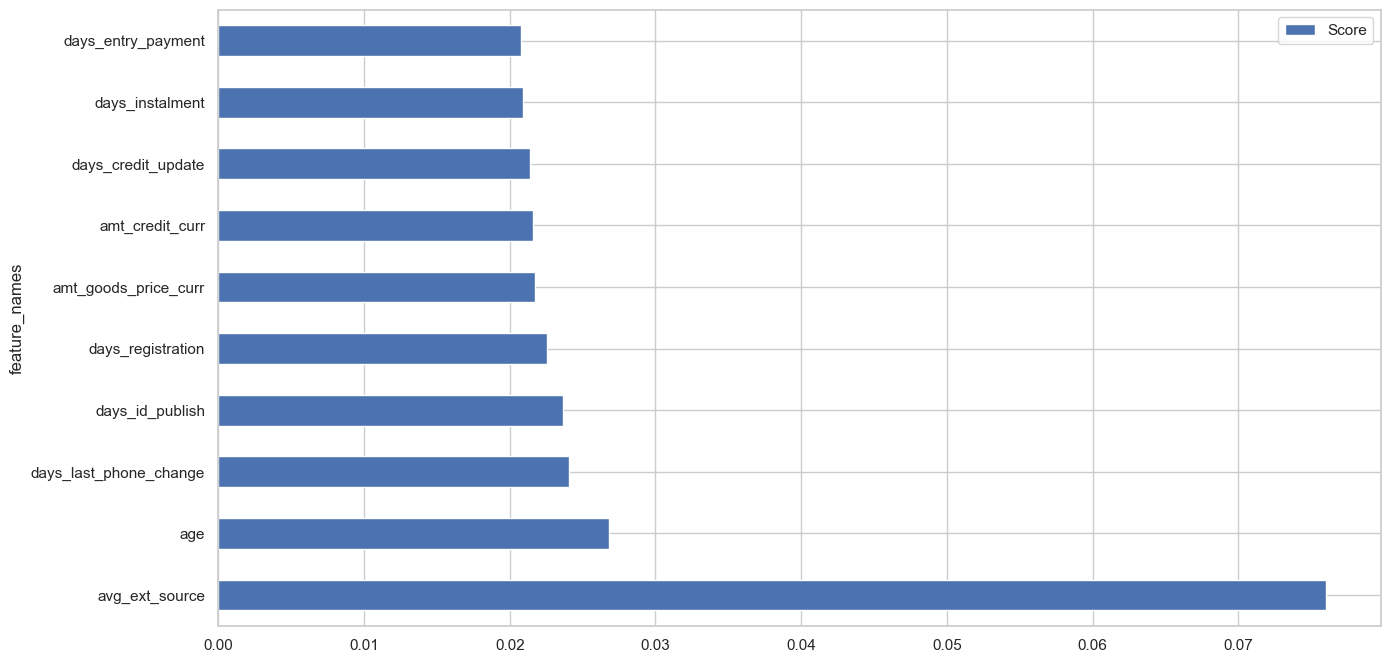

In [99]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X_train, y_train)

feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances = pd.DataFrame(feat_importances).reset_index(names="feature_names") \
    .rename(columns={0:"Score"}) \
    .sort_values("Score", ascending=False).reset_index(drop=True)
feat_importances.nlargest(10, "Score").plot(x="feature_names", y="Score", kind='barh')
plt.show()

In [100]:
for i in feat_importances["feature_names"].values[:10]:
    if i not in feature_importance:
        feature_importance.append(i)
feature_importance

['avg_ext_source',
 'age',
 'region_rating_client',
 'days_last_phone_change',
 'name_income_type_Working',
 'name_education_type',
 'code_gender_F',
 'code_gender_M',
 'name_contract_status_prev_Refused',
 'name_contract_status_prev_Approved',
 'avg_credit_sum',
 'amt_income_total',
 'avg_amt_credit_max_overdue',
 'avg_amt_credit_sum_debt',
 'avg_amt_goods_price_prev',
 'amt_goods_price_curr',
 'amt_credit_curr',
 'avg_amt_credit_sum_limit',
 'avg_amt_instalment',
 'avg_amt_payment',
 'avg_amt_annuity_prev',
 'avg_down_payment_prev',
 'amt_annuity_curr',
 'days_registration',
 'days_id_publish',
 'days_credit_update',
 'days_instalment',
 'days_entry_payment']

In [101]:
corr = df_train.corrwith(df_train["target"], numeric_only=True)
corr = corr.reset_index(name='corr value')
corr["Corr Type"] = corr["corr value"].apply(lambda x : "Positif" if x >= 0 else "Negatif")
corr["corr value"] = corr["corr value"].apply(lambda x : abs(x))
corr = corr.sort_values('corr value', ascending=False, ignore_index=True)
corr.head(10)

index  corr value Corr Type
0                              target        1.00   Positif
1                      avg_ext_source        0.21   Negatif
2                                 age        0.08   Positif
3   name_contract_status_prev_Refused        0.06   Positif
4                region_rating_client        0.06   Positif
5  name_contract_status_prev_Approved        0.06   Negatif
6            name_income_type_Working        0.06   Positif
7                       code_gender_M        0.05   Positif
8                       code_gender_F        0.05   Negatif
9              days_last_phone_change        0.05   Positif

In [102]:
corr = df_train.corrwith(df_train["target"], numeric_only=True)
corr = corr.reset_index(name='corr value')
corr = corr.sort_values('corr value', ascending=False)[1:]

target = "target"
high_corr_cols = [i for i in list(corr[corr["corr value"] > -1]["index"].values) if i != target]

In [103]:
for i in corr["index"].values[:10]:
    if i not in feature_importance and not target:
        feature_importance.append(i)
feature_importance

['avg_ext_source',
 'age',
 'region_rating_client',
 'days_last_phone_change',
 'name_income_type_Working',
 'name_education_type',
 'code_gender_F',
 'code_gender_M',
 'name_contract_status_prev_Refused',
 'name_contract_status_prev_Approved',
 'avg_credit_sum',
 'amt_income_total',
 'avg_amt_credit_max_overdue',
 'avg_amt_credit_sum_debt',
 'avg_amt_goods_price_prev',
 'amt_goods_price_curr',
 'amt_credit_curr',
 'avg_amt_credit_sum_limit',
 'avg_amt_instalment',
 'avg_amt_payment',
 'avg_amt_annuity_prev',
 'avg_down_payment_prev',
 'amt_annuity_curr',
 'days_registration',
 'days_id_publish',
 'days_credit_update',
 'days_instalment',
 'days_entry_payment']

<Axes: >

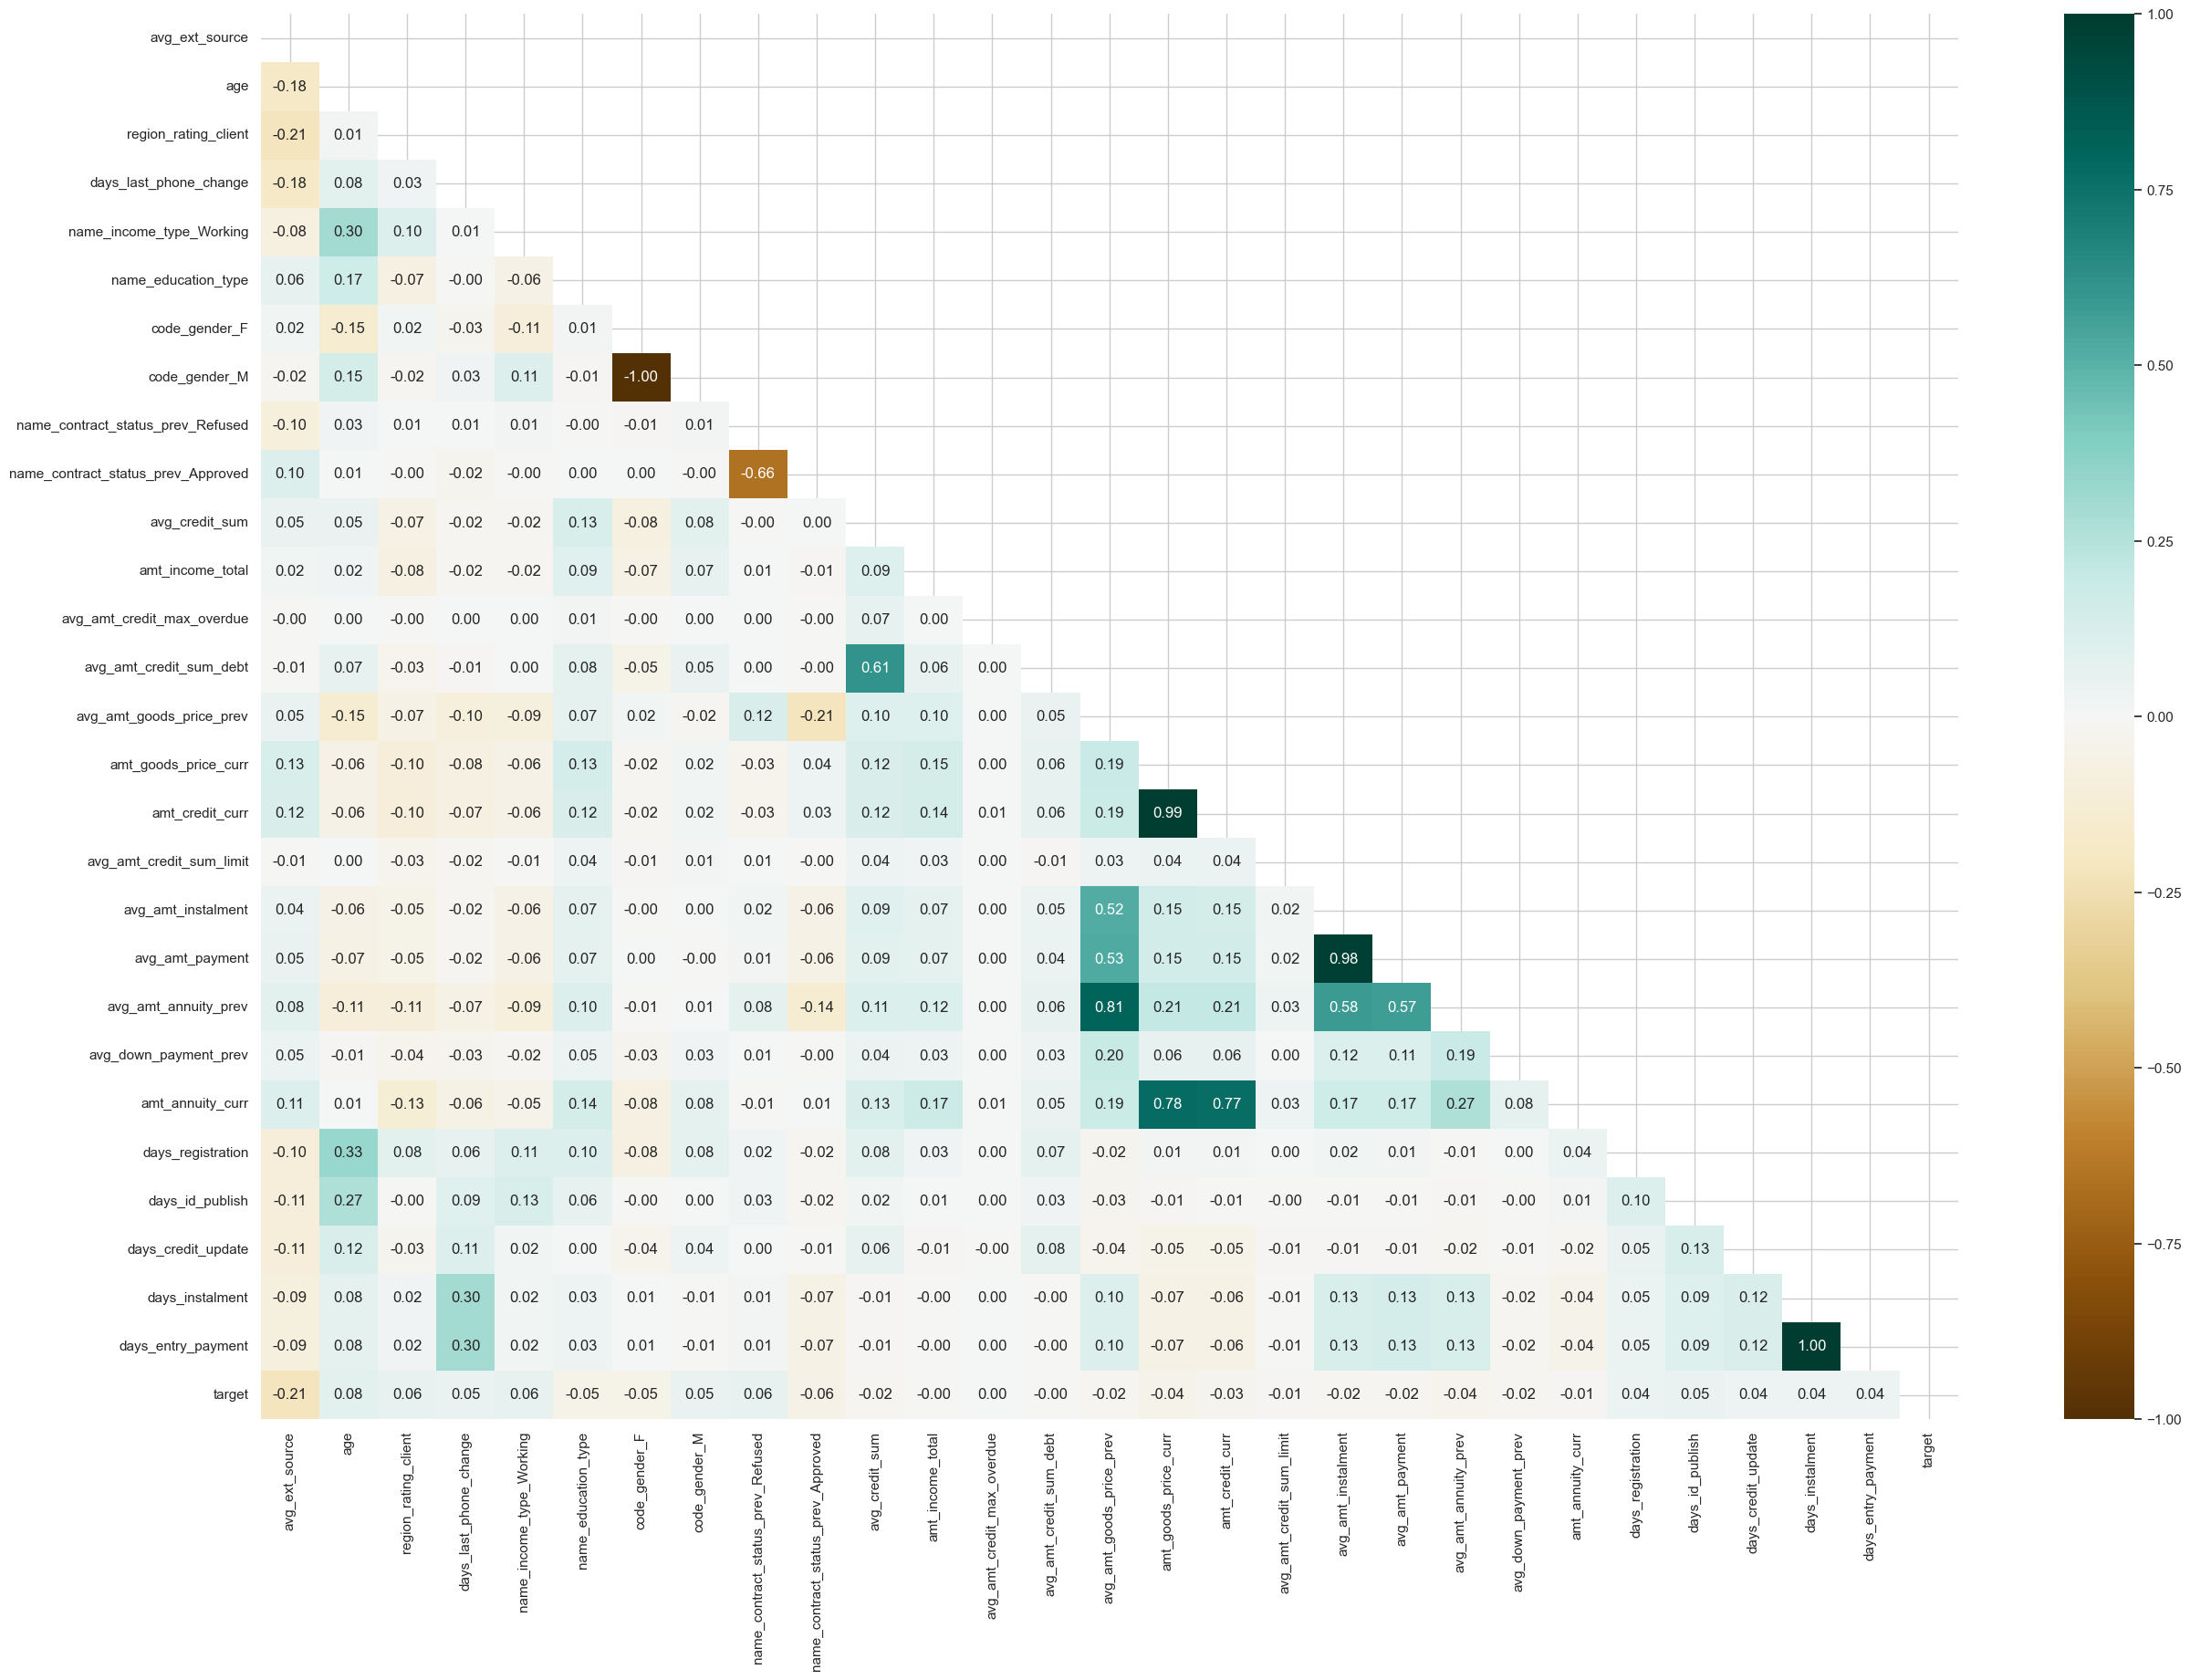

In [104]:
plt.figure(figsize=(30, 20))
corr = df_train[feature_importance+["target"]].corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
sns.heatmap(corr, vmin=-1, vmax=1, cmap='BrBG', annot=True, fmt='.2f', mask=mask)

In [106]:
final_feature = ['avg_ext_source', 'age', 'region_rating_client', 'days_last_phone_change', 
                 'name_income_type_Working', 'name_education_type', 'code_gender_M', 
                 'name_contract_status_prev_Refused', 'name_contract_status_prev_Approved', 
                 'avg_credit_sum', 'amt_income_total', 'avg_amt_credit_max_overdue', 
                 'avg_amt_credit_sum_debt', 'avg_amt_goods_price_prev', 'amt_goods_price_curr', 
                 'avg_amt_credit_sum_limit', 'avg_amt_instalment', 'avg_amt_payment', 
                 'avg_amt_annuity_prev', 'avg_down_payment_prev', 'amt_annuity_curr', 
                 'days_registration', 'days_id_publish', 'days_credit_update', 'days_entry_payment']

In [105]:
print(feature_importance)

['avg_ext_source', 'age', 'region_rating_client', 'days_last_phone_change', 'name_income_type_Working', 'name_education_type', 'code_gender_F', 'code_gender_M', 'name_contract_status_prev_Refused', 'name_contract_status_prev_Approved', 'avg_credit_sum', 'amt_income_total', 'avg_amt_credit_max_overdue', 'avg_amt_credit_sum_debt', 'avg_amt_goods_price_prev', 'amt_goods_price_curr', 'amt_credit_curr', 'avg_amt_credit_sum_limit', 'avg_amt_instalment', 'avg_amt_payment', 'avg_amt_annuity_prev', 'avg_down_payment_prev', 'amt_annuity_curr', 'days_registration', 'days_id_publish', 'days_credit_update', 'days_instalment', 'days_entry_payment']


In [107]:
X_train = df_train.drop(['target'], axis=1)[final_feature].reset_index(drop=True) 
y_train = df_train['target'].reset_index(drop=True) 
print(f'Shape of X_train and y_train: {X_train.shape, y_train.shape}')

X_val = df_val.drop(['target'], axis=1)[final_feature].reset_index(drop=True) 
y_val = df_val['target'].reset_index(drop=True) 
print(f'Shape of X_val and y_val: {X_val.shape, y_val.shape}')

Shape of X_train and y_train: ((246008, 25), (246008,))
Shape of X_val and y_val: ((61503, 25), (61503,))


## Modeling

### Logistic Regression

In [108]:
# Train the model
lr_model = LogisticRegression().fit(X_train, y_train)
print(lr_model)

LogisticRegression()


In [109]:
# Predict data train
y_train_pred_lr = lr_model.predict(X_train)
print('Classification Report Training Model (Logistic Regression):')
print(classification_report(y_train, y_train_pred_lr))

Classification Report Training Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    226148
           1       0.00      0.00      0.00     19860

    accuracy                           0.92    246008
   macro avg       0.46      0.50      0.48    246008
weighted avg       0.85      0.92      0.88    246008



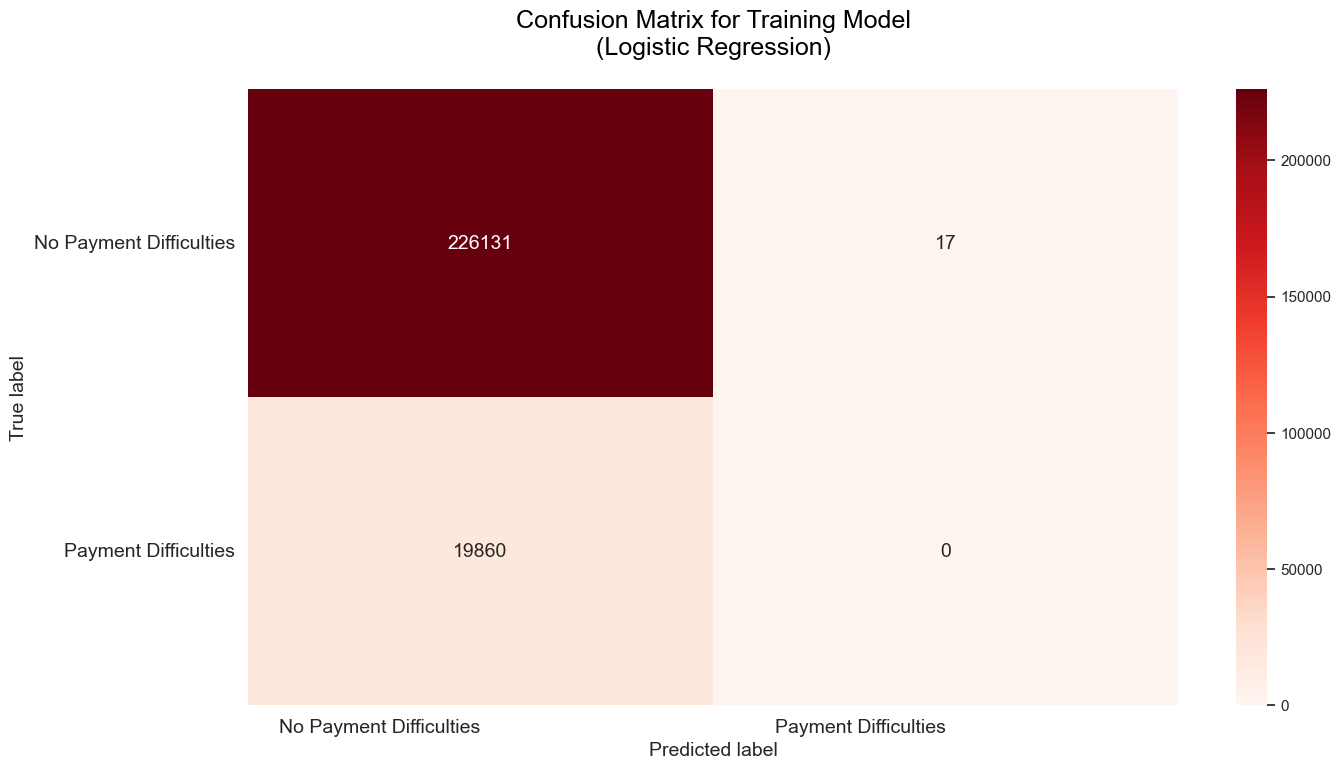

In [122]:
# Form confusion matrix as a dataFrame
confusion_matrix_lr = pd.DataFrame((confusion_matrix(y_train, y_train_pred_lr)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_lr, annot=True, annot_kws={'size': 14}, fmt='d', cmap='Reds')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Logistic Regression)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [111]:
# Predict data validation
y_val_pred_lr = lr_model.predict(X_val)
from sklearn.metrics import confusion_matrix, classification_report
print('Classification Report Validating Model (Logistic Regression):')
print(classification_report(y_val, y_val_pred_lr))

Classification Report Validating Model (Logistic Regression):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.00      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503



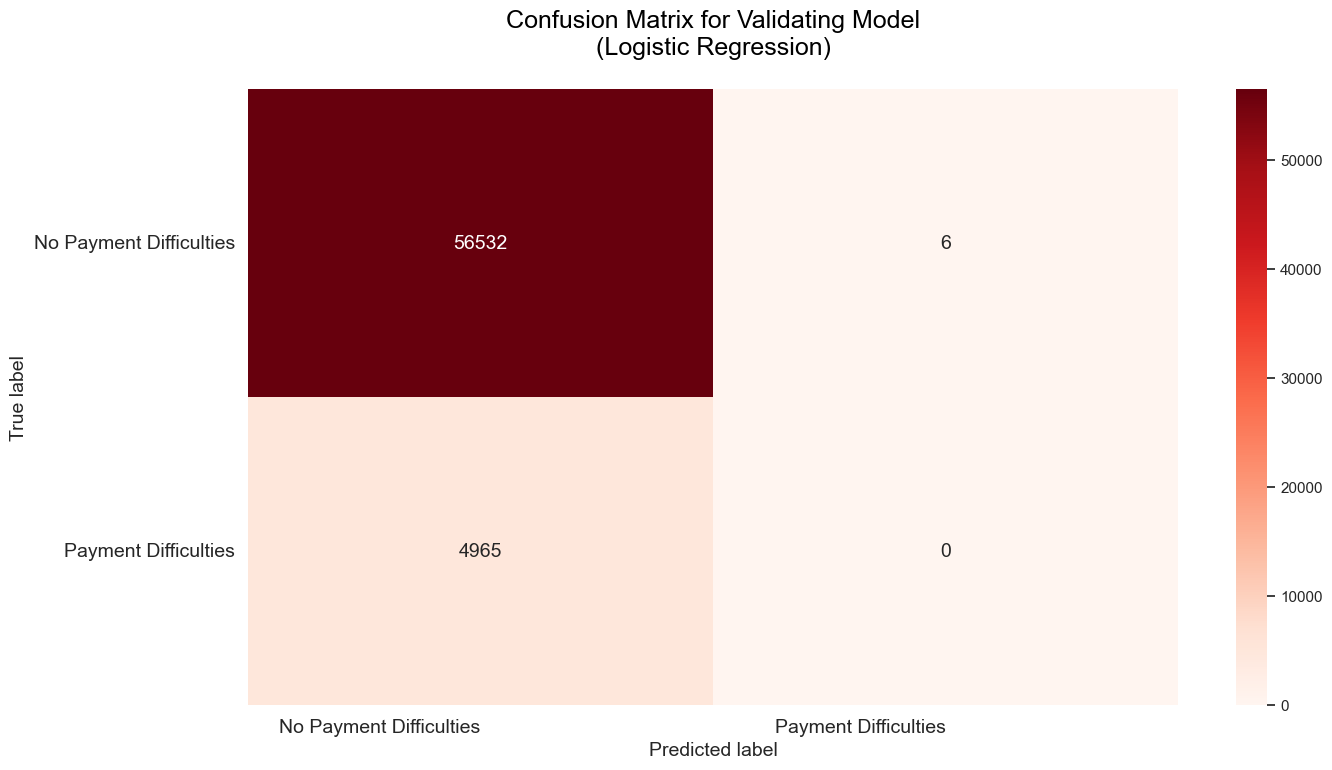

In [121]:
# Form confusion matrix as a dataFrame
confusion_matrix_lr = pd.DataFrame((confusion_matrix(y_val, y_val_pred_lr)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_lr, annot=True, annot_kws={'size': 14}, fmt='d', cmap='Reds')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Validating Model\n(Logistic Regression)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [118]:
# Recall
recall_train = recall_score(y_train, y_train_pred_lr, average='weighted')
print(f'Recall Train: {round(recall_train, 2)}')
recall_val = recall_score(y_val, y_val_pred_lr, average='weighted')
print(f'Recall Validation: {round(recall_val, 2)}', end='\n\n')

# Precision
precision_train = precision_score(y_train, y_train_pred_lr, average='weighted')
print(f'Precision Train: {round(precision_train, 2)}')
precision_val = precision_score(y_val, y_val_pred_lr, average='weighted')
print(f'Precision Validation: {round(precision_test, 2)}', end='\n\n')

# Accuracy
accuracy_train = accuracy_score(y_train, y_train_pred_lr)
print(f'Accuracy Train: {round(accuracy_train, 2)}')
accuracy_val = accuracy_score(y_val, y_val_pred_lr)
print(f'Accuracy Validation: {round(accuracy_val, 2)}')

Recall Train: 0.92
Recall Validation: 0.92

Precision Train: 0.85
Precision Validation: 0.85

Accuracy Train: 0.92
Accuracy Validation: 0.92


ROC AUC (Train): 0.49996241399437535
ROC AUC (Validation): 0.4999469383423538


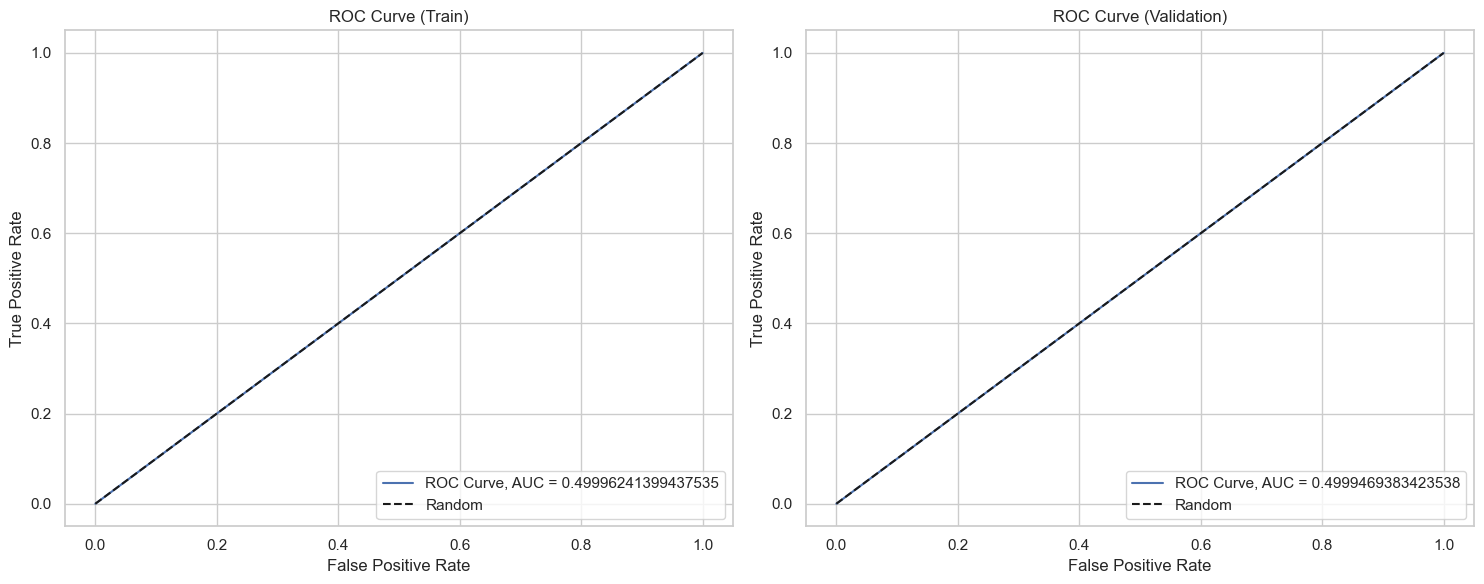

In [119]:
# Function to plot ROC curve
def plot_roc_curve(fpr, tpr, auc, title):
    plt.plot(fpr, tpr, label=f'ROC Curve, AUC = {auc}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')

# ROC AUC (Train)
roc_auc_train = roc_auc_score(y_train, y_train_pred_lr)
print(f'ROC AUC (Train): {roc_auc_train}')

# ROC Curve (Train)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_lr)

# ROC AUC (Validation)
roc_auc_val = roc_auc_score(y_val, y_val_pred_lr)
print(f'ROC AUC (Validation): {roc_auc_val}')

# ROC Curve (Validation)
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_val_pred_lr)

# Plot ROC Curves side by side
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plot_roc_curve(fpr_train, tpr_train, roc_auc_train, 'ROC Curve (Train)')

plt.subplot(1, 2, 2)
plot_roc_curve(fpr_val, tpr_val, roc_auc_val, 'ROC Curve (Validation)')

plt.tight_layout()
plt.show()

### Decision Tree

In [120]:
# Train the model
dt_model = DecisionTreeClassifier().fit(X_train, y_train)
print(dt_model)

DecisionTreeClassifier()


In [123]:
# Predict data train
y_train_pred_dt = dt_model.predict(X_train)
print('Classification Report Training Model (Decision Tree):')
print(classification_report(y_train, y_train_pred_dt))

Classification Report Training Model (Decision Tree):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226148
           1       1.00      1.00      1.00     19860

    accuracy                           1.00    246008
   macro avg       1.00      1.00      1.00    246008
weighted avg       1.00      1.00      1.00    246008



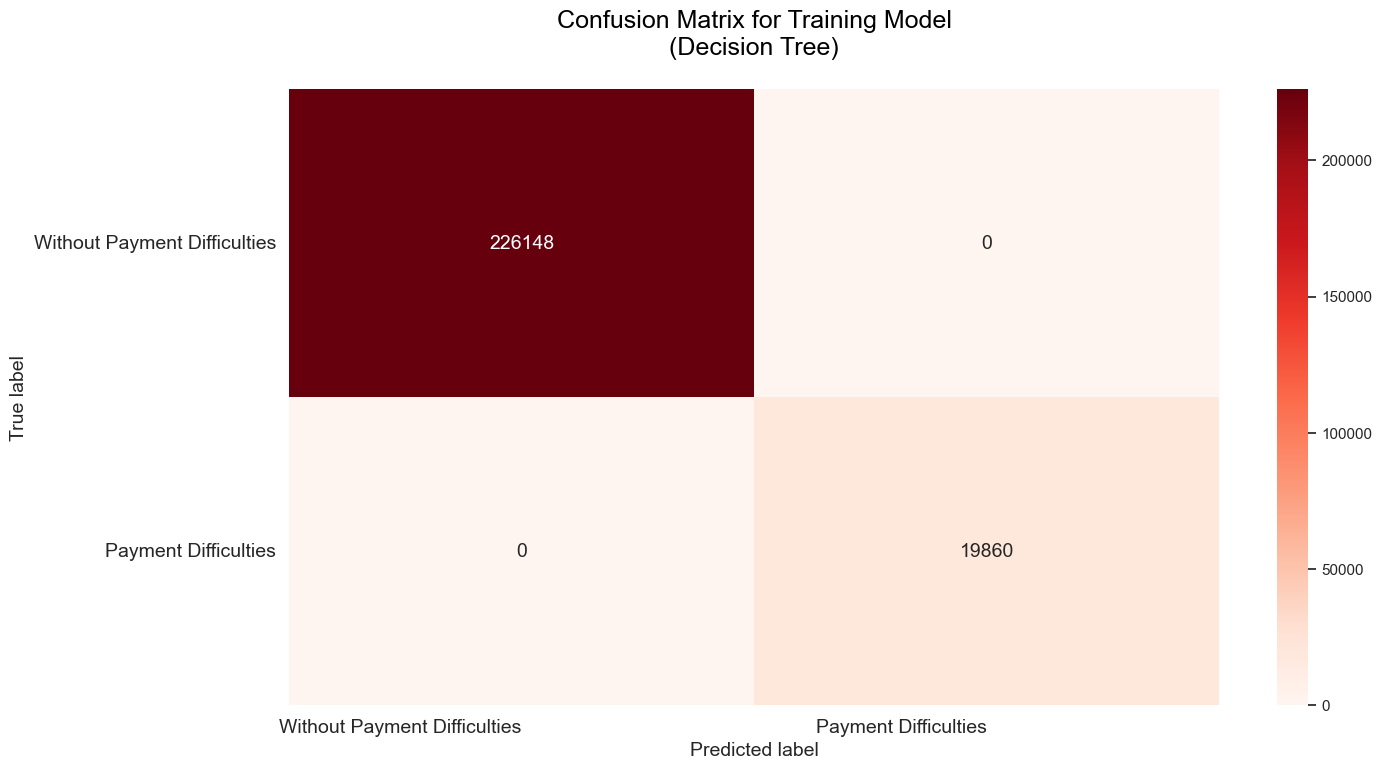

In [124]:
# Form confusion matrix as a dataFrame
confusion_matrix_dt = pd.DataFrame((confusion_matrix(y_train, y_train_pred_dt)), ('Without Payment Difficulties', 'Payment Difficulties'), ('Without Payment Difficulties', 'Payment Difficulties'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_dt, annot=True, annot_kws={'size': 14}, fmt='d', cmap='Reds')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Decision Tree)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [125]:
# Predict data validation
y_val_pred_dt = dt_model.predict(X_val)
from sklearn.metrics import confusion_matrix, classification_report
print('Classification Report Validating Model (Decision Tree):')
print(classification_report(y_val, y_val_pred_dt))

Classification Report Validating Model (Decision Tree):
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     56538
           1       0.14      0.17      0.16      4965

    accuracy                           0.85     61503
   macro avg       0.54      0.54      0.54     61503
weighted avg       0.86      0.85      0.86     61503



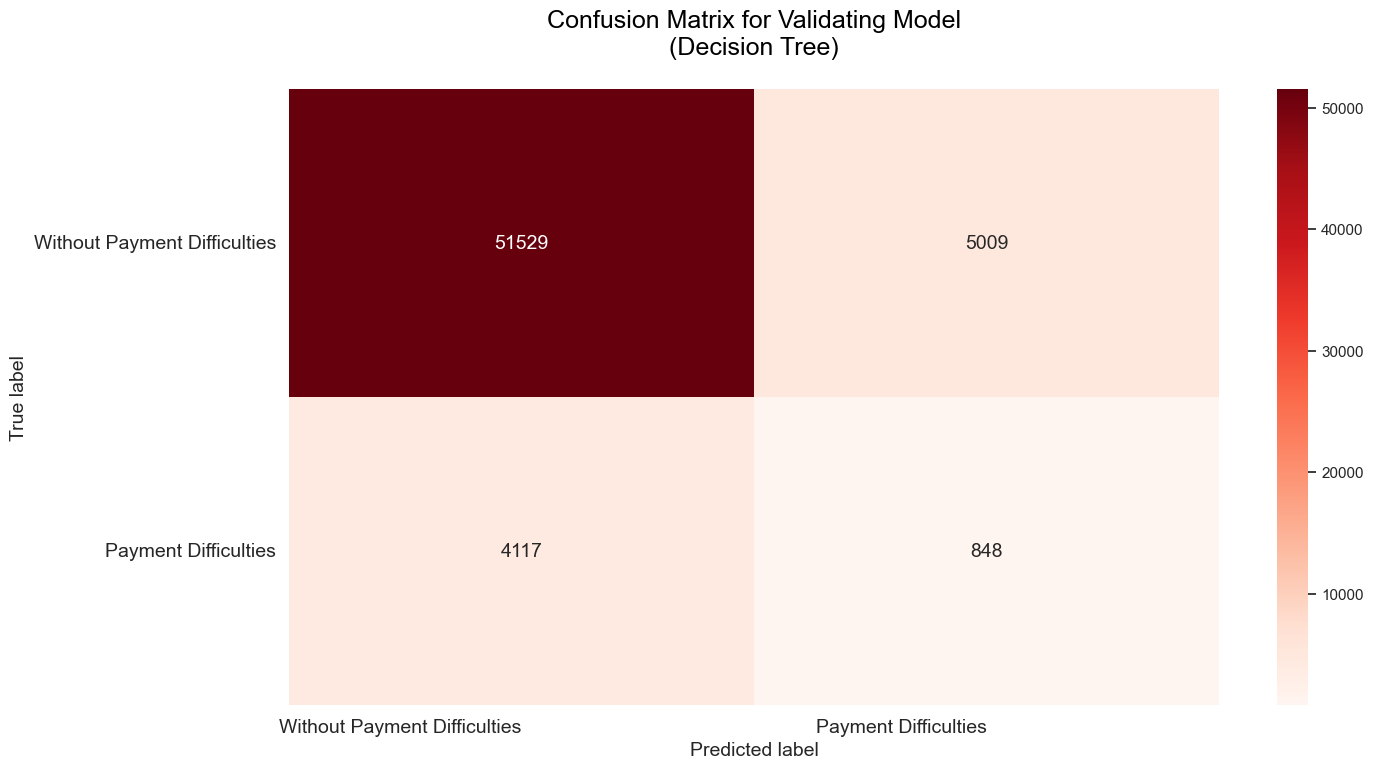

In [126]:
# Form confusion matrix as a dataFrame
confusion_matrix_dt = pd.DataFrame((confusion_matrix(y_val, y_val_pred_dt)), ('Without Payment Difficulties', 'Payment Difficulties'), ('Without Payment Difficulties', 'Payment Difficulties'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_dt, annot=True, annot_kws={'size': 14}, fmt='d', cmap='Reds')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Validating Model\n(Decision Tree)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [128]:
# Recall
recall_train = recall_score(y_train, y_train_pred_dt, average='weighted')
print(f'Recall Train: {round(recall_train, 2)}')
recall_val = recall_score(y_val, y_val_pred_dt, average='weighted')
print(f'Recall Validation: {round(recall_val, 2)}', end='\n\n')

# Precision
precision_train = precision_score(y_train, y_train_pred_dt, average='weighted')
print(f'Precision Train: {round(precision_train, 2)}')
precision_val = precision_score(y_val, y_val_pred_dt, average='weighted')
print(f'Precision Validation: {round(precision_test, 2)}', end='\n\n')

# Accuracy
accuracy_train = accuracy_score(y_train, y_train_pred_dt)
print(f'Accuracy Train: {round(accuracy_train, 2)}')
accuracy_val = accuracy_score(y_val, y_val_pred_lr)
print(f'Accuracy Validation: {round(accuracy_val, 2)}')

Recall Train: 1.0
Recall Validation: 0.85

Precision Train: 1.0
Precision Validation: 0.85

Accuracy Train: 1.0
Accuracy Validation: 0.92


ROC AUC (Train): 1.0
ROC AUC (Validation): 0.54


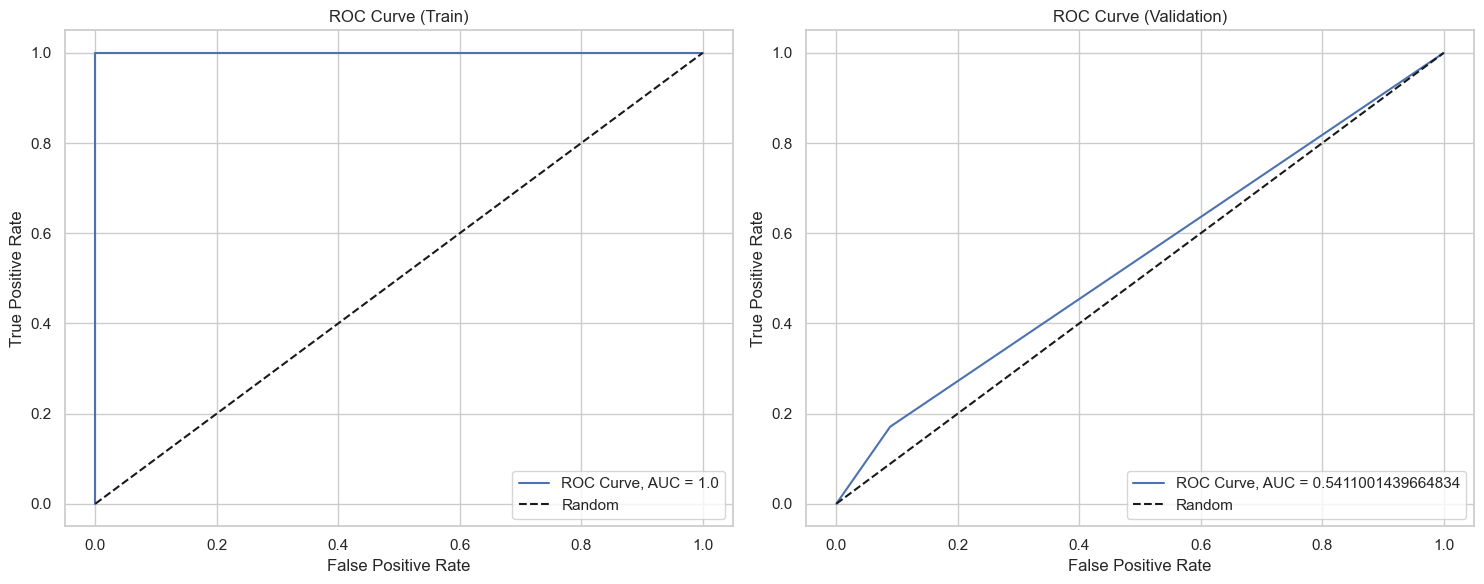

In [164]:
# ROC AUC (Train)
roc_auc_train = roc_auc_score(y_train, y_train_pred_dt)
print(f'ROC AUC (Train): {round(roc_auc_train, 2)}')

# ROC Curve (Train)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_dt)

# ROC AUC (Validation)
roc_auc_val = roc_auc_score(y_val, y_val_pred_dt)
print(f'ROC AUC (Validation): {round(roc_auc_val, 2)}')

# ROC Curve (Validation)
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_val_pred_dt)

# Plot ROC Curves side by side
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plot_roc_curve(fpr_train, tpr_train, roc_auc_train, 'ROC Curve (Train)')

plt.subplot(1, 2, 2)
plot_roc_curve(fpr_val, tpr_val, roc_auc_val, 'ROC Curve (Validation)')

plt.tight_layout()
plt.show()

### Random Forest

In [130]:
# Train the model
rf_model = RandomForestClassifier().fit(X_train, y_train)
print(rf_model)

RandomForestClassifier()


In [131]:
# Predict data train
y_train_pred_rf = rf_model.predict(X_train)
print('Classification Report Training Model (Random Forest):')
print(classification_report(y_train, y_train_pred_rf))

Classification Report Training Model (Random Forest):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226148
           1       1.00      1.00      1.00     19860

    accuracy                           1.00    246008
   macro avg       1.00      1.00      1.00    246008
weighted avg       1.00      1.00      1.00    246008



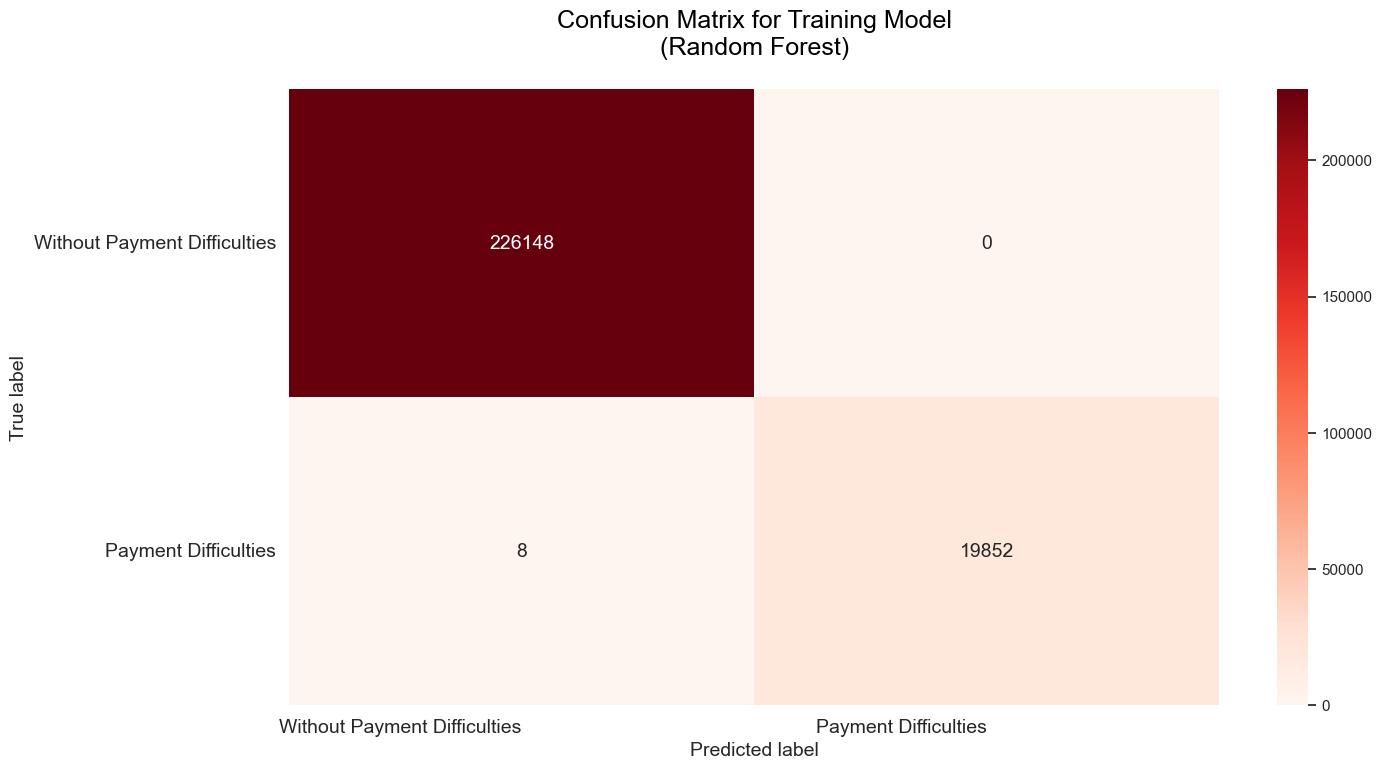

In [132]:
# Form confusion matrix as a dataFrame
confusion_matrix_rf = pd.DataFrame((confusion_matrix(y_train, y_train_pred_rf)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_rf, annot=True, annot_kws={'size': 14}, fmt='d', cmap='Reds')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Random Forest)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [133]:
# Predict data validation
y_val_pred_rf = rf_model.predict(X_val)
from sklearn.metrics import confusion_matrix, classification_report

# Print classification report
print('Classification Report Validating Model (Random Forest):')
print(classification_report(y_val, y_val_pred_rf))

Classification Report Validating Model (Random Forest):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.55      0.00      0.01      4965

    accuracy                           0.92     61503
   macro avg       0.74      0.50      0.48     61503
weighted avg       0.89      0.92      0.88     61503



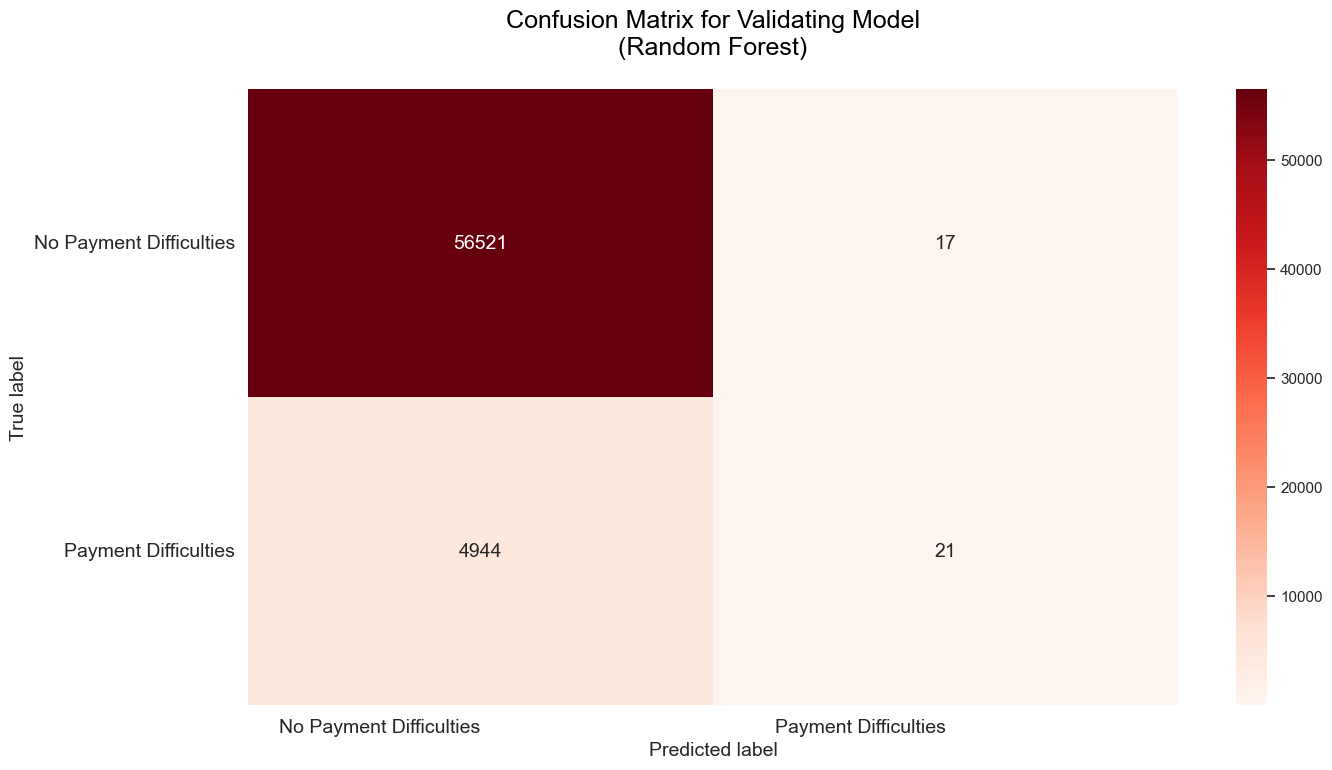

In [134]:
# Form confusion matrix as a dataFrame
confusion_matrix_rf = pd.DataFrame((confusion_matrix(y_val, y_val_pred_rf)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_rf, annot=True, annot_kws={'size': 14}, fmt='d', cmap='Reds')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Validating Model\n(Random Forest)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [135]:
# Recall
recall_train = recall_score(y_train, y_train_pred_rf, average='weighted')
print(f'Recall Train: {round(recall_train, 2)}')
recall_val = recall_score(y_val, y_val_pred_rf, average='weighted')
print(f'Recall Validation: {round(recall_val, 2)}', end='\n\n')

# Precision
precision_train = precision_score(y_train, y_train_pred_rf, average='weighted')
print(f'Precision Train: {round(precision_train, 2)}')
precision_val = precision_score(y_val, y_val_pred_rf, average='weighted')
print(f'Precision Validation: {round(precision_test, 2)}', end='\n\n')

# Accuracy
accuracy_train = accuracy_score(y_train, y_train_pred_rf)
print(f'Accuracy Train: {round(accuracy_train, 2)}')
accuracy_val = accuracy_score(y_val, y_val_pred_rf)
print(f'Accuracy Validation: {round(accuracy_val, 2)}')

Recall Train: 1.0
Recall Validation: 0.92

Precision Train: 1.0
Precision Validation: 0.85

Accuracy Train: 1.0
Accuracy Validation: 0.92


ROC AUC (Train): 1.0
ROC AUC (Validation): 0.5


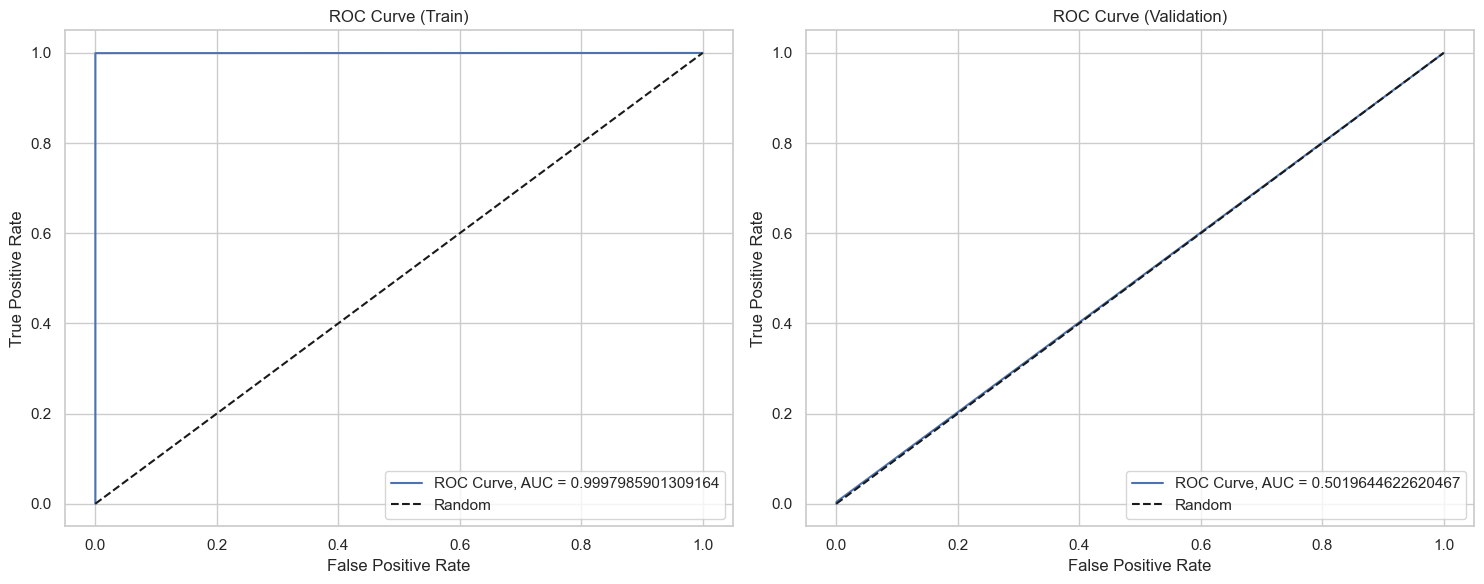

In [136]:
# ROC AUC (Train)
roc_auc_train = roc_auc_score(y_train, y_train_pred_rf)
print(f'ROC AUC (Train): {round(roc_auc_train, 2)}')

# ROC Curve (Train)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_rf)

# ROC AUC (Validation)
roc_auc_val = roc_auc_score(y_val, y_val_pred_rf)
print(f'ROC AUC (Validation): {round(roc_auc_val, 2)}')

# ROC Curve (Validation)
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_val_pred_rf)

# Plot ROC Curves side by side
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plot_roc_curve(fpr_train, tpr_train, roc_auc_train, 'ROC Curve (Train)')

plt.subplot(1, 2, 2)
plot_roc_curve(fpr_val, tpr_val, roc_auc_val, 'ROC Curve (Validation)')

plt.tight_layout()
plt.show()

### Adaboost Classifier

In [175]:
# Train the model
adaboost_model = AdaBoostClassifier().fit(X_train, y_train)
print(adaboost_model)

AdaBoostClassifier()


In [146]:
# Predict data train
y_train_pred_adaboost = adaboost_model.predict(X_train)
print('Classification Report Training Model (Adaboost Classifier):')
print(classification_report(y_train, y_train_pred_adaboost))

Classification Report Training Model (Adaboost Classifier):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    226148
           1       0.49      0.02      0.03     19860

    accuracy                           0.92    246008
   macro avg       0.71      0.51      0.50    246008
weighted avg       0.89      0.92      0.88    246008



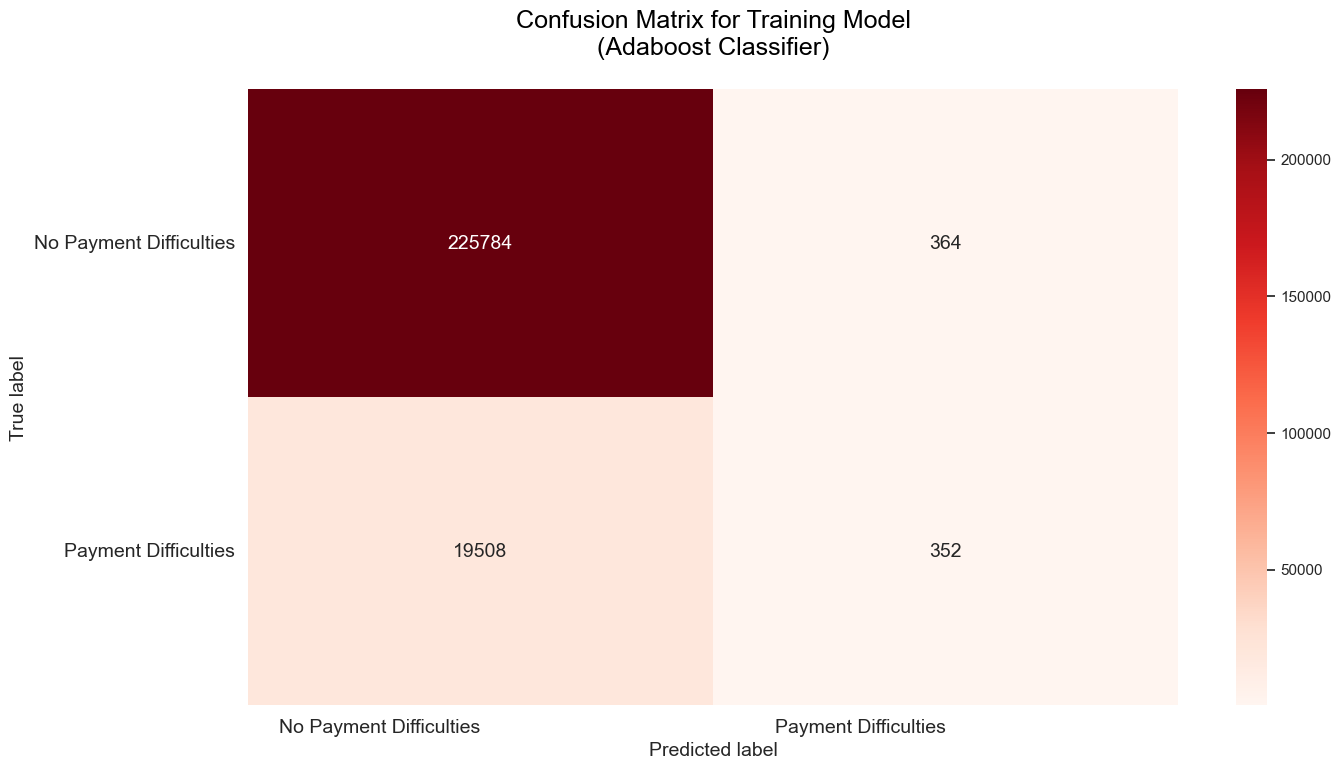

In [165]:
# Form confusion matrix as a dataFrame
confusion_matrix_adaboost = pd.DataFrame((confusion_matrix(y_train, y_train_pred_adaboost)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_adaboost, annot=True, annot_kws={'size': 14}, fmt='d', cmap='Reds')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Adaboost Classifier)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [140]:
# Predict data validation
y_val_pred_adaboost = adaboost_model.predict(X_val)
from sklearn.metrics import confusion_matrix, classification_report

# Print classification report
print('Classification Report Validating Model (Adaboost Classifier):')
print(classification_report(y_val, y_val_pred_adaboost))

Classification Report Validating Model (Adaboost Classifier):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.49      0.02      0.03      4965

    accuracy                           0.92     61503
   macro avg       0.71      0.51      0.50     61503
weighted avg       0.89      0.92      0.88     61503



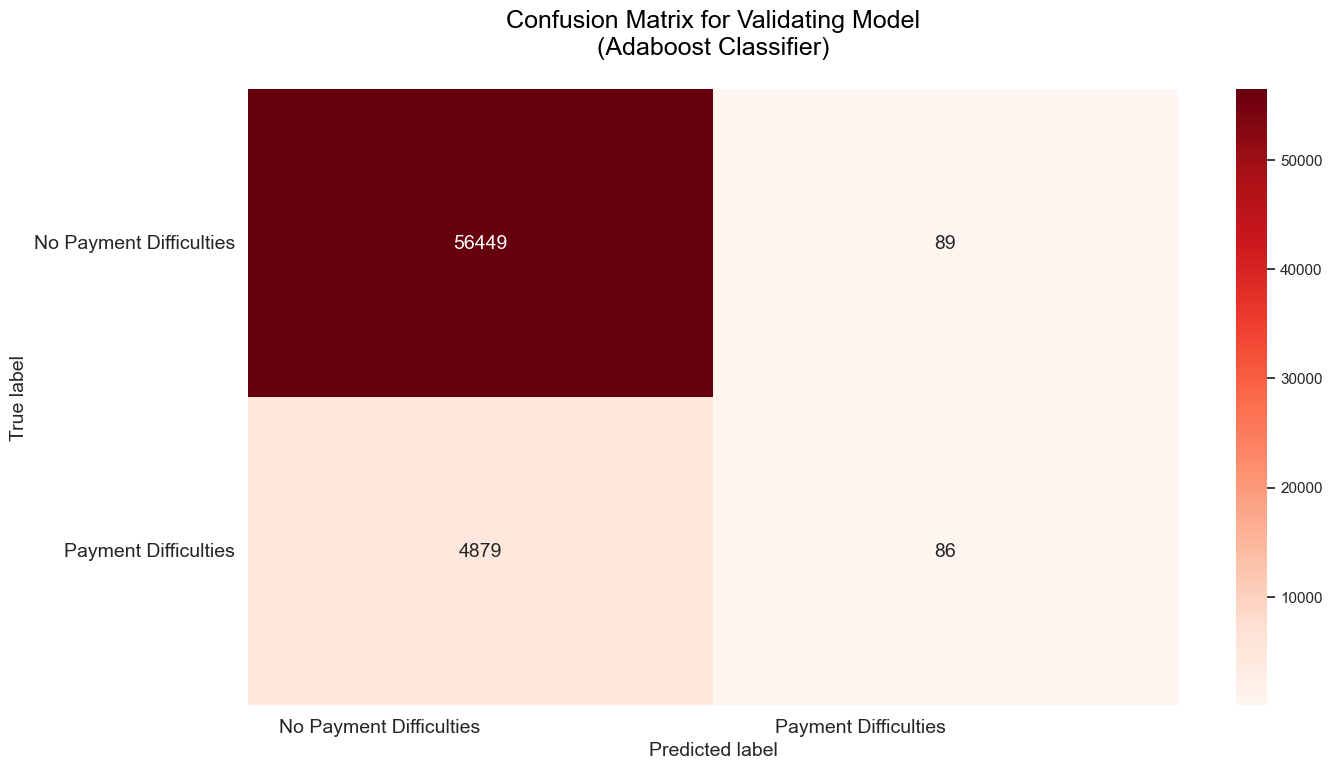

In [141]:
# Form confusion matrix as a dataFrame
confusion_matrix_adaboost = pd.DataFrame((confusion_matrix(y_val, y_val_pred_adaboost)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_adaboost, annot=True, annot_kws={'size': 14}, fmt='d', cmap='Reds')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Validating Model\n(Adaboost Classifier)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [166]:
# Recall
recall_train = recall_score(y_train, y_train_pred_adaboost, average='weighted')
print(f'Recall Train: {round(recall_train, 2)}')
recall_val = recall_score(y_val, y_val_pred_adaboost, average='weighted')
print(f'Recall Validation: {round(recall_val, 2)}', end='\n\n')

# Precision
precision_train = precision_score(y_train, y_train_pred_adaboost, average='weighted')
print(f'Precision Train: {round(precision_train, 2)}')
precision_val = precision_score(y_val, y_val_pred_adaboost, average='weighted')
print(f'Precision Validation: {round(precision_test, 2)}', end='\n\n')

# Accuracy
accuracy_train = accuracy_score(y_train, y_train_pred_adaboost)
print(f'Accuracy Train: {round(accuracy_train, 2)}')
accuracy_val = accuracy_score(y_val, y_val_pred_adaboost)
print(f'Accuracy Validation: {round(accuracy_val, 2)}')

Recall Train: 0.92
Recall Validation: 0.92

Precision Train: 0.89
Precision Validation: 0.85

Accuracy Train: 0.92
Accuracy Validation: 0.92


ROC AUC (Train): 0.51
ROC AUC (Validation): 0.51


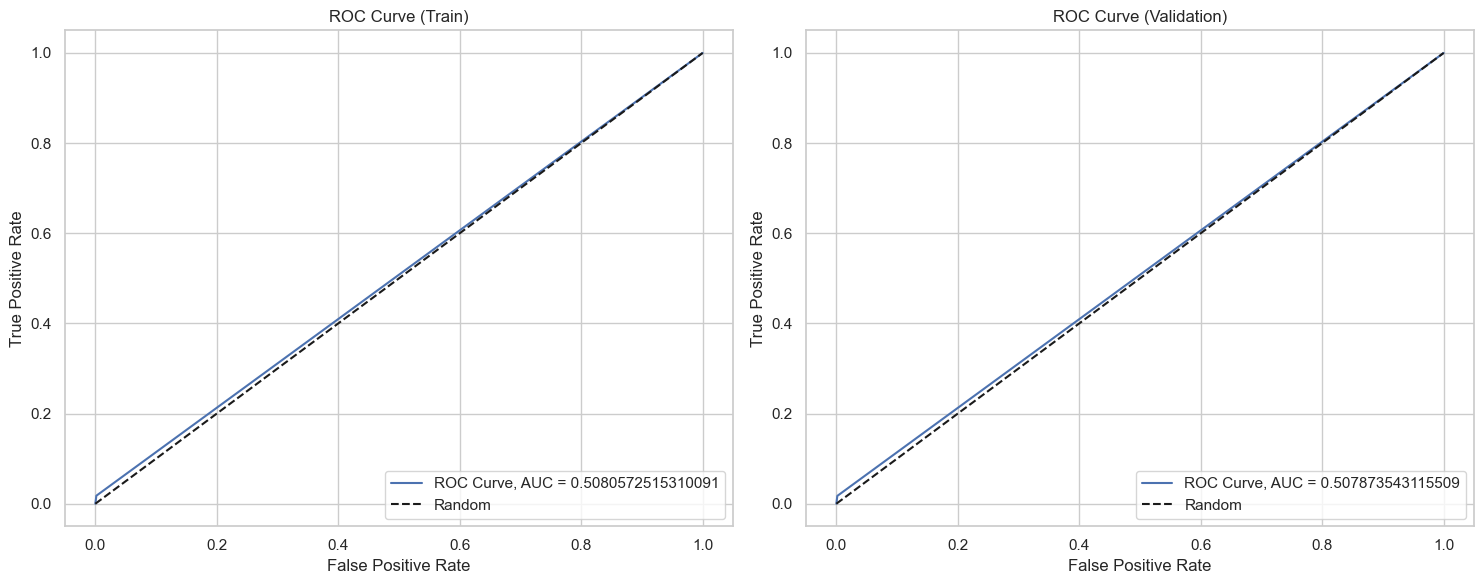

In [143]:
# ROC AUC (Train)
roc_auc_train = roc_auc_score(y_train, y_train_pred_adaboost)
print(f'ROC AUC (Train): {round(roc_auc_train, 2)}')

# ROC Curve (Train)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_adaboost)

# ROC AUC (Validation)
roc_auc_val = roc_auc_score(y_val, y_val_pred_adaboost)
print(f'ROC AUC (Validation): {round(roc_auc_val, 2)}')

# ROC Curve (Validation)
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_val_pred_adaboost)

# Plot ROC Curves side by side
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plot_roc_curve(fpr_train, tpr_train, roc_auc_train, 'ROC Curve (Train)')

plt.subplot(1, 2, 2)
plot_roc_curve(fpr_val, tpr_val, roc_auc_val, 'ROC Curve (Validation)')

plt.tight_layout()
plt.show()

### XGBoost Classifier

In [150]:
# Train the model
xgboost_model = XGBClassifier().fit(X_train, y_train)
print(xgboost_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [151]:
# Predict data train
y_train_pred_xgboost = xgboost_model.predict(X_train)
print('Classification Report Training Model (XGboost Classifier):')
print(classification_report(y_train, y_train_pred_xgboost))

Classification Report Training Model (XGboost Classifier):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    226148
           1       0.83      0.06      0.12     19860

    accuracy                           0.92    246008
   macro avg       0.88      0.53      0.54    246008
weighted avg       0.92      0.92      0.89    246008



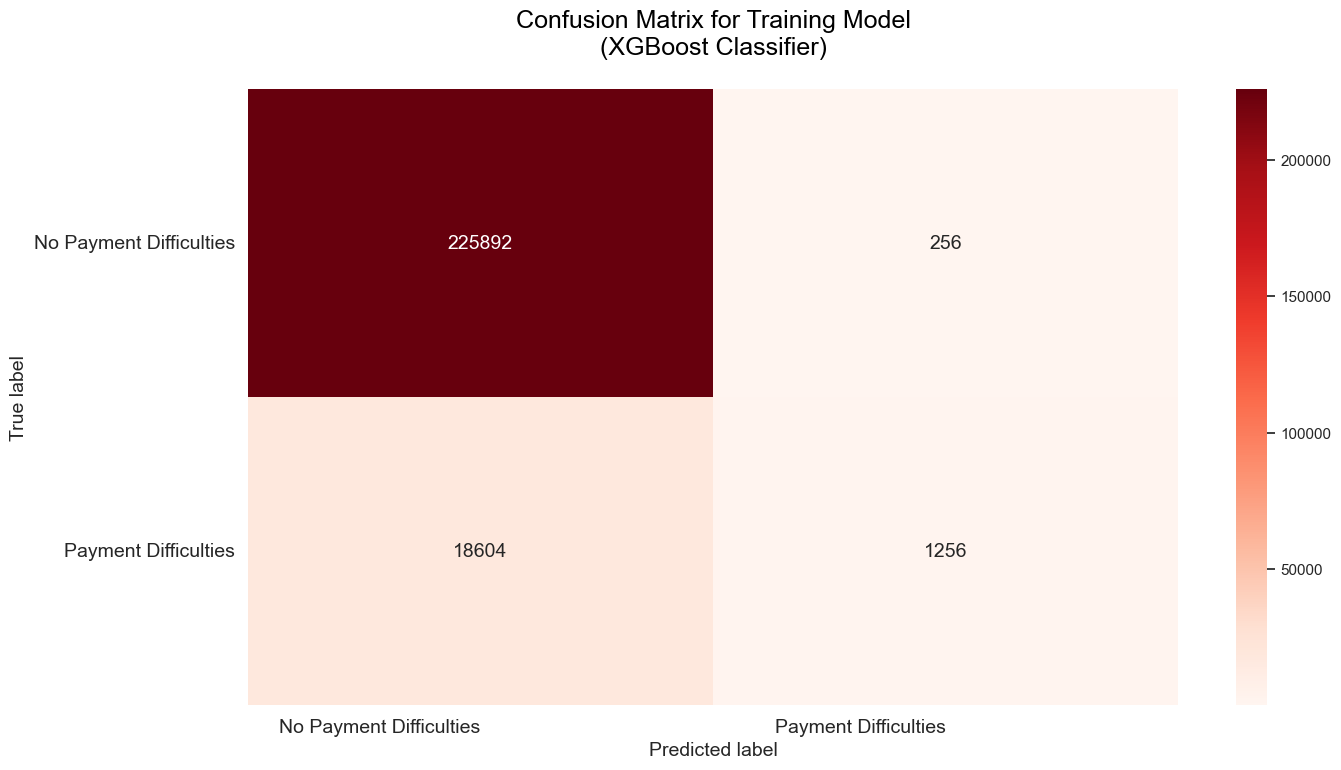

In [152]:
# Form confusion matrix as a dataFrame
confusion_matrix_xgboost = pd.DataFrame((confusion_matrix(y_train, y_train_pred_xgboost)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_xgboost, annot=True, annot_kws={'size': 14}, fmt='d', cmap='Reds')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(XGBoost Classifier)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [153]:
# Predict data validation
y_val_pred_xgboost = xgboost_model.predict(X_val)
from sklearn.metrics import confusion_matrix, classification_report

# Print classification report
print('Classification Report Validating Model (XGBoost Classifier):')
print(classification_report(y_val, y_val_pred_xgboost))

Classification Report Validating Model (XGBoost Classifier):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.49      0.02      0.05      4965

    accuracy                           0.92     61503
   macro avg       0.71      0.51      0.50     61503
weighted avg       0.89      0.92      0.88     61503



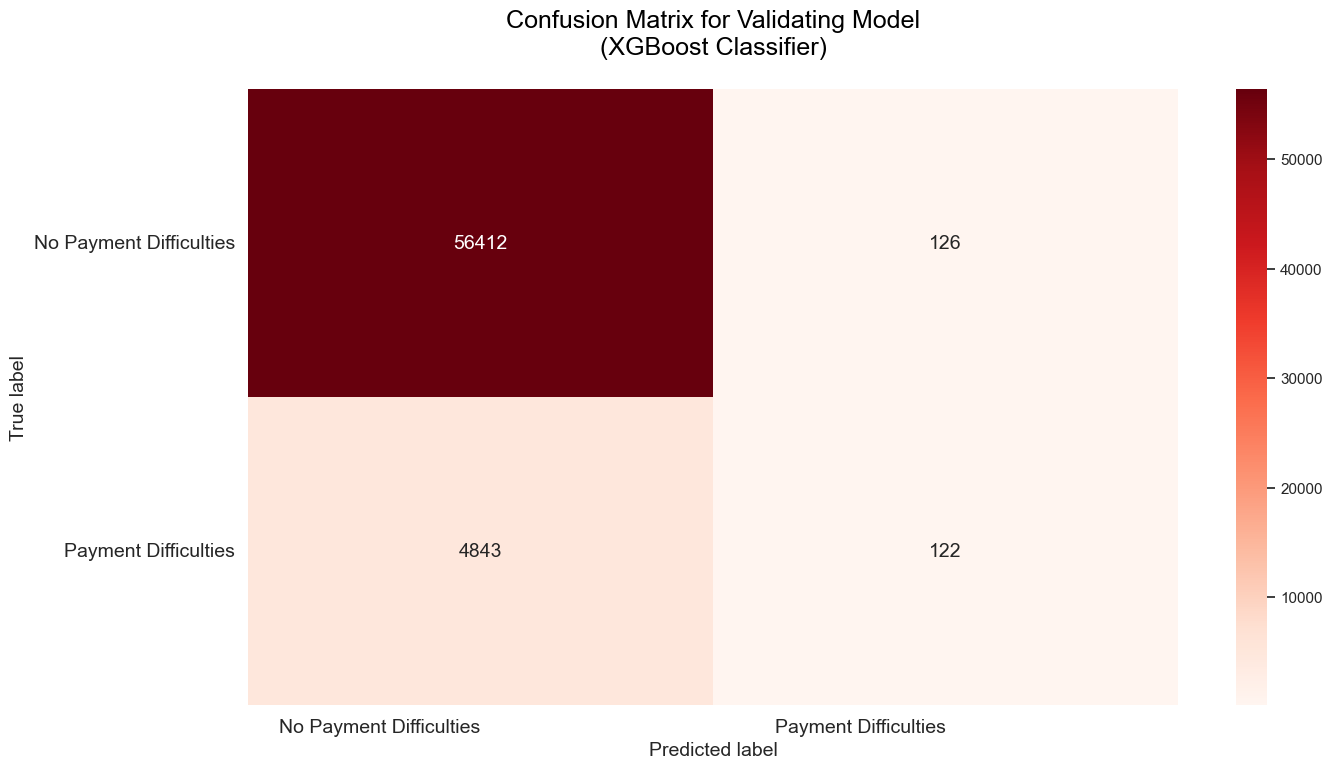

In [154]:
# Form confusion matrix as a dataFrame
confusion_matrix_xgboost = pd.DataFrame((confusion_matrix(y_val, y_val_pred_xgboost)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_xgboost, annot=True, annot_kws={'size': 14}, fmt='d', cmap='Reds')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Validating Model\n(XGBoost Classifier)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [155]:
# Recall
recall_train = recall_score(y_train, y_train_pred_xgboost, average='weighted')
print(f'Recall Train: {round(recall_train, 2)}')
recall_val = recall_score(y_val, y_val_pred_xgboost, average='weighted')
print(f'Recall Validation: {round(recall_val, 2)}', end='\n\n')

# Precision
precision_train = precision_score(y_train, y_train_pred_xgboost, average='weighted')
print(f'Precision Train: {round(precision_train, 2)}')
precision_val = precision_score(y_val, y_val_pred_xgboost, average='weighted')
print(f'Precision Validation: {round(precision_test, 2)}', end='\n\n')

# Accuracy
accuracy_train = accuracy_score(y_train, y_train_pred_xgboost)
print(f'Accuracy Train: {round(accuracy_train, 2)}')
accuracy_val = accuracy_score(y_val, y_val_pred_xgboost)
print(f'Accuracy Validation: {round(accuracy_val, 2)}')

Recall Train: 0.92
Recall Validation: 0.92

Precision Train: 0.92
Precision Validation: 0.85

Accuracy Train: 0.92
Accuracy Validation: 0.92


ROC AUC (Train): 0.53
ROC AUC (Validation): 0.51


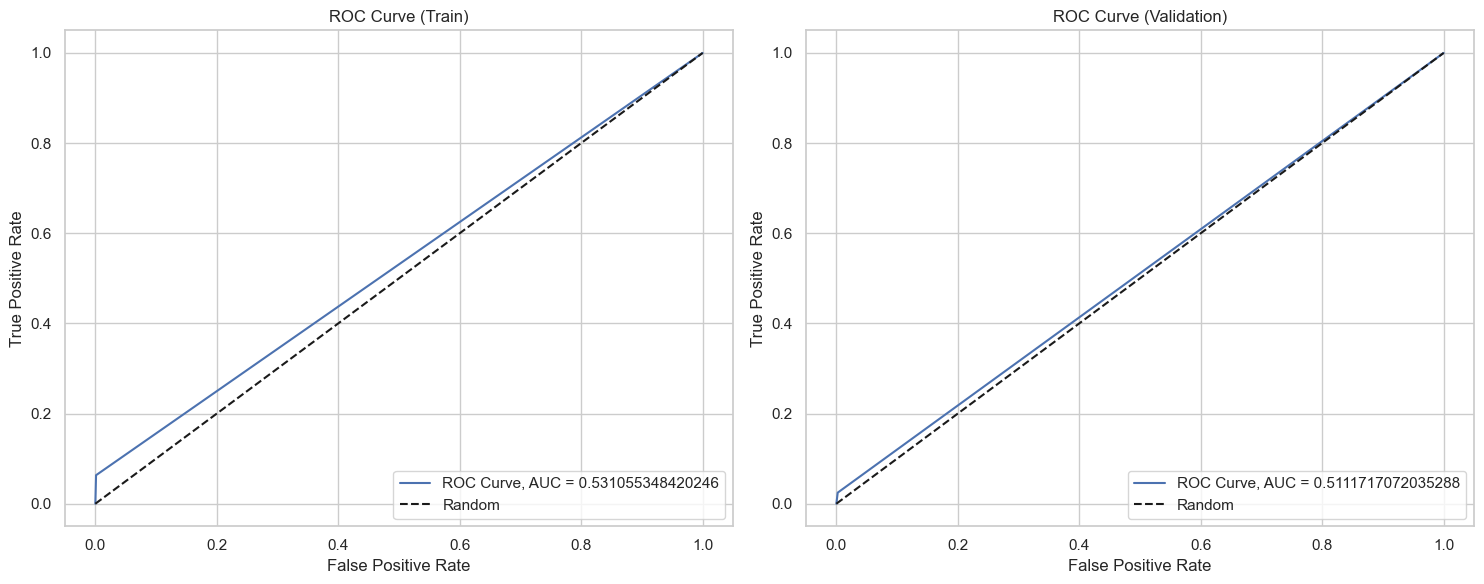

In [156]:
# ROC AUC (Train)
roc_auc_train = roc_auc_score(y_train, y_train_pred_xgboost)
print(f'ROC AUC (Train): {round(roc_auc_train, 2)}')

# ROC Curve (Train)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_xgboost)

# ROC AUC (Validation)
roc_auc_val = roc_auc_score(y_val, y_val_pred_xgboost)
print(f'ROC AUC (Validation): {round(roc_auc_val, 2)}')

# ROC Curve (Validation)
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_val_pred_xgboost)

# Plot ROC Curves side by side
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plot_roc_curve(fpr_train, tpr_train, roc_auc_train, 'ROC Curve (Train)')

plt.subplot(1, 2, 2)
plot_roc_curve(fpr_val, tpr_val, roc_auc_val, 'ROC Curve (Validation)')

plt.tight_layout()
plt.show()

### Gradient Boosting Classifier

In [157]:
# Train the model
gb_model = GradientBoostingClassifier().fit(X_train, y_train)
print(gb_model)

GradientBoostingClassifier()


In [158]:
# Predict data train
y_train_pred_gb = gb_model.predict(X_train)
print('Classification Report Training Model (Gradient Boosting Classifier):')
print(classification_report(y_train, y_train_pred_gb))

Classification Report Training Model (Gradient Boosting Classifier):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    226148
           1       0.64      0.01      0.03     19860

    accuracy                           0.92    246008
   macro avg       0.78      0.51      0.49    246008
weighted avg       0.90      0.92      0.88    246008



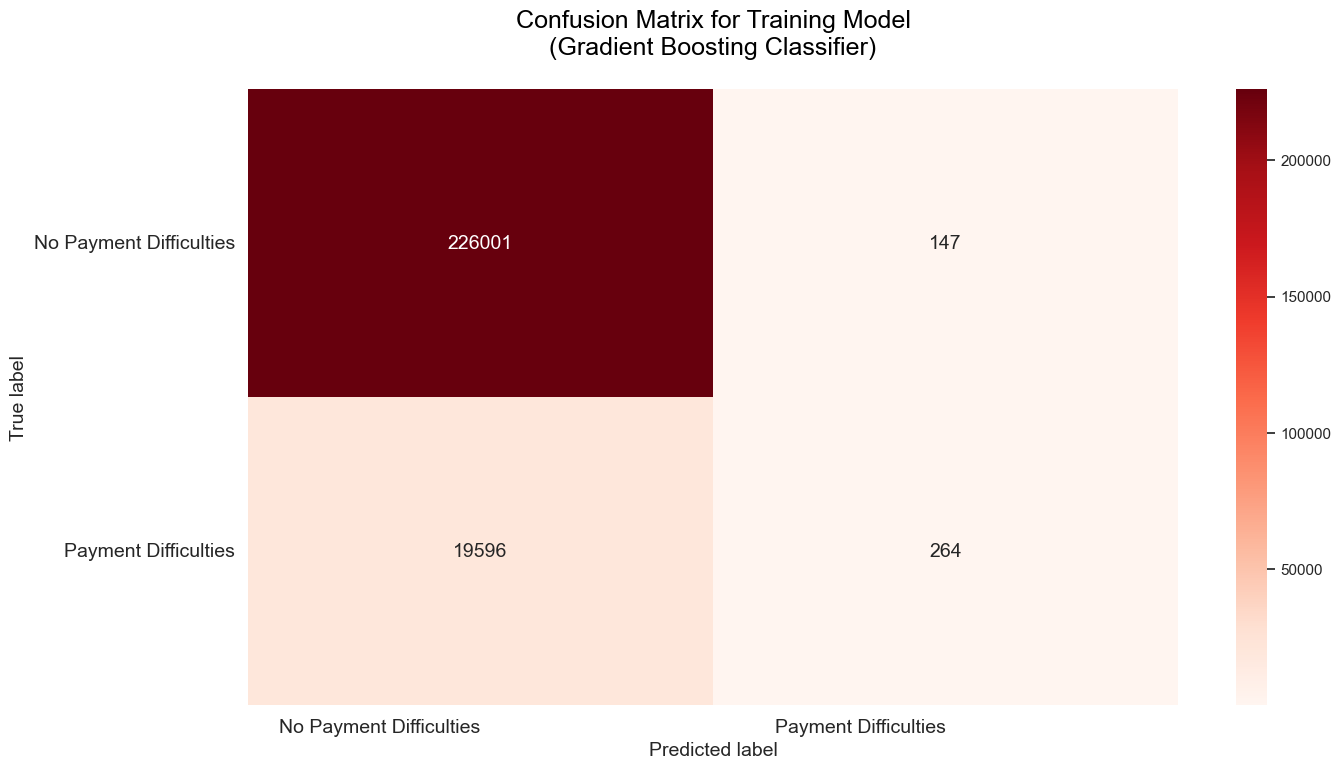

In [159]:
# Form confusion matrix as a dataFrame
confusion_matrix_gb = pd.DataFrame((confusion_matrix(y_train, y_train_pred_gb)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_gb, annot=True, annot_kws={'size': 14}, fmt='d', cmap='Reds')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Training Model\n(Gradient Boosting Classifier)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [160]:
# Predict data validation
y_val_pred_gb = gb_model.predict(X_val)
from sklearn.metrics import confusion_matrix, classification_report

# Print classification report
print('Classification Report Validating Model (Gradient Boosting Classifier):')
print(classification_report(y_val, y_val_pred_gb))

Classification Report Validating Model (Gradient Boosting Classifier):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.50      0.01      0.02      4965

    accuracy                           0.92     61503
   macro avg       0.71      0.50      0.49     61503
weighted avg       0.89      0.92      0.88     61503



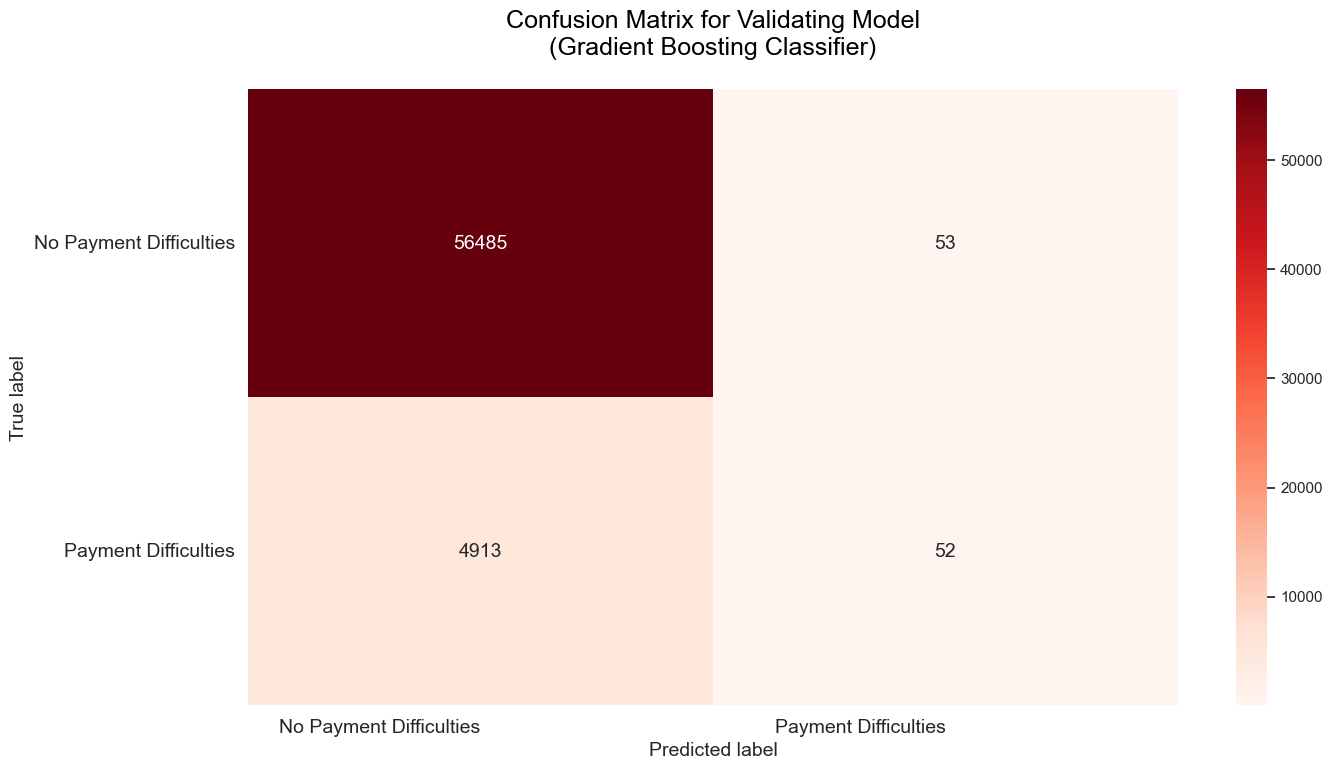

In [161]:
# Form confusion matrix as a dataFrame
confusion_matrix_gb = pd.DataFrame((confusion_matrix(y_val, y_val_pred_gb)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

# Plot confusion matrix
plt.figure()
heatmap = sns.heatmap(confusion_matrix_gb, annot=True, annot_kws={'size': 14}, fmt='d', cmap='Reds')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Confusion Matrix for Validating Model\n(Gradient Boosting Classifier)\n', fontsize=18, color='black')
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.show()

In [162]:
# Recall
recall_train = recall_score(y_train, y_train_pred_gb, average='weighted')
print(f'Recall Train: {round(recall_train, 2)}')
recall_val = recall_score(y_val, y_val_pred_gb, average='weighted')
print(f'Recall Validation: {round(recall_val, 2)}', end='\n\n')

# Precision
precision_train = precision_score(y_train, y_train_pred_gb, average='weighted')
print(f'Precision Train: {round(precision_train, 2)}')
precision_val = precision_score(y_val, y_val_pred_gb, average='weighted')
print(f'Precision Validation: {round(precision_test, 2)}', end='\n\n')

# Accuracy
accuracy_train = accuracy_score(y_train, y_train_pred_gb)
print(f'Accuracy Train: {round(accuracy_train, 2)}')
accuracy_val = accuracy_score(y_val, y_val_pred_gb)
print(f'Accuracy Validation: {round(accuracy_val, 2)}')

Recall Train: 0.92
Recall Validation: 0.92

Precision Train: 0.9
Precision Validation: 0.85

Accuracy Train: 0.92
Accuracy Validation: 0.92


ROC AUC (Train): 0.51
ROC AUC (Validation): 0.51


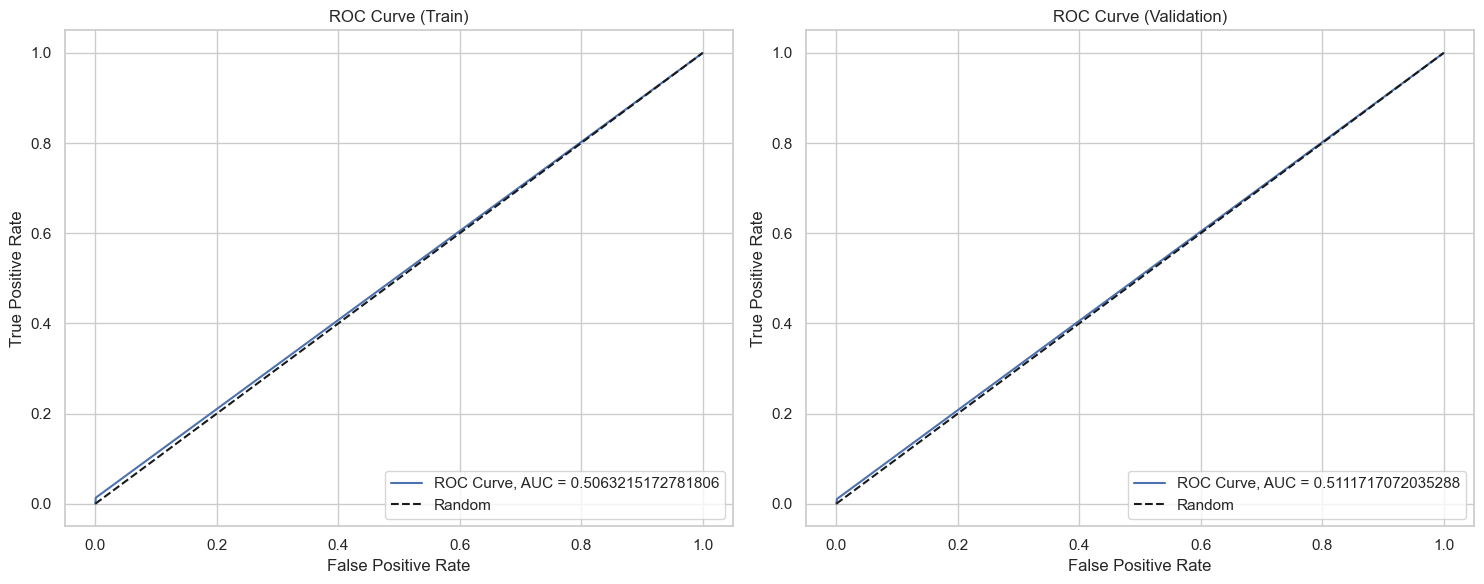

In [163]:
# ROC AUC (Train)
roc_auc_train = roc_auc_score(y_train, y_train_pred_gb)
print(f'ROC AUC (Train): {round(roc_auc_train, 2)}')

# ROC Curve (Train)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_gb)

# ROC AUC (Validation)
roc_auc_val = roc_auc_score(y_val, y_val_pred_xgboost)
print(f'ROC AUC (Validation): {round(roc_auc_val, 2)}')

# ROC Curve (Validation)
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_val_pred_gb)

# Plot ROC Curves side by side
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plot_roc_curve(fpr_train, tpr_train, roc_auc_train, 'ROC Curve (Train)')

plt.subplot(1, 2, 2)
plot_roc_curve(fpr_val, tpr_val, roc_auc_val, 'ROC Curve (Validation)')

plt.tight_layout()
plt.show()

### Each Model's Performance

In [170]:
data = [["Logistic Regression", 0.92, 0.92, 0.85, 0.85, 0.92, 0.92, 1.0, 0.54],
        ["Decision Tree", 1.0, 0.85, 1.0, 0.85, 1.0, 0.92, 1.0, 0.54],
        ["Random Forest", 1.0, 0.92, 1.0, 0.85, 1.0, 0.92, 1.0, 0.5],
        ["Adaboost Classifier", 0.92, 0.92, 0.89, 0.85, 0.92, 0.92, 0.51, 0.51],
        ["XGBoost Classifier", 0.92, 0.92, 0.92, 0.85, 0.92, 0.92, 0.53, 0.51], 
        ["Gradient Boosting Classifier", 0.92, 0.92, 0.9, 0.85, 0.92, 0.92, 0.51, 0.51]]

columns = ['Models', 'Recall Train', 'Recall Val', 'Precision Train', 'Precision Val', 'Accuracy Train', 'Accuracy Val', 'ROC AUC Train', 'ROC AUC Val']

results = pd.DataFrame(data, columns=columns)
results = results.reset_index(drop=True)  # Reset the index
results.sort_values(by=['Recall Train', 'Recall Val', 'Precision Train', 'Precision Val', 'Accuracy Train', 'Accuracy Val', 'ROC AUC Train', 'ROC AUC Val'], ascending=False).style.background_gradient(cmap='Reds')

### Hyperparameter Tuning

In [172]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

adaboost_model = AdaBoostClassifier()

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

# Define the scoring metric as recall
scorer = make_scorer(recall_score, average='weighted')

# Perform Grid Search
grid_search = GridSearchCV(adaboost_model, param_grid, cv=5, scoring=scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters from Grid Search
best_params_grid = grid_search.best_params_
print("Best Parameters from Grid Search:", best_params_grid)


KeyboardInterrupt



In [ ]:
# Predict data train with the best model
y_train_pred_adaboost_best_grid = adaboost_model_best_grid.predict(X_train)

# Print classification report for training data
print('Classification Report Training Model (Adaboost Classifier - Grid Search):')
print(classification_report(y_train, y_train_pred_adaboost_best_grid))

In [ ]:
# Predict data validation with the best model
y_val_pred_adaboost_best_grid = adaboost_model_best_grid.predict(X_val)

# Print classification report for validation data
print('Classification Report Validating Model (Adaboost Classifier - Grid Search):')
print(classification_report(y_val, y_val_pred_adaboost_best_grid))

In [ ]:
# Define the parameter grid for Randomized Search
param_dist = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

# Perform Randomized Search
random_search = RandomizedSearchCV(adaboost_model, param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1)
random_search.fit(X_train, y_train)

# Get the best parameters from Randomized Search
best_params_random = random_search.best_params_
print("Best Parameters from Randomized Search:", best_params_random)

# Train the model with the best parameters from Randomized Search
adaboost_model_best_random = random_search.best_estimator_

In [ ]:
# Predict data train with the best model from Randomized Search
y_train_pred_adaboost_best_random = adaboost_model_best_random.predict(X_train)

# Print classification report for training data
print('Classification Report Training Model (Adaboost Classifier - Randomized Search):')
print(classification_report(y_train, y_train_pred_adaboost_best_random))

In [ ]:
# Predict data validation with the best model from Randomized Search
y_val_pred_adaboost_best_random = adaboost_model_best_random.predict(X_val)

# Print classification report for validation data
print('Classification Report Validating Model (Adaboost Classifier - Randomized Search):')
print(classification_report(y_val, y_val_pred_adaboost_best_random))

### Feature Importance

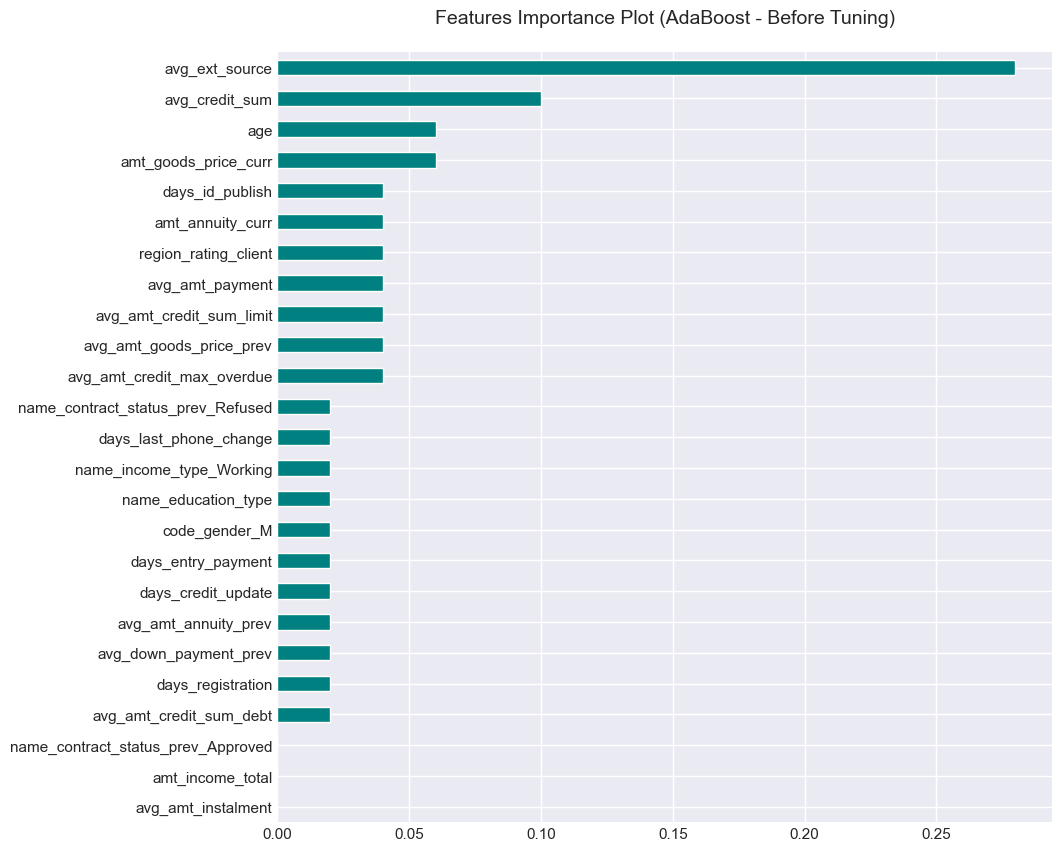

In [177]:
# Train the AdaBoost model
adaboost_model = AdaBoostClassifier()
adaboost_model.fit(X_train, y_train)

# Get feature importances
importances_adaboost = pd.Series(adaboost_model.feature_importances_, index=X_train.columns).sort_values(ascending=True)

# Plot feature importances
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10, 10))
fig = importances_adaboost.plot(kind='barh', color='teal')
plt.title('Features Importance Plot (AdaBoost - Before Tuning)\n', fontsize=14)
plt.show()

# Save the figure
fig.figure.tight_layout()
fig.figure.savefig('top_feature_adaboost_before_tuning.png')

In [173]:
def shap_plot(model, model_name, data=None):

    model_name = re.sub('\s*\(\w*\)\s*', '', model_name)

    tree = ["Decision Tree", "Random Forest", "XGBoost Classifier", "Gradient Boosting Classifier"]

    shap.initjs()

    if model_name in tree:

        if model_name in ["XGBoost Classifier", "Gradient Boosting Classifier"] :
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(data)
            expected = explainer.expected_value
        else:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(data)[1]
            expected = explainer.expected_value[1]


        fig = plt.figure()
        ax0 = fig.add_subplot(121)
        shap.summary_plot(shap_values, data, show = False)
        ax1 = fig.add_subplot(122)
        shap.summary_plot(shap_values, data, plot_type='bar', show = False, cmap = "plasma")
        plt.gcf().set_size_inches(20,8)
        plt.tight_layout()
        plt.show()

        return shap.force_plot(expected, shap_values[0], data.iloc[0,:], plot_cmap = "PkYg", show = False)

    else :
        explainer = shap.Explainer(model.predict, data)
        shap_values = explainer(data)

        fig = plt.figure()
        ax0 = fig.add_subplot(121)
        shap.summary_plot(shap_values.values, data, show = False)
        ax1 = fig.add_subplot(122)
        shap.summary_plot(shap_values.values, data, plot_type='bar', show = False, cmap = "plasma")
        plt.gcf().set_size_inches(20,8)
        plt.tight_layout()
        plt.show()

        return shap.force_plot(shap_values.base_values[0], shap_values.values[0], data.iloc[0,:], plot_cmap = "PkYg", show = False)

In [176]:
shap_plot(adaboost_model, "Adaboost Classifier", X_train)

Permutation explainer:   0%|          | 731/246008 [13:21<75:30:47,  1.11s/it] 

KeyboardInterrupt

